# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 3.1816416663794853 -3.0193599502854744
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [79]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [80]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [81]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [82]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [83]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [84]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [85]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [86]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [87]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [88]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR.ckpt')

Episode:0 meanR:13.0000 rate:0.0260 gloss:0.0365 dloss:0.7104 dlossR:0.7104 dlossQ:0.6927
Episode:1 meanR:11.0000 rate:0.0180 gloss:0.0034 dloss:0.6872 dlossR:0.6872 dlossQ:0.6932
Episode:2 meanR:10.6667 rate:0.0200 gloss:-0.0353 dloss:0.6505 dlossR:0.6505 dlossQ:0.6927
Episode:3 meanR:10.7500 rate:0.0220 gloss:-0.0754 dloss:0.6144 dlossR:0.6144 dlossQ:0.6905
Episode:4 meanR:10.6000 rate:0.0200 gloss:-0.1202 dloss:0.5837 dlossR:0.5837 dlossQ:0.6877
Episode:5 meanR:10.5000 rate:0.0200 gloss:-0.1663 dloss:0.5574 dlossR:0.5574 dlossQ:0.6840
Episode:6 meanR:10.2857 rate:0.0180 gloss:-0.2178 dloss:0.5301 dlossR:0.5301 dlossQ:0.6798
Episode:7 meanR:17.3750 rate:0.1340 gloss:0.0047 dloss:0.6485 dlossR:0.6485 dlossQ:0.6959
Episode:8 meanR:20.2222 rate:0.0860 gloss:-0.0029 dloss:0.6562 dlossR:0.6562 dlossQ:0.6948
Episode:9 meanR:23.6000 rate:0.1080 gloss:-0.0013 dloss:0.6510 dlossR:0.6510 dlossQ:0.6953
Episode:10 meanR:24.5455 rate:0.0680 gloss:-0.0353 dloss:0.6414 dlossR:0.6414 dlossQ:0.6940
E

Episode:91 meanR:33.2283 rate:0.0280 gloss:-1.8466 dloss:0.1364 dlossR:0.1364 dlossQ:0.3084
Episode:92 meanR:32.9892 rate:0.0220 gloss:-1.9338 dloss:0.1161 dlossR:0.1161 dlossQ:0.3240
Episode:93 meanR:32.7340 rate:0.0180 gloss:-1.9905 dloss:0.1028 dlossR:0.1028 dlossQ:0.3751
Episode:94 meanR:32.5158 rate:0.0240 gloss:-2.0353 dloss:0.1203 dlossR:0.1203 dlossQ:0.3156
Episode:95 meanR:32.3125 rate:0.0260 gloss:-1.9751 dloss:0.1267 dlossR:0.1267 dlossQ:0.3079
Episode:96 meanR:32.1649 rate:0.0360 gloss:-1.7964 dloss:0.1603 dlossR:0.1603 dlossQ:0.3016
Episode:97 meanR:32.1122 rate:0.0540 gloss:-1.7871 dloss:0.2111 dlossR:0.2111 dlossQ:0.2951
Episode:98 meanR:32.3131 rate:0.1040 gloss:-1.7853 dloss:0.3498 dlossR:0.3498 dlossQ:0.2815
Episode:99 meanR:32.8200 rate:0.1660 gloss:-1.6753 dloss:0.5084 dlossR:0.5084 dlossQ:0.2936
Episode:100 meanR:33.3200 rate:0.1260 gloss:-1.7101 dloss:0.4037 dlossR:0.4037 dlossQ:0.2884
Episode:101 meanR:33.5600 rate:0.0660 gloss:-1.7085 dloss:0.2435 dlossR:0.2435 

Episode:181 meanR:43.8800 rate:0.1020 gloss:-1.6661 dloss:0.3537 dlossR:0.3537 dlossQ:0.3388
Episode:182 meanR:44.0100 rate:0.0860 gloss:-1.7020 dloss:0.3110 dlossR:0.3110 dlossQ:0.3335
Episode:183 meanR:43.9600 rate:0.1160 gloss:-1.6076 dloss:0.3802 dlossR:0.3802 dlossQ:0.3334
Episode:184 meanR:44.1800 rate:0.0940 gloss:-1.7568 dloss:0.3368 dlossR:0.3368 dlossQ:0.3286
Episode:185 meanR:44.4800 rate:0.1000 gloss:-1.6907 dloss:0.3422 dlossR:0.3422 dlossQ:0.3125
Episode:186 meanR:44.8100 rate:0.1040 gloss:-1.7263 dloss:0.3552 dlossR:0.3552 dlossQ:0.3088
Episode:187 meanR:45.8700 rate:0.2440 gloss:-1.4710 dloss:0.6773 dlossR:0.6773 dlossQ:0.3523
Episode:188 meanR:46.1400 rate:0.0900 gloss:-1.4486 dloss:0.3027 dlossR:0.3027 dlossQ:0.3555
Episode:189 meanR:46.3400 rate:0.0640 gloss:-1.4624 dloss:0.2436 dlossR:0.2436 dlossQ:0.3556
Episode:190 meanR:46.8300 rate:0.1280 gloss:-1.4233 dloss:0.3882 dlossR:0.3882 dlossQ:0.3610
Episode:191 meanR:47.2100 rate:0.1040 gloss:-1.4571 dloss:0.3347 dloss

Episode:270 meanR:30.2600 rate:0.0320 gloss:-1.9282 dloss:0.1482 dlossR:0.1482 dlossQ:0.2931
Episode:271 meanR:31.4800 rate:0.2700 gloss:-1.4039 dloss:0.7234 dlossR:0.7234 dlossQ:0.3702
Episode:272 meanR:32.1100 rate:0.1500 gloss:-1.5189 dloss:0.4473 dlossR:0.4473 dlossQ:0.3386
Episode:273 meanR:32.2900 rate:0.0780 gloss:-1.5510 dloss:0.2749 dlossR:0.2749 dlossQ:0.3400
Episode:274 meanR:32.3400 rate:0.0460 gloss:-1.6398 dloss:0.1946 dlossR:0.1946 dlossQ:0.3334
Episode:275 meanR:32.3100 rate:0.0240 gloss:-2.0594 dloss:0.1242 dlossR:0.1242 dlossQ:0.3170
Episode:276 meanR:32.2500 rate:0.0240 gloss:-2.0384 dloss:0.1256 dlossR:0.1256 dlossQ:0.3452
Episode:277 meanR:32.3000 rate:0.0320 gloss:-1.7224 dloss:0.1537 dlossR:0.1537 dlossQ:0.3180
Episode:278 meanR:32.3400 rate:0.0320 gloss:-1.5902 dloss:0.1606 dlossR:0.1606 dlossQ:0.3507
Episode:279 meanR:32.3600 rate:0.0440 gloss:-1.5370 dloss:0.1938 dlossR:0.1938 dlossQ:0.3466
Episode:280 meanR:32.4300 rate:0.0340 gloss:-1.5748 dloss:0.1668 dloss

Episode:362 meanR:45.2900 rate:0.1200 gloss:-1.5426 dloss:0.3842 dlossR:0.3842 dlossQ:0.3421
Episode:363 meanR:45.7300 rate:0.1200 gloss:-1.4286 dloss:0.3757 dlossR:0.3757 dlossQ:0.3705
Episode:364 meanR:45.8200 rate:0.0420 gloss:-1.2601 dloss:0.2135 dlossR:0.2135 dlossQ:0.4200
Episode:365 meanR:46.1800 rate:0.1000 gloss:-1.2463 dloss:0.3285 dlossR:0.3285 dlossQ:0.4175
Episode:366 meanR:46.3300 rate:0.0500 gloss:-1.3078 dloss:0.2249 dlossR:0.2249 dlossQ:0.4026
Episode:367 meanR:46.4800 rate:0.0500 gloss:-1.3255 dloss:0.2233 dlossR:0.2233 dlossQ:0.3998
Episode:368 meanR:46.6000 rate:0.0440 gloss:-1.3525 dloss:0.2081 dlossR:0.2081 dlossQ:0.3977
Episode:369 meanR:46.7200 rate:0.0420 gloss:-1.4507 dloss:0.1952 dlossR:0.1952 dlossQ:0.3732
Episode:370 meanR:46.7200 rate:0.0320 gloss:-1.4651 dloss:0.1704 dlossR:0.1704 dlossQ:0.3751
Episode:371 meanR:45.5400 rate:0.0340 gloss:-1.5322 dloss:0.1703 dlossR:0.1703 dlossQ:0.3593
Episode:372 meanR:44.9500 rate:0.0320 gloss:-1.6019 dloss:0.1607 dloss

Episode:451 meanR:60.9900 rate:0.0380 gloss:-1.1340 dloss:0.2253 dlossR:0.2253 dlossQ:0.4605
Episode:452 meanR:61.0700 rate:0.0580 gloss:-1.1231 dloss:0.2627 dlossR:0.2627 dlossQ:0.4587
Episode:453 meanR:61.1400 rate:0.0500 gloss:-1.1862 dloss:0.2405 dlossR:0.2405 dlossQ:0.4408
Episode:454 meanR:61.0700 rate:0.0320 gloss:-1.2439 dloss:0.1977 dlossR:0.1977 dlossQ:0.4351
Episode:455 meanR:61.1300 rate:0.0380 gloss:-1.3432 dloss:0.1990 dlossR:0.1990 dlossQ:0.4080
Episode:456 meanR:60.4200 rate:0.0320 gloss:-1.3927 dloss:0.1806 dlossR:0.1806 dlossQ:0.3917
Episode:457 meanR:60.3800 rate:0.0280 gloss:-1.5078 dloss:0.1611 dlossR:0.1611 dlossQ:0.3796
Episode:458 meanR:60.2400 rate:0.0220 gloss:-1.6768 dloss:0.1366 dlossR:0.1366 dlossQ:0.3700
Episode:459 meanR:60.1600 rate:0.0200 gloss:-1.7934 dloss:0.1283 dlossR:0.1283 dlossQ:0.3728
Episode:460 meanR:60.1800 rate:0.0220 gloss:-1.9145 dloss:0.1297 dlossR:0.1297 dlossQ:0.3581
Episode:461 meanR:59.9100 rate:0.0200 gloss:-1.8609 dloss:0.1237 dloss

Episode:543 meanR:42.4800 rate:0.2540 gloss:-1.1531 dloss:0.6308 dlossR:0.6308 dlossQ:0.4502
Episode:544 meanR:42.4300 rate:0.0840 gloss:-1.6677 dloss:0.2986 dlossR:0.2986 dlossQ:0.3336
Episode:545 meanR:42.4300 rate:0.0800 gloss:-1.5949 dloss:0.2847 dlossR:0.2847 dlossQ:0.3444
Episode:546 meanR:42.9000 rate:0.1900 gloss:-1.4413 dloss:0.5392 dlossR:0.5392 dlossQ:0.3729
Episode:547 meanR:43.4100 rate:0.1700 gloss:-1.3302 dloss:0.4799 dlossR:0.4799 dlossQ:0.4033
Episode:548 meanR:44.0500 rate:0.1780 gloss:-1.3120 dloss:0.4936 dlossR:0.4936 dlossQ:0.3996
Episode:549 meanR:44.5000 rate:0.1380 gloss:-1.2829 dloss:0.4080 dlossR:0.4080 dlossQ:0.4080
Episode:550 meanR:44.6700 rate:0.0920 gloss:-1.5654 dloss:0.3134 dlossR:0.3134 dlossQ:0.3416
Episode:551 meanR:44.6800 rate:0.0400 gloss:-1.4336 dloss:0.1943 dlossR:0.1943 dlossQ:0.3750
Episode:552 meanR:44.5700 rate:0.0360 gloss:-1.4648 dloss:0.1824 dlossR:0.1824 dlossQ:0.3804
Episode:553 meanR:44.5100 rate:0.0380 gloss:-1.4949 dloss:0.1848 dloss

Episode:632 meanR:48.7700 rate:0.1200 gloss:-1.4482 dloss:0.3751 dlossR:0.3751 dlossQ:0.3678
Episode:633 meanR:48.7300 rate:0.0420 gloss:-1.7308 dloss:0.1836 dlossR:0.1836 dlossQ:0.3196
Episode:634 meanR:48.5100 rate:0.0320 gloss:-1.9170 dloss:0.1506 dlossR:0.1506 dlossQ:0.3002
Episode:635 meanR:48.3100 rate:0.0280 gloss:-1.9866 dloss:0.1377 dlossR:0.1377 dlossQ:0.2962
Episode:636 meanR:47.8700 rate:0.0240 gloss:-2.0733 dloss:0.1263 dlossR:0.1263 dlossQ:0.3342
Episode:637 meanR:47.4900 rate:0.0260 gloss:-1.8248 dloss:0.1355 dlossR:0.1355 dlossQ:0.3265
Episode:638 meanR:46.5100 rate:0.0320 gloss:-1.5958 dloss:0.1651 dlossR:0.1651 dlossQ:0.3405
Episode:639 meanR:44.1000 rate:0.1140 gloss:-1.4411 dloss:0.3637 dlossR:0.3637 dlossQ:0.3785
Episode:640 meanR:43.9300 rate:0.0980 gloss:-1.3816 dloss:0.3248 dlossR:0.3248 dlossQ:0.3870
Episode:641 meanR:44.0200 rate:0.1040 gloss:-1.3948 dloss:0.3390 dlossR:0.3390 dlossQ:0.3857
Episode:642 meanR:43.8900 rate:0.1560 gloss:-1.3447 dloss:0.4496 dloss

Episode:721 meanR:66.6200 rate:0.3680 gloss:-0.9742 dloss:0.8181 dlossR:0.8181 dlossQ:0.5149
Episode:722 meanR:67.3600 rate:0.1700 gloss:-1.1247 dloss:0.4653 dlossR:0.4653 dlossQ:0.4670
Episode:723 meanR:67.5500 rate:0.0660 gloss:-1.2230 dloss:0.2787 dlossR:0.2787 dlossQ:0.4617
Episode:724 meanR:67.2500 rate:0.0200 gloss:-1.7438 dloss:0.1337 dlossR:0.1337 dlossQ:0.3995
Episode:725 meanR:68.0000 rate:0.2180 gloss:-1.1162 dloss:0.5561 dlossR:0.5561 dlossQ:0.4694
Episode:726 meanR:67.9100 rate:0.0640 gloss:-1.3668 dloss:0.2617 dlossR:0.2617 dlossQ:0.4106
Episode:727 meanR:68.0000 rate:0.0400 gloss:-1.6636 dloss:0.1872 dlossR:0.1872 dlossQ:0.3445
Episode:728 meanR:68.0800 rate:0.0340 gloss:-1.7847 dloss:0.1621 dlossR:0.1621 dlossQ:0.3267
Episode:729 meanR:68.2600 rate:0.0540 gloss:-1.5881 dloss:0.2275 dlossR:0.2275 dlossQ:0.3657
Episode:730 meanR:68.1400 rate:0.0320 gloss:-1.8323 dloss:0.1550 dlossR:0.1550 dlossQ:0.3064
Episode:731 meanR:67.5200 rate:0.0340 gloss:-1.8858 dloss:0.1603 dloss

Episode:811 meanR:73.9800 rate:0.2320 gloss:-0.3415 dloss:0.5795 dlossR:0.5795 dlossQ:0.6580
Episode:812 meanR:74.8400 rate:0.2280 gloss:-0.3819 dloss:0.5696 dlossR:0.5696 dlossQ:0.6527
Episode:813 meanR:75.7300 rate:0.2140 gloss:-0.4911 dloss:0.5493 dlossR:0.5493 dlossQ:0.6295
Episode:814 meanR:76.0000 rate:0.0840 gloss:-0.9702 dloss:0.3373 dlossR:0.3373 dlossQ:0.5041
Episode:815 meanR:76.0700 rate:0.0780 gloss:-0.9212 dloss:0.3366 dlossR:0.3366 dlossQ:0.5205
Episode:816 meanR:75.9600 rate:0.0360 gloss:-1.0107 dloss:0.2504 dlossR:0.2504 dlossQ:0.4910
Episode:817 meanR:75.8700 rate:0.0280 gloss:-1.2599 dloss:0.1956 dlossR:0.1956 dlossQ:0.4378
Episode:818 meanR:75.5600 rate:0.0200 gloss:-1.3522 dloss:0.1698 dlossR:0.1698 dlossQ:0.4461
Episode:819 meanR:75.2800 rate:0.0340 gloss:-1.0425 dloss:0.2447 dlossR:0.2447 dlossQ:0.4799
Episode:820 meanR:75.7200 rate:0.1720 gloss:-0.6249 dloss:0.4877 dlossR:0.4877 dlossQ:0.6006
Episode:821 meanR:74.7700 rate:0.1780 gloss:-0.6285 dloss:0.4912 dloss

Episode:900 meanR:83.6100 rate:0.0180 gloss:-1.3732 dloss:0.1697 dlossR:0.1697 dlossQ:0.4698
Episode:901 meanR:83.7300 rate:0.1440 gloss:-0.8165 dloss:0.4264 dlossR:0.4264 dlossQ:0.5519
Episode:902 meanR:84.0200 rate:0.0880 gloss:-0.8437 dloss:0.3508 dlossR:0.3508 dlossQ:0.5422
Episode:903 meanR:83.8400 rate:0.1740 gloss:-0.7460 dloss:0.4691 dlossR:0.4691 dlossQ:0.5728
Episode:904 meanR:84.9100 rate:0.2580 gloss:-0.6797 dloss:0.5753 dlossR:0.5753 dlossQ:0.5946
Episode:905 meanR:84.2500 rate:0.3120 gloss:-0.6382 dloss:0.6428 dlossR:0.6428 dlossQ:0.6096
Episode:906 meanR:83.5000 rate:0.1760 gloss:-0.7530 dloss:0.4707 dlossR:0.4707 dlossQ:0.5704
Episode:907 meanR:87.2100 rate:1.0000 gloss:-0.0902 dloss:1.4202 dlossR:1.4202 dlossQ:0.8122
Episode:908 meanR:89.5200 rate:0.7160 gloss:-0.2150 dloss:1.0491 dlossR:1.0491 dlossQ:0.7418
Episode:909 meanR:90.3400 rate:0.4180 gloss:-0.3501 dloss:0.7244 dlossR:0.7244 dlossQ:0.6838
Episode:910 meanR:90.7600 rate:0.2960 gloss:-0.5793 dloss:0.6159 dloss

Episode:988 meanR:172.4500 rate:0.3460 gloss:0.1627 dloss:0.6957 dlossR:0.6957 dlossQ:0.6864
Episode:989 meanR:173.1600 rate:0.3940 gloss:0.1987 dloss:0.6953 dlossR:0.6953 dlossQ:0.6922
Episode:990 meanR:173.8300 rate:0.4300 gloss:0.0931 dloss:0.7023 dlossR:0.7023 dlossQ:0.6970
Episode:991 meanR:174.6200 rate:0.3360 gloss:0.0919 dloss:0.6760 dlossR:0.6760 dlossQ:0.6960
Episode:992 meanR:175.7000 rate:0.3660 gloss:0.0344 dloss:0.6786 dlossR:0.6786 dlossQ:0.6962
Episode:993 meanR:176.8300 rate:0.3480 gloss:0.0500 dloss:0.6678 dlossR:0.6678 dlossQ:0.7021
Episode:994 meanR:178.6300 rate:0.3860 gloss:0.0254 dloss:0.6765 dlossR:0.6765 dlossQ:0.7052
Episode:995 meanR:179.5400 rate:0.3880 gloss:-0.0493 dloss:0.6790 dlossR:0.6790 dlossQ:0.7022
Episode:996 meanR:177.7800 rate:0.3640 gloss:-0.0432 dloss:0.6639 dlossR:0.6639 dlossQ:0.7047
Episode:997 meanR:178.6800 rate:0.4040 gloss:-0.0181 dloss:0.6770 dlossR:0.6770 dlossQ:0.7127
Episode:998 meanR:180.2500 rate:0.4280 gloss:-0.0497 dloss:0.6921 d

Episode:1085 meanR:59.4100 rate:0.0340 gloss:-2.0911 dloss:0.1516 dlossR:0.1516 dlossQ:0.2638
Episode:1086 meanR:57.6100 rate:0.0440 gloss:-2.0297 dloss:0.1840 dlossR:0.1840 dlossQ:0.2685
Episode:1087 meanR:56.1500 rate:0.0440 gloss:-2.0034 dloss:0.1838 dlossR:0.1838 dlossQ:0.2717
Episode:1088 meanR:54.6600 rate:0.0480 gloss:-1.9618 dloss:0.1966 dlossR:0.1966 dlossQ:0.2791
Episode:1089 meanR:52.8600 rate:0.0340 gloss:-2.0201 dloss:0.1519 dlossR:0.1519 dlossQ:0.2774
Episode:1090 meanR:50.9200 rate:0.0420 gloss:-2.0218 dloss:0.1771 dlossR:0.1771 dlossQ:0.2671
Episode:1091 meanR:49.5000 rate:0.0520 gloss:-1.9580 dloss:0.2079 dlossR:0.2079 dlossQ:0.2750
Episode:1092 meanR:47.9300 rate:0.0520 gloss:-1.9238 dloss:0.2075 dlossR:0.2075 dlossQ:0.2703
Episode:1093 meanR:46.4200 rate:0.0460 gloss:-1.9746 dloss:0.1896 dlossR:0.1896 dlossQ:0.2784
Episode:1094 meanR:44.8100 rate:0.0640 gloss:-1.9041 dloss:0.2425 dlossR:0.2425 dlossQ:0.2712
Episode:1095 meanR:43.1600 rate:0.0580 gloss:-1.9473 dloss:0

Episode:1173 meanR:78.3300 rate:0.3920 gloss:-0.8060 dloss:0.8095 dlossR:0.8095 dlossQ:0.5725
Episode:1174 meanR:82.7200 rate:0.9420 gloss:-0.4467 dloss:1.6965 dlossR:1.6965 dlossQ:0.7418
Episode:1175 meanR:87.4100 rate:1.0000 gloss:-0.2037 dloss:1.5499 dlossR:1.5499 dlossQ:0.8019
Episode:1176 meanR:92.2500 rate:1.0000 gloss:-0.2321 dloss:1.5830 dlossR:1.5830 dlossQ:0.7986
Episode:1177 meanR:94.5000 rate:0.4940 gloss:-0.4255 dloss:0.8377 dlossR:0.8377 dlossQ:0.6778
Episode:1178 meanR:96.9100 rate:0.5080 gloss:-0.3891 dloss:0.8431 dlossR:0.8431 dlossQ:0.6866
Episode:1179 meanR:101.7700 rate:1.0000 gloss:-0.2548 dloss:1.6086 dlossR:1.6086 dlossQ:0.7935
Episode:1180 meanR:106.2300 rate:0.9240 gloss:-0.0772 dloss:1.2699 dlossR:1.2699 dlossQ:0.7986
Episode:1181 meanR:111.0700 rate:1.0000 gloss:-0.0286 dloss:1.3539 dlossR:1.3539 dlossQ:0.8210
Episode:1182 meanR:115.9000 rate:1.0000 gloss:0.0382 dloss:1.2828 dlossR:1.2828 dlossQ:0.8209
Episode:1183 meanR:120.7400 rate:1.0000 gloss:0.0582 dlos

Episode:1261 meanR:144.0700 rate:0.3700 gloss:-0.5297 dloss:0.7061 dlossR:0.7061 dlossQ:0.6416
Episode:1262 meanR:144.3500 rate:0.0880 gloss:-0.8777 dloss:0.3639 dlossR:0.3639 dlossQ:0.5542
Episode:1263 meanR:145.5100 rate:0.2500 gloss:-0.7424 dloss:0.5795 dlossR:0.5795 dlossQ:0.5844
Episode:1264 meanR:146.8900 rate:0.2940 gloss:-0.6767 dloss:0.6285 dlossR:0.6285 dlossQ:0.6011
Episode:1265 meanR:148.4000 rate:0.3220 gloss:-0.6538 dloss:0.6636 dlossR:0.6636 dlossQ:0.6097
Episode:1266 meanR:149.3000 rate:0.2020 gloss:-0.8424 dloss:0.5112 dlossR:0.5112 dlossQ:0.5473
Episode:1267 meanR:149.3600 rate:0.0320 gloss:-1.1964 dloss:0.2221 dlossR:0.2221 dlossQ:0.4707
Episode:1268 meanR:149.3700 rate:0.0280 gloss:-1.2409 dloss:0.2057 dlossR:0.2057 dlossQ:0.4435
Episode:1269 meanR:149.4800 rate:0.0440 gloss:-1.0376 dloss:0.2767 dlossR:0.2767 dlossQ:0.4976
Episode:1270 meanR:150.3700 rate:0.2000 gloss:-0.8034 dloss:0.5080 dlossR:0.5080 dlossQ:0.5608
Episode:1271 meanR:150.9700 rate:0.1400 gloss:-0.7

Episode:1351 meanR:77.5500 rate:0.1360 gloss:-1.1564 dloss:0.4041 dlossR:0.4041 dlossQ:0.4571
Episode:1352 meanR:76.8400 rate:0.0500 gloss:-1.2090 dloss:0.2501 dlossR:0.2501 dlossQ:0.4648
Episode:1353 meanR:76.8000 rate:0.0980 gloss:-1.0764 dloss:0.3394 dlossR:0.3394 dlossQ:0.4801
Episode:1354 meanR:75.3300 rate:0.0780 gloss:-1.0836 dloss:0.3109 dlossR:0.3109 dlossQ:0.4873
Episode:1355 meanR:70.8800 rate:0.0720 gloss:-1.0708 dloss:0.3019 dlossR:0.3019 dlossQ:0.4863
Episode:1356 meanR:70.3000 rate:0.0720 gloss:-1.0234 dloss:0.3094 dlossR:0.3094 dlossQ:0.5109
Episode:1357 meanR:69.8600 rate:0.0800 gloss:-0.9324 dloss:0.3330 dlossR:0.3330 dlossQ:0.5355
Episode:1358 meanR:67.7800 rate:0.0760 gloss:-1.1770 dloss:0.3250 dlossR:0.3250 dlossQ:0.4857
Episode:1359 meanR:67.1900 rate:0.0640 gloss:-1.1992 dloss:0.2890 dlossR:0.2890 dlossQ:0.4531
Episode:1360 meanR:66.0400 rate:0.0300 gloss:-1.6023 dloss:0.1977 dlossR:0.1977 dlossQ:0.4285
Episode:1361 meanR:64.6700 rate:0.0960 gloss:-1.1356 dloss:0

Episode:1439 meanR:121.1100 rate:0.1780 gloss:-0.6166 dloss:0.4937 dlossR:0.4937 dlossQ:0.6142
Episode:1440 meanR:121.0600 rate:0.1300 gloss:-0.6261 dloss:0.4444 dlossR:0.4444 dlossQ:0.6124
Episode:1441 meanR:121.6000 rate:0.1420 gloss:-0.5741 dloss:0.4629 dlossR:0.4629 dlossQ:0.6224
Episode:1442 meanR:121.2800 rate:0.1440 gloss:-0.5877 dloss:0.4613 dlossR:0.4613 dlossQ:0.6221
Episode:1443 meanR:121.2900 rate:0.2160 gloss:-0.5071 dloss:0.5364 dlossR:0.5364 dlossQ:0.6404
Episode:1444 meanR:121.7400 rate:0.3140 gloss:-0.4385 dloss:0.6354 dlossR:0.6354 dlossQ:0.6539
Episode:1445 meanR:121.3900 rate:0.2740 gloss:-0.5178 dloss:0.5980 dlossR:0.5980 dlossQ:0.6346
Episode:1446 meanR:122.3200 rate:0.4240 gloss:-0.3320 dloss:0.7332 dlossR:0.7332 dlossQ:0.6830
Episode:1447 meanR:122.6600 rate:0.3120 gloss:-0.4577 dloss:0.6331 dlossR:0.6331 dlossQ:0.6505
Episode:1448 meanR:123.4400 rate:0.3200 gloss:-0.4710 dloss:0.6425 dlossR:0.6425 dlossQ:0.6483
Episode:1449 meanR:125.6400 rate:0.4700 gloss:-0.2

Episode:1527 meanR:124.2600 rate:0.1640 gloss:-0.6644 dloss:0.4671 dlossR:0.4671 dlossQ:0.5972
Episode:1528 meanR:124.1600 rate:0.1980 gloss:-0.6319 dloss:0.5064 dlossR:0.5064 dlossQ:0.6074
Episode:1529 meanR:123.7400 rate:0.1700 gloss:-0.6748 dloss:0.4726 dlossR:0.4726 dlossQ:0.5955
Episode:1530 meanR:123.3500 rate:0.1240 gloss:-0.7299 dloss:0.4144 dlossR:0.4144 dlossQ:0.5781
Episode:1531 meanR:121.4700 rate:0.1420 gloss:-0.6989 dloss:0.4392 dlossR:0.4392 dlossQ:0.5883
Episode:1532 meanR:121.1600 rate:0.1640 gloss:-0.6680 dloss:0.4668 dlossR:0.4668 dlossQ:0.5965
Episode:1533 meanR:120.8700 rate:0.2340 gloss:-0.5954 dloss:0.5477 dlossR:0.5477 dlossQ:0.6178
Episode:1534 meanR:118.9600 rate:0.1860 gloss:-0.6492 dloss:0.4925 dlossR:0.4925 dlossQ:0.6024
Episode:1535 meanR:119.7200 rate:0.1760 gloss:-0.6672 dloss:0.4802 dlossR:0.4802 dlossQ:0.5980
Episode:1536 meanR:118.1800 rate:0.2200 gloss:-0.6254 dloss:0.5315 dlossR:0.5315 dlossQ:0.6112
Episode:1537 meanR:118.2900 rate:0.2200 gloss:-0.6

Episode:1616 meanR:104.6200 rate:0.0680 gloss:-1.1533 dloss:0.2858 dlossR:0.2858 dlossQ:0.4705
Episode:1617 meanR:104.1600 rate:0.0780 gloss:-1.1176 dloss:0.3063 dlossR:0.3063 dlossQ:0.4732
Episode:1618 meanR:103.5500 rate:0.0720 gloss:-1.1806 dloss:0.2915 dlossR:0.2915 dlossQ:0.4607
Episode:1619 meanR:102.6700 rate:0.0780 gloss:-1.0813 dloss:0.3102 dlossR:0.3102 dlossQ:0.4845
Episode:1620 meanR:100.5900 rate:0.0960 gloss:-1.0791 dloss:0.3409 dlossR:0.3409 dlossQ:0.4884
Episode:1621 meanR:99.1800 rate:0.1860 gloss:-0.9607 dloss:0.4946 dlossR:0.4946 dlossQ:0.5236
Episode:1622 meanR:98.7400 rate:0.5140 gloss:-0.6318 dloss:0.9659 dlossR:0.9659 dlossQ:0.6428
Episode:1623 meanR:97.0300 rate:0.0880 gloss:-1.3141 dloss:0.3579 dlossR:0.3579 dlossQ:0.4888
Episode:1624 meanR:94.9200 rate:0.0960 gloss:-1.4487 dloss:0.3565 dlossR:0.3565 dlossQ:0.4257
Episode:1625 meanR:95.4500 rate:0.3800 gloss:-0.8803 dloss:0.8247 dlossR:0.8247 dlossQ:0.5654
Episode:1626 meanR:97.2800 rate:0.5440 gloss:-0.8630 dl

Episode:1706 meanR:117.8400 rate:0.2020 gloss:-0.6150 dloss:0.5122 dlossR:0.5122 dlossQ:0.6142
Episode:1707 meanR:118.6600 rate:0.3200 gloss:-0.5023 dloss:0.6397 dlossR:0.6397 dlossQ:0.6501
Episode:1708 meanR:120.5900 rate:0.5520 gloss:-0.3363 dloss:0.8836 dlossR:0.8836 dlossQ:0.7072
Episode:1709 meanR:120.2100 rate:0.1620 gloss:-0.8119 dloss:0.4970 dlossR:0.4970 dlossQ:0.6019
Episode:1710 meanR:120.3700 rate:0.4560 gloss:-0.4137 dloss:0.7859 dlossR:0.7859 dlossQ:0.6843
Episode:1711 meanR:120.6400 rate:0.2440 gloss:-0.6059 dloss:0.5602 dlossR:0.5602 dlossQ:0.6192
Episode:1712 meanR:121.5600 rate:0.2980 gloss:-0.5982 dloss:0.6254 dlossR:0.6254 dlossQ:0.6276
Episode:1713 meanR:121.8400 rate:0.1520 gloss:-0.8323 dloss:0.4480 dlossR:0.4480 dlossQ:0.5655
Episode:1714 meanR:122.3200 rate:0.1660 gloss:-0.7805 dloss:0.4686 dlossR:0.4686 dlossQ:0.5745
Episode:1715 meanR:122.9300 rate:0.1780 gloss:-0.7436 dloss:0.4821 dlossR:0.4821 dlossQ:0.5819
Episode:1716 meanR:127.5900 rate:1.0000 gloss:-0.0

Episode:1793 meanR:99.4000 rate:0.1560 gloss:-1.0642 dloss:0.4569 dlossR:0.4569 dlossQ:0.4980
Episode:1794 meanR:100.6700 rate:0.3600 gloss:-0.7963 dloss:0.7633 dlossR:0.7633 dlossQ:0.5793
Episode:1795 meanR:101.1400 rate:0.1260 gloss:-1.1555 dloss:0.4013 dlossR:0.4013 dlossQ:0.4770
Episode:1796 meanR:101.0500 rate:0.0300 gloss:-1.7064 dloss:0.1668 dlossR:0.1668 dlossQ:0.3695
Episode:1797 meanR:101.5100 rate:0.1220 gloss:-1.2494 dloss:0.4030 dlossR:0.4030 dlossQ:0.4584
Episode:1798 meanR:101.8300 rate:0.1000 gloss:-1.4349 dloss:0.3499 dlossR:0.3499 dlossQ:0.4134
Episode:1799 meanR:101.9200 rate:0.0500 gloss:-1.4730 dloss:0.2356 dlossR:0.2356 dlossQ:0.4044
Episode:1800 meanR:102.2500 rate:0.1580 gloss:-1.3396 dloss:0.4639 dlossR:0.4639 dlossQ:0.4170
Episode:1801 meanR:102.0800 rate:0.0360 gloss:-1.7022 dloss:0.1828 dlossR:0.1828 dlossQ:0.3807
Episode:1802 meanR:102.0800 rate:0.0860 gloss:-1.4758 dloss:0.3297 dlossR:0.3297 dlossQ:0.4286
Episode:1803 meanR:102.4200 rate:0.2080 gloss:-1.20

Episode:1881 meanR:157.9400 rate:0.3460 gloss:-0.1002 dloss:0.6516 dlossR:0.6516 dlossQ:0.7032
Episode:1882 meanR:159.4700 rate:0.3620 gloss:-0.0944 dloss:0.6593 dlossR:0.6593 dlossQ:0.7056
Episode:1883 meanR:160.8900 rate:0.3600 gloss:-0.0869 dloss:0.6585 dlossR:0.6585 dlossQ:0.7053
Episode:1884 meanR:162.1400 rate:0.3160 gloss:-0.0965 dloss:0.6386 dlossR:0.6386 dlossQ:0.7017
Episode:1885 meanR:163.4800 rate:0.3720 gloss:-0.0775 dloss:0.6648 dlossR:0.6648 dlossQ:0.7067
Episode:1886 meanR:164.1700 rate:0.3020 gloss:-0.0812 dloss:0.6357 dlossR:0.6357 dlossQ:0.7016
Episode:1887 meanR:164.7100 rate:0.3220 gloss:-0.0824 dloss:0.6431 dlossR:0.6431 dlossQ:0.7024
Episode:1888 meanR:161.6700 rate:0.3920 gloss:-0.0318 dloss:0.6733 dlossR:0.6733 dlossQ:0.7113
Episode:1889 meanR:162.7100 rate:0.2960 gloss:-0.0714 dloss:0.6355 dlossR:0.6355 dlossQ:0.7019
Episode:1890 meanR:164.1800 rate:0.4080 gloss:-0.0283 dloss:0.6817 dlossR:0.6817 dlossQ:0.7119
Episode:1891 meanR:165.5500 rate:0.3820 gloss:-0.0

Episode:1969 meanR:179.9300 rate:0.2500 gloss:-0.6629 dloss:0.5691 dlossR:0.5691 dlossQ:0.6016
Episode:1970 meanR:178.3100 rate:0.2280 gloss:-0.7608 dloss:0.5472 dlossR:0.5472 dlossQ:0.5737
Episode:1971 meanR:176.9000 rate:0.1800 gloss:-0.9292 dloss:0.4871 dlossR:0.4871 dlossQ:0.5228
Episode:1972 meanR:176.0700 rate:0.1700 gloss:-0.9528 dloss:0.4663 dlossR:0.4663 dlossQ:0.5147
Episode:1973 meanR:174.6600 rate:0.1280 gloss:-0.8982 dloss:0.4051 dlossR:0.4051 dlossQ:0.5311
Episode:1974 meanR:173.0000 rate:0.0360 gloss:-0.9705 dloss:0.2711 dlossR:0.2711 dlossQ:0.5218
Episode:1975 meanR:171.2400 rate:0.0340 gloss:-0.9739 dloss:0.2662 dlossR:0.2662 dlossQ:0.5162
Episode:1976 meanR:169.2100 rate:0.0300 gloss:-1.0126 dloss:0.2559 dlossR:0.2559 dlossQ:0.5207
Episode:1977 meanR:167.5600 rate:0.0380 gloss:-1.0779 dloss:0.2515 dlossR:0.2515 dlossQ:0.4869
Episode:1978 meanR:165.9100 rate:0.0300 gloss:-1.1064 dloss:0.2381 dlossR:0.2381 dlossQ:0.4976
Episode:1979 meanR:165.0200 rate:0.1200 gloss:-1.0

Episode:2057 meanR:159.7300 rate:0.5500 gloss:0.4095 dloss:0.6955 dlossR:0.6955 dlossQ:0.6843
Episode:2058 meanR:160.6900 rate:0.4800 gloss:0.3879 dloss:0.6984 dlossR:0.6984 dlossQ:0.6809
Episode:2059 meanR:161.9100 rate:0.5500 gloss:0.4299 dloss:0.6947 dlossR:0.6947 dlossQ:0.6799
Episode:2060 meanR:163.0600 rate:0.5400 gloss:0.4243 dloss:0.6954 dlossR:0.6954 dlossQ:0.6797
Episode:2061 meanR:164.3600 rate:0.5340 gloss:0.4447 dloss:0.6950 dlossR:0.6950 dlossQ:0.6750
Episode:2062 meanR:166.1500 rate:0.6140 gloss:0.4954 dloss:0.6889 dlossR:0.6889 dlossQ:0.6730
Episode:2063 meanR:167.9700 rate:0.6520 gloss:0.5206 dloss:0.6864 dlossR:0.6864 dlossQ:0.6715
Episode:2064 meanR:170.4400 rate:0.7980 gloss:0.6009 dloss:0.6803 dlossR:0.6803 dlossQ:0.6744
Episode:2065 meanR:172.5700 rate:0.7120 gloss:0.5944 dloss:0.6712 dlossR:0.6712 dlossQ:0.6614
Episode:2066 meanR:174.3600 rate:0.6820 gloss:0.5983 dloss:0.6700 dlossR:0.6700 dlossQ:0.6557
Episode:2067 meanR:176.2100 rate:0.7160 gloss:0.6326 dloss:0

Episode:2154 meanR:134.8800 rate:0.1220 gloss:-0.9779 dloss:0.3825 dlossR:0.3825 dlossQ:0.5058
Episode:2155 meanR:133.1700 rate:0.2740 gloss:-0.5126 dloss:0.5985 dlossR:0.5985 dlossQ:0.6307
Episode:2156 meanR:131.2700 rate:0.1020 gloss:-1.5782 dloss:0.3579 dlossR:0.3579 dlossQ:0.4080
Episode:2157 meanR:128.8800 rate:0.0720 gloss:-1.7827 dloss:0.2835 dlossR:0.2835 dlossQ:0.3792
Episode:2158 meanR:126.7600 rate:0.0560 gloss:-1.9372 dloss:0.2402 dlossR:0.2402 dlossQ:0.3724
Episode:2159 meanR:124.7200 rate:0.1420 gloss:-1.5433 dloss:0.4444 dlossR:0.4444 dlossQ:0.3729
Episode:2160 meanR:127.0200 rate:1.0000 gloss:-0.1714 dloss:1.5395 dlossR:1.5395 dlossQ:0.7651
Episode:2161 meanR:125.4300 rate:0.2160 gloss:-1.4310 dloss:0.6062 dlossR:0.6062 dlossQ:0.3836
Episode:2162 meanR:123.3900 rate:0.2060 gloss:-0.7888 dloss:0.5124 dlossR:0.5124 dlossQ:0.5613
Episode:2163 meanR:120.8800 rate:0.1500 gloss:-1.0250 dloss:0.4257 dlossR:0.4257 dlossQ:0.4923
Episode:2164 meanR:117.5800 rate:0.1380 gloss:-1.0

Episode:2242 meanR:84.3600 rate:0.3440 gloss:-0.1497 dloss:0.6563 dlossR:0.6563 dlossQ:0.6963
Episode:2243 meanR:85.4300 rate:0.2480 gloss:-0.3939 dloss:0.5973 dlossR:0.5973 dlossQ:0.6464
Episode:2244 meanR:86.0400 rate:0.1480 gloss:-0.2290 dloss:0.5608 dlossR:0.5608 dlossQ:0.6788
Episode:2245 meanR:86.6000 rate:0.1360 gloss:-0.3956 dloss:0.5078 dlossR:0.5078 dlossQ:0.6519
Episode:2246 meanR:87.0600 rate:0.1180 gloss:-0.5593 dloss:0.4571 dlossR:0.4571 dlossQ:0.6142
Episode:2247 meanR:87.1800 rate:0.0460 gloss:-0.9472 dloss:0.2964 dlossR:0.2964 dlossQ:0.5267
Episode:2248 meanR:87.2800 rate:0.0500 gloss:-0.7950 dloss:0.3389 dlossR:0.3389 dlossQ:0.5714
Episode:2249 meanR:87.3100 rate:0.0360 gloss:-1.0389 dloss:0.2639 dlossR:0.2639 dlossQ:0.5142
Episode:2250 meanR:87.3700 rate:0.0380 gloss:-0.8922 dloss:0.2965 dlossR:0.2965 dlossQ:0.5510
Episode:2251 meanR:87.4800 rate:0.0460 gloss:-0.9245 dloss:0.3071 dlossR:0.3071 dlossQ:0.5306
Episode:2252 meanR:87.5000 rate:0.0340 gloss:-1.0618 dloss:0

Episode:2330 meanR:213.2200 rate:0.3440 gloss:-0.0664 dloss:0.6560 dlossR:0.6560 dlossQ:0.7009
Episode:2331 meanR:211.5700 rate:0.3460 gloss:-0.0919 dloss:0.6527 dlossR:0.6527 dlossQ:0.7027
Episode:2332 meanR:208.6500 rate:0.4160 gloss:0.1377 dloss:0.6920 dlossR:0.6920 dlossQ:0.7007
Episode:2333 meanR:205.6200 rate:0.3940 gloss:0.0656 dloss:0.6800 dlossR:0.6800 dlossQ:0.7047
Episode:2334 meanR:209.0700 rate:0.9400 gloss:0.5268 dloss:0.7785 dlossR:0.7785 dlossQ:0.7255
Episode:2335 meanR:213.4400 rate:1.0000 gloss:0.6045 dloss:0.7584 dlossR:0.7584 dlossQ:0.7204
Episode:2336 meanR:209.4500 rate:0.2020 gloss:-0.1888 dloss:0.5839 dlossR:0.5839 dlossQ:0.6874
Episode:2337 meanR:208.9600 rate:0.5940 gloss:0.3193 dloss:0.7155 dlossR:0.7155 dlossQ:0.7031
Episode:2338 meanR:207.1600 rate:0.3280 gloss:-0.0244 dloss:0.6530 dlossR:0.6530 dlossQ:0.7030
Episode:2339 meanR:207.1600 rate:0.5160 gloss:0.1932 dloss:0.7122 dlossR:0.7122 dlossQ:0.7091
Episode:2340 meanR:208.6700 rate:0.6900 gloss:0.3942 dlo

Episode:2417 meanR:225.0100 rate:0.2900 gloss:-0.0223 dloss:0.6439 dlossR:0.6439 dlossQ:0.6986
Episode:2418 meanR:225.8700 rate:0.5700 gloss:0.2829 dloss:0.7085 dlossR:0.7085 dlossQ:0.7123
Episode:2419 meanR:222.0400 rate:0.2340 gloss:-0.1659 dloss:0.6013 dlossR:0.6013 dlossQ:0.6877
Episode:2420 meanR:223.0300 rate:0.8060 gloss:0.4768 dloss:0.7347 dlossR:0.7347 dlossQ:0.7086
Episode:2421 meanR:223.5500 rate:0.4500 gloss:0.1619 dloss:0.6960 dlossR:0.6960 dlossQ:0.7039
Episode:2422 meanR:221.1100 rate:0.2940 gloss:-0.0779 dloss:0.6377 dlossR:0.6377 dlossQ:0.6954
Episode:2423 meanR:219.2100 rate:0.3940 gloss:0.0745 dloss:0.6824 dlossR:0.6824 dlossQ:0.7020
Episode:2424 meanR:217.6100 rate:0.2800 gloss:-0.1076 dloss:0.6274 dlossR:0.6274 dlossQ:0.6942
Episode:2425 meanR:217.3100 rate:0.5540 gloss:0.1994 dloss:0.7238 dlossR:0.7238 dlossQ:0.7137
Episode:2426 meanR:215.2700 rate:0.3480 gloss:-0.0028 dloss:0.6637 dlossR:0.6637 dlossQ:0.7003
Episode:2427 meanR:215.4200 rate:0.2660 gloss:-0.1374 d

Episode:2504 meanR:233.6600 rate:0.4260 gloss:0.1976 dloss:0.7051 dlossR:0.7051 dlossQ:0.6872
Episode:2505 meanR:233.3400 rate:0.2960 gloss:0.2934 dloss:0.7266 dlossR:0.7266 dlossQ:0.6796
Episode:2506 meanR:232.0000 rate:0.6280 gloss:0.4709 dloss:0.6836 dlossR:0.6836 dlossQ:0.6788
Episode:2507 meanR:234.2600 rate:0.9140 gloss:0.5859 dloss:0.7063 dlossR:0.7063 dlossQ:0.7004
Episode:2508 meanR:236.1300 rate:0.6520 gloss:0.4932 dloss:0.6796 dlossR:0.6796 dlossQ:0.6755
Episode:2509 meanR:235.0200 rate:0.3560 gloss:0.0858 dloss:0.6734 dlossR:0.6734 dlossQ:0.7031
Episode:2510 meanR:234.8600 rate:0.3100 gloss:0.2608 dloss:0.7116 dlossR:0.7116 dlossQ:0.6851
Episode:2511 meanR:234.9300 rate:0.2680 gloss:-0.1964 dloss:0.6140 dlossR:0.6140 dlossQ:0.6853
Episode:2512 meanR:234.4200 rate:0.3200 gloss:0.2426 dloss:0.7033 dlossR:0.7033 dlossQ:0.6885
Episode:2513 meanR:233.7300 rate:0.3280 gloss:0.0013 dloss:0.6531 dlossR:0.6531 dlossQ:0.7066
Episode:2514 meanR:235.4400 rate:0.5820 gloss:0.3238 dloss:

Episode:2591 meanR:204.1100 rate:1.0000 gloss:0.3713 dloss:0.9223 dlossR:0.9223 dlossQ:0.7773
Episode:2592 meanR:208.5300 rate:1.0000 gloss:0.5437 dloss:0.7683 dlossR:0.7683 dlossQ:0.7195
Episode:2593 meanR:212.6600 rate:1.0000 gloss:0.6378 dloss:0.6800 dlossR:0.6800 dlossQ:0.6827
Episode:2594 meanR:216.3000 rate:0.9560 gloss:0.6010 dloss:0.6966 dlossR:0.6966 dlossQ:0.6808
Episode:2595 meanR:217.8400 rate:0.5600 gloss:0.3396 dloss:0.7080 dlossR:0.7080 dlossQ:0.6862
Episode:2596 meanR:219.4300 rate:0.4360 gloss:0.2278 dloss:0.7033 dlossR:0.7033 dlossQ:0.6883
Episode:2597 meanR:220.5900 rate:0.4280 gloss:0.1256 dloss:0.7074 dlossR:0.7074 dlossQ:0.6901
Episode:2598 meanR:221.5100 rate:0.3180 gloss:0.0172 dloss:0.6704 dlossR:0.6704 dlossQ:0.6869
Episode:2599 meanR:221.9800 rate:0.2840 gloss:-0.0881 dloss:0.6461 dlossR:0.6461 dlossQ:0.6782
Episode:2600 meanR:222.4100 rate:0.2760 gloss:-0.0996 dloss:0.6401 dlossR:0.6401 dlossQ:0.6797
Episode:2601 meanR:222.7500 rate:0.2660 gloss:-0.1809 dlos

Episode:2678 meanR:224.2900 rate:0.5000 gloss:0.3360 dloss:0.7113 dlossR:0.7113 dlossQ:0.6807
Episode:2679 meanR:225.5800 rate:0.5820 gloss:0.4574 dloss:0.6945 dlossR:0.6945 dlossQ:0.6492
Episode:2680 meanR:227.5200 rate:0.6700 gloss:0.5424 dloss:0.6633 dlossR:0.6633 dlossQ:0.6223
Episode:2681 meanR:228.8400 rate:0.7420 gloss:0.5960 dloss:0.6332 dlossR:0.6332 dlossQ:0.6063
Episode:2682 meanR:230.5100 rate:0.9520 gloss:0.6579 dloss:0.5422 dlossR:0.5422 dlossQ:0.6046
Episode:2683 meanR:232.7100 rate:1.0000 gloss:0.6307 dloss:0.5463 dlossR:0.5463 dlossQ:0.6250
Episode:2684 meanR:234.2400 rate:1.0000 gloss:0.7295 dloss:0.4752 dlossR:0.4752 dlossQ:0.5669
Episode:2685 meanR:234.2500 rate:1.0000 gloss:0.7447 dloss:0.4520 dlossR:0.4520 dlossQ:0.5498
Episode:2686 meanR:234.2500 rate:1.0000 gloss:0.5137 dloss:0.6209 dlossR:0.6209 dlossQ:0.6878
Episode:2687 meanR:234.2500 rate:1.0000 gloss:0.6818 dloss:0.4675 dlossR:0.4675 dlossQ:0.5711
Episode:2688 meanR:234.2500 rate:1.0000 gloss:0.5331 dloss:0

Episode:2765 meanR:202.9100 rate:0.3640 gloss:-0.1729 dloss:0.7209 dlossR:0.7209 dlossQ:0.7308
Episode:2766 meanR:204.3800 rate:0.3620 gloss:-0.1969 dloss:0.7204 dlossR:0.7204 dlossQ:0.7356
Episode:2767 meanR:205.9300 rate:0.3700 gloss:-0.2322 dloss:0.7316 dlossR:0.7316 dlossQ:0.7113
Episode:2768 meanR:206.6400 rate:0.1880 gloss:-0.4440 dloss:0.5486 dlossR:0.5486 dlossQ:0.6062
Episode:2769 meanR:209.5400 rate:0.6360 gloss:-0.0449 dloss:0.8486 dlossR:0.8486 dlossQ:0.7697
Episode:2770 meanR:211.7800 rate:0.4960 gloss:-0.1223 dloss:0.7882 dlossR:0.7882 dlossQ:0.7440
Episode:2771 meanR:216.2400 rate:0.9460 gloss:0.0342 dloss:0.9663 dlossR:0.9663 dlossQ:0.8133
Episode:2772 meanR:219.8600 rate:0.7840 gloss:0.0105 dloss:0.8936 dlossR:0.8936 dlossQ:0.7859
Episode:2773 meanR:222.7700 rate:0.6220 gloss:-0.0272 dloss:0.8138 dlossR:0.8138 dlossQ:0.7588
Episode:2774 meanR:225.7400 rate:0.6420 gloss:-0.0134 dloss:0.8093 dlossR:0.8093 dlossQ:0.7588
Episode:2775 meanR:228.4400 rate:0.6180 gloss:-0.001

Episode:2854 meanR:340.3000 rate:0.6060 gloss:0.0510 dloss:0.6863 dlossR:0.6863 dlossQ:0.6476
Episode:2855 meanR:342.1800 rate:0.4180 gloss:0.0295 dloss:0.7492 dlossR:0.7492 dlossQ:0.6622
Episode:2856 meanR:344.4400 rate:0.4900 gloss:0.0248 dloss:0.7191 dlossR:0.7191 dlossQ:0.6890
Episode:2857 meanR:346.8200 rate:0.5260 gloss:0.0220 dloss:0.7123 dlossR:0.7123 dlossQ:0.6953
Episode:2858 meanR:348.5500 rate:0.3940 gloss:0.0059 dloss:0.7236 dlossR:0.7236 dlossQ:0.7100
Episode:2859 meanR:350.2500 rate:0.3820 gloss:-0.0038 dloss:0.7215 dlossR:0.7215 dlossQ:0.7309
Episode:2860 meanR:351.9500 rate:0.5300 gloss:0.0031 dloss:0.7209 dlossR:0.7209 dlossQ:0.7397
Episode:2861 meanR:351.2600 rate:0.3480 gloss:-0.0093 dloss:0.7186 dlossR:0.7186 dlossQ:0.7408
Episode:2862 meanR:352.1700 rate:0.3660 gloss:-0.0075 dloss:0.7194 dlossR:0.7194 dlossQ:0.7380
Episode:2863 meanR:351.6100 rate:0.3960 gloss:-0.0230 dloss:0.7244 dlossR:0.7244 dlossQ:0.7537
Episode:2864 meanR:351.7200 rate:0.3860 gloss:-0.0140 dl

Episode:2941 meanR:223.8500 rate:0.7200 gloss:0.0589 dloss:0.6888 dlossR:0.6888 dlossQ:0.6925
Episode:2942 meanR:224.5300 rate:0.5360 gloss:0.0396 dloss:0.6951 dlossR:0.6951 dlossQ:0.6947
Episode:2943 meanR:224.7300 rate:0.5600 gloss:0.0486 dloss:0.6932 dlossR:0.6932 dlossQ:0.6914
Episode:2944 meanR:226.1000 rate:0.7540 gloss:0.0596 dloss:0.6818 dlossR:0.6818 dlossQ:0.6868
Episode:2945 meanR:227.7000 rate:0.6580 gloss:0.0492 dloss:0.6858 dlossR:0.6858 dlossQ:0.6867
Episode:2946 meanR:229.9500 rate:0.8700 gloss:0.0630 dloss:0.6642 dlossR:0.6642 dlossQ:0.6783
Episode:2947 meanR:232.8300 rate:0.9640 gloss:0.0716 dloss:0.6522 dlossR:0.6522 dlossQ:0.6747
Episode:2948 meanR:233.9300 rate:0.7220 gloss:0.0608 dloss:0.6748 dlossR:0.6748 dlossQ:0.6787
Episode:2949 meanR:235.0900 rate:0.7260 gloss:0.0589 dloss:0.6706 dlossR:0.6706 dlossQ:0.6748
Episode:2950 meanR:236.3100 rate:0.7660 gloss:0.0627 dloss:0.6613 dlossR:0.6613 dlossQ:0.6698
Episode:2951 meanR:237.8500 rate:0.8020 gloss:0.0738 dloss:0

Episode:3031 meanR:334.8100 rate:0.1880 gloss:-0.0668 dloss:0.5313 dlossR:0.5313 dlossQ:0.6634
Episode:3032 meanR:333.1300 rate:0.1680 gloss:-0.1009 dloss:0.5124 dlossR:0.5124 dlossQ:0.6519
Episode:3033 meanR:330.8800 rate:0.1720 gloss:-0.1139 dloss:0.5163 dlossR:0.5163 dlossQ:0.6485
Episode:3034 meanR:329.1400 rate:0.1880 gloss:-0.0762 dloss:0.5437 dlossR:0.5437 dlossQ:0.6534
Episode:3035 meanR:326.9800 rate:0.1980 gloss:-0.0674 dloss:0.5629 dlossR:0.5629 dlossQ:0.6421
Episode:3036 meanR:325.7800 rate:0.3000 gloss:-0.0981 dloss:0.7025 dlossR:0.7025 dlossQ:0.7570
Episode:3037 meanR:323.0700 rate:0.1720 gloss:-0.0928 dloss:0.5181 dlossR:0.5181 dlossQ:0.6433
Episode:3038 meanR:321.4800 rate:0.3180 gloss:-0.0901 dloss:0.7201 dlossR:0.7201 dlossQ:0.7482
Episode:3039 meanR:319.1900 rate:0.1800 gloss:-0.1060 dloss:0.5304 dlossR:0.5304 dlossQ:0.6473
Episode:3040 meanR:316.3100 rate:0.1760 gloss:-0.0845 dloss:0.5182 dlossR:0.5182 dlossQ:0.6291
Episode:3041 meanR:313.6800 rate:0.1940 gloss:-0.1

Episode:3132 meanR:163.4900 rate:0.0220 gloss:-0.1447 dloss:0.2074 dlossR:0.2074 dlossQ:0.3672
Episode:3133 meanR:162.7500 rate:0.0240 gloss:-0.0452 dloss:0.2054 dlossR:0.2054 dlossQ:0.3697
Episode:3134 meanR:161.9000 rate:0.0180 gloss:-0.0534 dloss:0.1752 dlossR:0.1752 dlossQ:0.3390
Episode:3135 meanR:161.0100 rate:0.0200 gloss:-0.1094 dloss:0.1724 dlossR:0.1724 dlossQ:0.3316
Episode:3136 meanR:159.6000 rate:0.0180 gloss:-0.1626 dloss:0.1620 dlossR:0.1620 dlossQ:0.3216
Episode:3137 meanR:158.8300 rate:0.0180 gloss:-0.0580 dloss:0.1501 dlossR:0.1501 dlossQ:0.3241
Episode:3138 meanR:157.3300 rate:0.0180 gloss:-0.2134 dloss:0.1414 dlossR:0.1414 dlossQ:0.2737
Episode:3139 meanR:156.5400 rate:0.0220 gloss:-0.0640 dloss:0.1626 dlossR:0.1626 dlossQ:0.2419
Episode:3140 meanR:155.7500 rate:0.0180 gloss:-0.1156 dloss:0.1349 dlossR:0.1349 dlossQ:0.3074
Episode:3141 meanR:154.8800 rate:0.0200 gloss:-0.0821 dloss:0.1409 dlossR:0.1409 dlossQ:0.2965
Episode:3142 meanR:154.0800 rate:0.0180 gloss:-0.0

Episode:3219 meanR:105.2100 rate:1.0000 gloss:0.0781 dloss:0.5002 dlossR:0.5002 dlossQ:0.6427
Episode:3220 meanR:110.0900 rate:1.0000 gloss:0.0942 dloss:0.4582 dlossR:0.4582 dlossQ:0.6213
Episode:3221 meanR:114.9700 rate:1.0000 gloss:0.0915 dloss:0.4382 dlossR:0.4382 dlossQ:0.5999
Episode:3222 meanR:119.1000 rate:0.8520 gloss:0.0954 dloss:0.5488 dlossR:0.5488 dlossQ:0.6180
Episode:3223 meanR:124.0000 rate:1.0000 gloss:0.0987 dloss:0.3952 dlossR:0.3952 dlossQ:0.5679
Episode:3224 meanR:128.6200 rate:0.9520 gloss:0.1236 dloss:0.4162 dlossR:0.4162 dlossQ:0.5603
Episode:3225 meanR:133.5000 rate:1.0000 gloss:0.1084 dloss:0.3403 dlossR:0.3403 dlossQ:0.5382
Episode:3226 meanR:137.6700 rate:0.8540 gloss:0.1263 dloss:0.5116 dlossR:0.5116 dlossQ:0.5574
Episode:3227 meanR:142.5400 rate:1.0000 gloss:0.2234 dloss:0.3186 dlossR:0.3186 dlossQ:0.5509
Episode:3228 meanR:147.1800 rate:0.9480 gloss:0.1393 dloss:0.3587 dlossR:0.3587 dlossQ:0.5008
Episode:3229 meanR:152.0900 rate:1.0000 gloss:0.1511 dloss:0

Episode:3307 meanR:352.2000 rate:0.5120 gloss:0.0268 dloss:0.7123 dlossR:0.7123 dlossQ:0.6280
Episode:3308 meanR:350.2300 rate:0.6060 gloss:0.0518 dloss:0.6748 dlossR:0.6748 dlossQ:0.6175
Episode:3309 meanR:348.4800 rate:0.6500 gloss:0.0380 dloss:0.6562 dlossR:0.6562 dlossQ:0.6174
Episode:3310 meanR:345.7000 rate:0.4440 gloss:0.0359 dloss:0.7411 dlossR:0.7411 dlossQ:0.6339
Episode:3311 meanR:343.7500 rate:0.6100 gloss:0.0430 dloss:0.6717 dlossR:0.6717 dlossQ:0.6275
Episode:3312 meanR:343.7500 rate:1.0000 gloss:0.0989 dloss:0.5156 dlossR:0.5156 dlossQ:0.5961
Episode:3313 meanR:342.3100 rate:0.7120 gloss:0.0501 dloss:0.6319 dlossR:0.6319 dlossQ:0.6178
Episode:3314 meanR:340.7500 rate:0.6880 gloss:0.0449 dloss:0.6421 dlossR:0.6421 dlossQ:0.6235
Episode:3315 meanR:339.6300 rate:0.7760 gloss:0.0551 dloss:0.6085 dlossR:0.6085 dlossQ:0.6165
Episode:3316 meanR:338.9900 rate:0.8720 gloss:0.0492 dloss:0.5676 dlossR:0.5676 dlossQ:0.6051
Episode:3317 meanR:336.1100 rate:0.4240 gloss:0.0415 dloss:0

Episode:3395 meanR:286.3400 rate:0.5120 gloss:0.0285 dloss:0.6957 dlossR:0.6957 dlossQ:0.6711
Episode:3396 meanR:286.9400 rate:0.5100 gloss:0.0190 dloss:0.6953 dlossR:0.6953 dlossQ:0.6735
Episode:3397 meanR:285.0200 rate:0.4460 gloss:0.0180 dloss:0.7047 dlossR:0.7047 dlossQ:0.6761
Episode:3398 meanR:283.6100 rate:0.6880 gloss:0.0277 dloss:0.6712 dlossR:0.6712 dlossQ:0.6700
Episode:3399 meanR:283.9300 rate:0.4300 gloss:0.0226 dloss:0.7051 dlossR:0.7051 dlossQ:0.6789
Episode:3400 meanR:281.9200 rate:0.5980 gloss:0.0293 dloss:0.6825 dlossR:0.6825 dlossQ:0.6668
Episode:3401 meanR:282.0500 rate:0.4840 gloss:0.0208 dloss:0.6985 dlossR:0.6985 dlossQ:0.6758
Episode:3402 meanR:281.8300 rate:0.4880 gloss:0.0202 dloss:0.6973 dlossR:0.6973 dlossQ:0.6770
Episode:3403 meanR:281.4100 rate:0.4700 gloss:0.0216 dloss:0.7001 dlossR:0.7001 dlossQ:0.6768
Episode:3404 meanR:282.3100 rate:0.6300 gloss:0.0226 dloss:0.6790 dlossR:0.6790 dlossQ:0.6694
Episode:3405 meanR:283.1800 rate:0.5840 gloss:0.0267 dloss:0

Episode:3484 meanR:251.7500 rate:0.4880 gloss:0.0185 dloss:0.6947 dlossR:0.6947 dlossQ:0.6885
Episode:3485 meanR:250.5700 rate:0.4400 gloss:0.0148 dloss:0.6967 dlossR:0.6967 dlossQ:0.6892
Episode:3486 meanR:251.5000 rate:0.5920 gloss:0.0213 dloss:0.6891 dlossR:0.6891 dlossQ:0.6838
Episode:3487 meanR:251.3400 rate:0.4060 gloss:0.0134 dloss:0.7002 dlossR:0.7002 dlossQ:0.6879
Episode:3488 meanR:251.5700 rate:0.4720 gloss:0.0167 dloss:0.6957 dlossR:0.6957 dlossQ:0.6872
Episode:3489 meanR:250.4200 rate:0.5020 gloss:0.0189 dloss:0.6939 dlossR:0.6939 dlossQ:0.6870
Episode:3490 meanR:250.2600 rate:0.4780 gloss:0.0172 dloss:0.6957 dlossR:0.6957 dlossQ:0.6864
Episode:3491 meanR:247.6000 rate:0.4560 gloss:0.0160 dloss:0.6967 dlossR:0.6967 dlossQ:0.6871
Episode:3492 meanR:247.7100 rate:0.5060 gloss:0.0189 dloss:0.6940 dlossR:0.6940 dlossQ:0.6871
Episode:3493 meanR:247.1400 rate:0.3680 gloss:0.0129 dloss:0.7019 dlossR:0.7019 dlossQ:0.6885
Episode:3494 meanR:248.0800 rate:0.5380 gloss:0.0135 dloss:0

Episode:3573 meanR:260.5600 rate:0.5060 gloss:0.0227 dloss:0.6969 dlossR:0.6969 dlossQ:0.6699
Episode:3574 meanR:259.8600 rate:0.3700 gloss:0.0214 dloss:0.7220 dlossR:0.7220 dlossQ:0.6746
Episode:3575 meanR:260.1500 rate:0.4460 gloss:0.0302 dloss:0.7072 dlossR:0.7072 dlossQ:0.6725
Episode:3576 meanR:258.7200 rate:0.5080 gloss:0.0191 dloss:0.6964 dlossR:0.6964 dlossQ:0.6677
Episode:3577 meanR:260.6800 rate:1.0000 gloss:0.0579 dloss:0.5951 dlossR:0.5951 dlossQ:0.6434
Episode:3578 meanR:260.5600 rate:0.4900 gloss:0.0232 dloss:0.6998 dlossR:0.6998 dlossQ:0.6687
Episode:3579 meanR:260.5600 rate:0.4460 gloss:0.0355 dloss:0.7077 dlossR:0.7077 dlossQ:0.6713
Episode:3580 meanR:261.2100 rate:0.5260 gloss:0.0172 dloss:0.6932 dlossR:0.6932 dlossQ:0.6684
Episode:3581 meanR:260.1500 rate:0.3680 gloss:0.0244 dloss:0.7229 dlossR:0.7229 dlossQ:0.6738
Episode:3582 meanR:258.7700 rate:0.4700 gloss:0.0216 dloss:0.7035 dlossR:0.7035 dlossQ:0.6696
Episode:3583 meanR:258.9400 rate:0.3680 gloss:0.0235 dloss:0

Episode:3661 meanR:278.1600 rate:0.8940 gloss:0.0559 dloss:0.6072 dlossR:0.6072 dlossQ:0.6406
Episode:3662 meanR:279.5500 rate:0.8340 gloss:0.0284 dloss:0.6242 dlossR:0.6242 dlossQ:0.6451
Episode:3663 meanR:279.3900 rate:0.4280 gloss:0.0169 dloss:0.7155 dlossR:0.7155 dlossQ:0.6666
Episode:3664 meanR:276.7000 rate:0.4340 gloss:0.0198 dloss:0.7169 dlossR:0.7169 dlossQ:0.6634
Episode:3665 meanR:277.4800 rate:0.9000 gloss:0.0378 dloss:0.6036 dlossR:0.6036 dlossQ:0.6390
Episode:3666 meanR:278.6000 rate:0.5980 gloss:0.0301 dloss:0.6778 dlossR:0.6778 dlossQ:0.6533
Episode:3667 meanR:278.8700 rate:0.4560 gloss:0.0273 dloss:0.7142 dlossR:0.7142 dlossQ:0.6591
Episode:3668 meanR:278.6000 rate:0.4160 gloss:0.0212 dloss:0.7236 dlossR:0.7236 dlossQ:0.6641
Episode:3669 meanR:277.2300 rate:0.5200 gloss:0.0209 dloss:0.6972 dlossR:0.6972 dlossQ:0.6565
Episode:3670 meanR:278.1000 rate:0.6480 gloss:0.0357 dloss:0.6627 dlossR:0.6627 dlossQ:0.6450
Episode:3671 meanR:278.4300 rate:0.5300 gloss:0.0298 dloss:0

Episode:3749 meanR:293.7600 rate:0.5660 gloss:0.0283 dloss:0.6852 dlossR:0.6852 dlossQ:0.6544
Episode:3750 meanR:292.3700 rate:0.4260 gloss:0.0188 dloss:0.7205 dlossR:0.7205 dlossQ:0.6610
Episode:3751 meanR:292.5900 rate:0.7400 gloss:0.0304 dloss:0.6378 dlossR:0.6378 dlossQ:0.6405
Episode:3752 meanR:293.7100 rate:0.6540 gloss:0.0311 dloss:0.6608 dlossR:0.6608 dlossQ:0.6441
Episode:3753 meanR:294.0800 rate:0.5120 gloss:0.0156 dloss:0.6999 dlossR:0.6999 dlossQ:0.6548
Episode:3754 meanR:294.6100 rate:0.4960 gloss:0.0214 dloss:0.7042 dlossR:0.7042 dlossQ:0.6545
Episode:3755 meanR:292.4600 rate:0.4320 gloss:0.0238 dloss:0.7215 dlossR:0.7215 dlossQ:0.6607
Episode:3756 meanR:293.1700 rate:0.5340 gloss:0.0232 dloss:0.6944 dlossR:0.6944 dlossQ:0.6504
Episode:3757 meanR:293.5800 rate:0.5120 gloss:0.0226 dloss:0.7004 dlossR:0.7004 dlossQ:0.6519
Episode:3758 meanR:292.5800 rate:0.5800 gloss:0.0331 dloss:0.6815 dlossR:0.6815 dlossQ:0.6474
Episode:3759 meanR:292.4500 rate:0.4060 gloss:0.0205 dloss:0

Episode:3837 meanR:279.5500 rate:0.6300 gloss:0.0279 dloss:0.6721 dlossR:0.6721 dlossQ:0.6573
Episode:3838 meanR:280.7400 rate:0.6800 gloss:0.0242 dloss:0.6615 dlossR:0.6615 dlossQ:0.6556
Episode:3839 meanR:280.4600 rate:0.4640 gloss:0.0173 dloss:0.7054 dlossR:0.7054 dlossQ:0.6686
Episode:3840 meanR:279.8500 rate:0.5160 gloss:0.0174 dloss:0.6954 dlossR:0.6954 dlossQ:0.6640
Episode:3841 meanR:278.9800 rate:0.4360 gloss:0.0170 dloss:0.7103 dlossR:0.7103 dlossQ:0.6695
Episode:3842 meanR:280.2000 rate:0.8640 gloss:0.0463 dloss:0.6203 dlossR:0.6203 dlossQ:0.6458
Episode:3843 meanR:279.7900 rate:0.5980 gloss:0.0196 dloss:0.6791 dlossR:0.6791 dlossQ:0.6615
Episode:3844 meanR:278.3900 rate:0.4480 gloss:0.0156 dloss:0.7075 dlossR:0.7075 dlossQ:0.6696
Episode:3845 meanR:278.8600 rate:0.5200 gloss:0.0190 dloss:0.6944 dlossR:0.6944 dlossQ:0.6650
Episode:3846 meanR:277.9100 rate:0.6540 gloss:0.0244 dloss:0.6678 dlossR:0.6678 dlossQ:0.6584
Episode:3847 meanR:277.6500 rate:0.6600 gloss:0.0251 dloss:0

Episode:3926 meanR:279.8700 rate:0.5860 gloss:0.0213 dloss:0.6802 dlossR:0.6802 dlossQ:0.6490
Episode:3927 meanR:279.1300 rate:0.5180 gloss:0.0164 dloss:0.6975 dlossR:0.6975 dlossQ:0.6551
Episode:3928 meanR:279.9500 rate:0.6100 gloss:0.0191 dloss:0.6723 dlossR:0.6723 dlossQ:0.6441
Episode:3929 meanR:279.9400 rate:0.6080 gloss:0.0218 dloss:0.6732 dlossR:0.6732 dlossQ:0.6450
Episode:3930 meanR:280.9700 rate:0.5060 gloss:0.0295 dloss:0.7009 dlossR:0.7009 dlossQ:0.6562
Episode:3931 meanR:280.9400 rate:0.4200 gloss:0.0190 dloss:0.7236 dlossR:0.7236 dlossQ:0.6612
Episode:3932 meanR:281.4800 rate:0.5440 gloss:0.0163 dloss:0.6908 dlossR:0.6908 dlossQ:0.6558
Episode:3933 meanR:282.1100 rate:0.7700 gloss:0.0235 dloss:0.6294 dlossR:0.6294 dlossQ:0.6381
Episode:3934 meanR:282.5100 rate:0.5960 gloss:0.0234 dloss:0.6777 dlossR:0.6777 dlossQ:0.6511
Episode:3935 meanR:282.3800 rate:0.4320 gloss:0.0133 dloss:0.7196 dlossR:0.7196 dlossQ:0.6601
Episode:3936 meanR:282.3400 rate:0.6280 gloss:0.0214 dloss:0

Episode:4014 meanR:279.3000 rate:0.4960 gloss:0.0187 dloss:0.7001 dlossR:0.7001 dlossQ:0.6631
Episode:4015 meanR:277.7200 rate:0.5200 gloss:0.0152 dloss:0.6948 dlossR:0.6948 dlossQ:0.6626
Episode:4016 meanR:277.1400 rate:0.4280 gloss:0.0116 dloss:0.7117 dlossR:0.7117 dlossQ:0.6707
Episode:4017 meanR:276.7500 rate:0.5260 gloss:0.0172 dloss:0.6935 dlossR:0.6935 dlossQ:0.6633
Episode:4018 meanR:276.8700 rate:0.5160 gloss:0.0154 dloss:0.6954 dlossR:0.6954 dlossQ:0.6670
Episode:4019 meanR:276.9900 rate:0.5540 gloss:0.0145 dloss:0.6882 dlossR:0.6882 dlossQ:0.6658
Episode:4020 meanR:276.6200 rate:0.4020 gloss:0.0150 dloss:0.7137 dlossR:0.7137 dlossQ:0.6741
Episode:4021 meanR:276.2400 rate:0.6020 gloss:0.0202 dloss:0.6794 dlossR:0.6794 dlossQ:0.6637
Episode:4022 meanR:274.8000 rate:0.4220 gloss:0.0160 dloss:0.7092 dlossR:0.7092 dlossQ:0.6745
Episode:4023 meanR:273.9200 rate:0.4900 gloss:0.0141 dloss:0.6980 dlossR:0.6980 dlossQ:0.6730
Episode:4024 meanR:273.3000 rate:0.3980 gloss:0.0121 dloss:0

Episode:4103 meanR:255.6200 rate:0.5140 gloss:0.0105 dloss:0.6933 dlossR:0.6933 dlossQ:0.6876
Episode:4104 meanR:254.4200 rate:0.4920 gloss:0.0123 dloss:0.6943 dlossR:0.6943 dlossQ:0.6902
Episode:4105 meanR:253.8500 rate:0.3320 gloss:0.0086 dloss:0.6984 dlossR:0.6984 dlossQ:0.6913
Episode:4106 meanR:253.4200 rate:0.4520 gloss:0.0082 dloss:0.6955 dlossR:0.6955 dlossQ:0.6903
Episode:4107 meanR:253.6300 rate:0.4940 gloss:0.0105 dloss:0.6943 dlossR:0.6943 dlossQ:0.6897
Episode:4108 meanR:252.1500 rate:0.5400 gloss:0.0098 dloss:0.6939 dlossR:0.6939 dlossQ:0.6936
Episode:4109 meanR:252.0600 rate:0.4420 gloss:0.0088 dloss:0.6940 dlossR:0.6940 dlossQ:0.6936
Episode:4110 meanR:251.8200 rate:0.4880 gloss:0.0088 dloss:0.6941 dlossR:0.6941 dlossQ:0.6922
Episode:4111 meanR:252.7600 rate:0.6260 gloss:0.0112 dloss:0.6926 dlossR:0.6926 dlossQ:0.6918
Episode:4112 meanR:251.8200 rate:0.4300 gloss:0.0061 dloss:0.6932 dlossR:0.6932 dlossQ:0.6953
Episode:4113 meanR:251.6900 rate:0.4240 gloss:0.0096 dloss:0

Episode:4192 meanR:253.9500 rate:0.8020 gloss:0.0177 dloss:0.6732 dlossR:0.6732 dlossQ:0.6796
Episode:4193 meanR:254.5700 rate:0.6260 gloss:0.0136 dloss:0.6870 dlossR:0.6870 dlossQ:0.6841
Episode:4194 meanR:255.3400 rate:0.5780 gloss:0.0115 dloss:0.6885 dlossR:0.6885 dlossQ:0.6825
Episode:4195 meanR:256.4100 rate:0.6520 gloss:0.0214 dloss:0.6825 dlossR:0.6825 dlossQ:0.6800
Episode:4196 meanR:257.4900 rate:0.7880 gloss:0.0225 dloss:0.6694 dlossR:0.6694 dlossQ:0.6762
Episode:4197 meanR:257.0900 rate:0.5800 gloss:0.0148 dloss:0.6877 dlossR:0.6877 dlossQ:0.6803
Episode:4198 meanR:258.8900 rate:0.7600 gloss:0.0210 dloss:0.6649 dlossR:0.6649 dlossQ:0.6711
Episode:4199 meanR:258.3800 rate:0.4520 gloss:0.0195 dloss:0.6999 dlossR:0.6999 dlossQ:0.6807
Episode:4200 meanR:260.3600 rate:0.7440 gloss:0.0214 dloss:0.6641 dlossR:0.6641 dlossQ:0.6688
Episode:4201 meanR:262.1600 rate:0.7640 gloss:0.0188 dloss:0.6571 dlossR:0.6571 dlossQ:0.6644
Episode:4202 meanR:262.9900 rate:0.6240 gloss:0.0164 dloss:0

Episode:4281 meanR:265.2700 rate:0.4020 gloss:0.0042 dloss:0.6970 dlossR:0.6970 dlossQ:0.6900
Episode:4282 meanR:264.9400 rate:0.4300 gloss:0.0111 dloss:0.6963 dlossR:0.6963 dlossQ:0.6899
Episode:4283 meanR:265.3600 rate:0.5700 gloss:0.0086 dloss:0.6909 dlossR:0.6909 dlossQ:0.6876
Episode:4284 meanR:265.3300 rate:0.5320 gloss:0.0119 dloss:0.6932 dlossR:0.6932 dlossQ:0.6901
Episode:4285 meanR:264.7700 rate:0.4100 gloss:0.0085 dloss:0.6943 dlossR:0.6943 dlossQ:0.6935
Episode:4286 meanR:263.7100 rate:0.5200 gloss:0.0120 dloss:0.6938 dlossR:0.6938 dlossQ:0.6918
Episode:4287 meanR:264.5900 rate:0.6040 gloss:0.0112 dloss:0.6904 dlossR:0.6904 dlossQ:0.6890
Episode:4288 meanR:266.3900 rate:0.7680 gloss:0.0159 dloss:0.6832 dlossR:0.6832 dlossQ:0.6864
Episode:4289 meanR:266.7100 rate:0.4840 gloss:0.0155 dloss:0.6945 dlossR:0.6945 dlossQ:0.6912
Episode:4290 meanR:268.1800 rate:0.7240 gloss:0.0116 dloss:0.6856 dlossR:0.6856 dlossQ:0.6871
Episode:4291 meanR:268.5500 rate:0.5060 gloss:0.0083 dloss:0

Episode:4369 meanR:252.2800 rate:0.4380 gloss:0.0077 dloss:0.6930 dlossR:0.6930 dlossQ:0.6954
Episode:4370 meanR:252.4300 rate:0.4540 gloss:0.0077 dloss:0.6935 dlossR:0.6935 dlossQ:0.6946
Episode:4371 meanR:251.8500 rate:0.3180 gloss:0.0042 dloss:0.6855 dlossR:0.6855 dlossQ:0.6973
Episode:4372 meanR:250.4800 rate:0.3680 gloss:0.0029 dloss:0.6870 dlossR:0.6870 dlossQ:0.6986
Episode:4373 meanR:250.7900 rate:0.4840 gloss:0.0063 dloss:0.6939 dlossR:0.6939 dlossQ:0.7016
Episode:4374 meanR:250.0700 rate:0.3000 gloss:0.0014 dloss:0.6764 dlossR:0.6764 dlossQ:0.7021
Episode:4375 meanR:249.2500 rate:0.2760 gloss:0.0023 dloss:0.6698 dlossR:0.6698 dlossQ:0.7016
Episode:4376 meanR:249.3600 rate:0.4420 gloss:0.0038 dloss:0.6895 dlossR:0.6895 dlossQ:0.7100
Episode:4377 meanR:248.0100 rate:0.4660 gloss:0.0024 dloss:0.6939 dlossR:0.6939 dlossQ:0.7153
Episode:4378 meanR:249.6900 rate:0.7020 gloss:0.0077 dloss:0.7380 dlossR:0.7380 dlossQ:0.7305
Episode:4379 meanR:249.1700 rate:0.5280 gloss:0.0015 dloss:0

Episode:4457 meanR:236.7100 rate:0.5220 gloss:0.0104 dloss:0.6930 dlossR:0.6930 dlossQ:0.6861
Episode:4458 meanR:237.7800 rate:0.5940 gloss:0.0129 dloss:0.6885 dlossR:0.6885 dlossQ:0.6844
Episode:4459 meanR:238.2600 rate:0.5000 gloss:0.0099 dloss:0.6941 dlossR:0.6941 dlossQ:0.6868
Episode:4460 meanR:237.1600 rate:0.4960 gloss:0.0106 dloss:0.6944 dlossR:0.6944 dlossQ:0.6861
Episode:4461 meanR:237.2200 rate:0.4240 gloss:0.0086 dloss:0.6967 dlossR:0.6967 dlossQ:0.6893
Episode:4462 meanR:237.0600 rate:0.3080 gloss:0.0089 dloss:0.6984 dlossR:0.6984 dlossQ:0.6912
Episode:4463 meanR:236.8000 rate:0.3960 gloss:0.0071 dloss:0.6980 dlossR:0.6980 dlossQ:0.6890
Episode:4464 meanR:236.8100 rate:0.3880 gloss:0.0079 dloss:0.6983 dlossR:0.6983 dlossQ:0.6892
Episode:4465 meanR:235.7300 rate:0.2960 gloss:0.0072 dloss:0.7014 dlossR:0.7014 dlossQ:0.6903
Episode:4466 meanR:235.5400 rate:0.4060 gloss:0.0068 dloss:0.6960 dlossR:0.6960 dlossQ:0.6905
Episode:4467 meanR:235.6300 rate:0.3780 gloss:0.0074 dloss:0

Episode:4545 meanR:232.8400 rate:0.5720 gloss:0.0083 dloss:0.7016 dlossR:0.7016 dlossQ:0.7057
Episode:4546 meanR:233.3300 rate:0.4080 gloss:0.0047 dloss:0.6847 dlossR:0.6847 dlossQ:0.7039
Episode:4547 meanR:233.6700 rate:0.4960 gloss:0.0067 dloss:0.6941 dlossR:0.6941 dlossQ:0.7022
Episode:4548 meanR:232.9300 rate:0.4280 gloss:0.0057 dloss:0.6886 dlossR:0.6886 dlossQ:0.7018
Episode:4549 meanR:232.4700 rate:0.7300 gloss:0.0127 dloss:0.7070 dlossR:0.7070 dlossQ:0.7029
Episode:4550 meanR:232.1000 rate:0.3180 gloss:0.0042 dloss:0.6818 dlossR:0.6818 dlossQ:0.6984
Episode:4551 meanR:233.3200 rate:0.6820 gloss:0.0087 dloss:0.7001 dlossR:0.7001 dlossQ:0.6990
Episode:4552 meanR:231.9700 rate:0.3820 gloss:0.0056 dloss:0.6866 dlossR:0.6866 dlossQ:0.6986
Episode:4553 meanR:231.8500 rate:0.3060 gloss:0.0041 dloss:0.6877 dlossR:0.6877 dlossQ:0.6953
Episode:4554 meanR:232.0900 rate:0.5500 gloss:0.0126 dloss:0.6948 dlossR:0.6948 dlossQ:0.6964
Episode:4555 meanR:232.4800 rate:0.4120 gloss:0.0068 dloss:0

Episode:4634 meanR:241.8000 rate:0.4300 gloss:0.0109 dloss:0.6914 dlossR:0.6914 dlossQ:0.6970
Episode:4635 meanR:240.2100 rate:0.5080 gloss:0.0096 dloss:0.6936 dlossR:0.6936 dlossQ:0.6932
Episode:4636 meanR:241.0500 rate:0.5720 gloss:0.0100 dloss:0.6926 dlossR:0.6926 dlossQ:0.6915
Episode:4637 meanR:241.2900 rate:0.4260 gloss:0.0099 dloss:0.6929 dlossR:0.6929 dlossQ:0.6944
Episode:4638 meanR:240.1000 rate:0.4060 gloss:0.0073 dloss:0.6943 dlossR:0.6943 dlossQ:0.6925
Episode:4639 meanR:239.7200 rate:0.3400 gloss:0.0039 dloss:0.6910 dlossR:0.6910 dlossQ:0.6944
Episode:4640 meanR:239.5300 rate:0.3060 gloss:0.0093 dloss:0.6964 dlossR:0.6964 dlossQ:0.6922
Episode:4641 meanR:238.6200 rate:0.4720 gloss:0.0063 dloss:0.6937 dlossR:0.6937 dlossQ:0.6928
Episode:4642 meanR:238.1300 rate:0.3680 gloss:0.0096 dloss:0.6930 dlossR:0.6930 dlossQ:0.6936
Episode:4643 meanR:238.4700 rate:0.4860 gloss:0.0073 dloss:0.6936 dlossR:0.6936 dlossQ:0.6932
Episode:4644 meanR:237.1900 rate:0.4820 gloss:0.0072 dloss:0

Episode:4723 meanR:249.5200 rate:0.3860 gloss:0.0117 dloss:0.6965 dlossR:0.6965 dlossQ:0.6909
Episode:4724 meanR:248.4300 rate:0.4320 gloss:0.0077 dloss:0.6948 dlossR:0.6948 dlossQ:0.6919
Episode:4725 meanR:249.4800 rate:0.5620 gloss:0.0073 dloss:0.6906 dlossR:0.6906 dlossQ:0.6861
Episode:4726 meanR:248.0300 rate:0.3420 gloss:0.0059 dloss:0.6954 dlossR:0.6954 dlossQ:0.6924
Episode:4727 meanR:248.7000 rate:0.6340 gloss:0.0096 dloss:0.6893 dlossR:0.6893 dlossQ:0.6880
Episode:4728 meanR:249.5300 rate:0.7500 gloss:0.0185 dloss:0.6823 dlossR:0.6823 dlossQ:0.6850
Episode:4729 meanR:248.7700 rate:0.3580 gloss:0.0075 dloss:0.6932 dlossR:0.6932 dlossQ:0.6935
Episode:4730 meanR:248.4500 rate:0.4120 gloss:0.0082 dloss:0.6954 dlossR:0.6954 dlossQ:0.6910
Episode:4731 meanR:248.5500 rate:0.5540 gloss:0.0096 dloss:0.6915 dlossR:0.6915 dlossQ:0.6877
Episode:4732 meanR:247.6300 rate:0.5040 gloss:0.0062 dloss:0.6935 dlossR:0.6935 dlossQ:0.6891
Episode:4733 meanR:247.3900 rate:0.4180 gloss:0.0049 dloss:0

Episode:4812 meanR:230.6000 rate:0.3660 gloss:0.0045 dloss:0.6801 dlossR:0.6801 dlossQ:0.7023
Episode:4813 meanR:231.7300 rate:0.6580 gloss:0.0088 dloss:0.7077 dlossR:0.7077 dlossQ:0.7060
Episode:4814 meanR:231.2500 rate:0.4020 gloss:0.0044 dloss:0.6848 dlossR:0.6848 dlossQ:0.7025
Episode:4815 meanR:231.1300 rate:0.4620 gloss:0.0071 dloss:0.6917 dlossR:0.6917 dlossQ:0.7043
Episode:4816 meanR:229.7700 rate:0.3460 gloss:0.0029 dloss:0.6796 dlossR:0.6796 dlossQ:0.7008
Episode:4817 meanR:229.1800 rate:0.4040 gloss:0.0047 dloss:0.6850 dlossR:0.6850 dlossQ:0.7025
Episode:4818 meanR:229.9200 rate:0.4940 gloss:0.0047 dloss:0.6939 dlossR:0.6939 dlossQ:0.7023
Episode:4819 meanR:229.9000 rate:0.5260 gloss:0.0075 dloss:0.6963 dlossR:0.6963 dlossQ:0.7024
Episode:4820 meanR:231.6000 rate:0.8700 gloss:0.0154 dloss:0.7224 dlossR:0.7224 dlossQ:0.7082
Episode:4821 meanR:231.3300 rate:0.4960 gloss:0.0092 dloss:0.6938 dlossR:0.6938 dlossQ:0.7008
Episode:4822 meanR:231.6300 rate:0.5340 gloss:0.0052 dloss:0

Episode:4900 meanR:266.7900 rate:0.9340 gloss:0.0203 dloss:0.6328 dlossR:0.6328 dlossQ:0.6601
Episode:4901 meanR:266.8800 rate:0.5020 gloss:0.0157 dloss:0.6972 dlossR:0.6972 dlossQ:0.6710
Episode:4902 meanR:267.4600 rate:0.5440 gloss:0.0083 dloss:0.6910 dlossR:0.6910 dlossQ:0.6710
Episode:4903 meanR:268.4600 rate:0.7100 gloss:0.0209 dloss:0.6578 dlossR:0.6578 dlossQ:0.6584
Episode:4904 meanR:268.6200 rate:0.4680 gloss:0.0155 dloss:0.7060 dlossR:0.7060 dlossQ:0.6682
Episode:4905 meanR:270.5100 rate:0.8320 gloss:0.0194 dloss:0.6237 dlossR:0.6237 dlossQ:0.6457
Episode:4906 meanR:268.6500 rate:0.4440 gloss:0.0110 dloss:0.7104 dlossR:0.7104 dlossQ:0.6704
Episode:4907 meanR:270.0500 rate:0.7480 gloss:0.0202 dloss:0.6419 dlossR:0.6419 dlossQ:0.6480
Episode:4908 meanR:271.4400 rate:0.6700 gloss:0.0120 dloss:0.6593 dlossR:0.6593 dlossQ:0.6479
Episode:4909 meanR:271.8100 rate:0.5500 gloss:0.0137 dloss:0.6906 dlossR:0.6906 dlossQ:0.6542
Episode:4910 meanR:273.4700 rate:0.8320 gloss:0.0322 dloss:0

Episode:4988 meanR:258.7400 rate:0.6800 gloss:0.0075 dloss:0.7034 dlossR:0.7034 dlossQ:0.7022
Episode:4989 meanR:259.8400 rate:0.7000 gloss:0.0108 dloss:0.7044 dlossR:0.7044 dlossQ:0.7022
Episode:4990 meanR:258.7200 rate:0.2960 gloss:0.0072 dloss:0.6827 dlossR:0.6827 dlossQ:0.6972
Episode:4991 meanR:259.7800 rate:0.5660 gloss:0.0074 dloss:0.6973 dlossR:0.6973 dlossQ:0.7002
Episode:4992 meanR:260.2300 rate:0.6600 gloss:0.0079 dloss:0.6995 dlossR:0.6995 dlossQ:0.6994
Episode:4993 meanR:259.6400 rate:0.4640 gloss:0.0082 dloss:0.6922 dlossR:0.6922 dlossQ:0.7009
Episode:4994 meanR:258.3300 rate:0.6440 gloss:0.0122 dloss:0.6980 dlossR:0.6980 dlossQ:0.6981
Episode:4995 meanR:257.5800 rate:0.6140 gloss:0.0070 dloss:0.6985 dlossR:0.6985 dlossQ:0.6990
Episode:4996 meanR:258.4300 rate:0.5980 gloss:0.0076 dloss:0.6978 dlossR:0.6978 dlossQ:0.6986
Episode:4997 meanR:256.7200 rate:0.3300 gloss:0.0034 dloss:0.6853 dlossR:0.6853 dlossQ:0.6968
Episode:4998 meanR:257.0000 rate:0.7660 gloss:0.0107 dloss:0

Episode:5077 meanR:231.9100 rate:0.3520 gloss:0.0009 dloss:0.6708 dlossR:0.6708 dlossQ:0.7064
Episode:5078 meanR:230.5300 rate:0.3480 gloss:0.0006 dloss:0.6702 dlossR:0.6702 dlossQ:0.7065
Episode:5079 meanR:229.0400 rate:0.3340 gloss:0.0005 dloss:0.6662 dlossR:0.6662 dlossQ:0.7060
Episode:5080 meanR:228.7900 rate:0.3780 gloss:0.0014 dloss:0.6755 dlossR:0.6755 dlossQ:0.7085
Episode:5081 meanR:229.2200 rate:0.5320 gloss:0.0044 dloss:0.7036 dlossR:0.7036 dlossQ:0.7141
Episode:5082 meanR:230.2400 rate:0.7020 gloss:0.0064 dloss:0.7325 dlossR:0.7325 dlossQ:0.7214
Episode:5083 meanR:230.4500 rate:0.3880 gloss:0.0013 dloss:0.6767 dlossR:0.6767 dlossQ:0.7093
Episode:5084 meanR:229.9600 rate:0.3180 gloss:0.0007 dloss:0.6599 dlossR:0.6599 dlossQ:0.7061
Episode:5085 meanR:230.0400 rate:0.3700 gloss:0.0013 dloss:0.6727 dlossR:0.6727 dlossQ:0.7088
Episode:5086 meanR:229.6400 rate:0.3320 gloss:0.0004 dloss:0.6633 dlossR:0.6633 dlossQ:0.7070
Episode:5087 meanR:229.3800 rate:0.4380 gloss:0.0020 dloss:0

Episode:5164 meanR:201.0300 rate:0.3840 gloss:-0.0028 dloss:0.6697 dlossR:0.6697 dlossQ:0.7184
Episode:5165 meanR:200.6900 rate:0.3280 gloss:-0.0046 dloss:0.6466 dlossR:0.6466 dlossQ:0.7113
Episode:5166 meanR:199.2700 rate:0.3480 gloss:-0.0035 dloss:0.6547 dlossR:0.6547 dlossQ:0.7129
Episode:5167 meanR:200.5200 rate:0.5200 gloss:0.0004 dloss:0.7183 dlossR:0.7183 dlossQ:0.7283
Episode:5168 meanR:200.0900 rate:0.3020 gloss:-0.0038 dloss:0.6405 dlossR:0.6405 dlossQ:0.7098
Episode:5169 meanR:200.9800 rate:0.4940 gloss:-0.0011 dloss:0.7103 dlossR:0.7103 dlossQ:0.7255
Episode:5170 meanR:200.5700 rate:0.3580 gloss:-0.0021 dloss:0.6599 dlossR:0.6599 dlossQ:0.7143
Episode:5171 meanR:200.6500 rate:0.3480 gloss:-0.0033 dloss:0.6549 dlossR:0.6549 dlossQ:0.7126
Episode:5172 meanR:198.4600 rate:0.3880 gloss:-0.0020 dloss:0.6705 dlossR:0.6705 dlossQ:0.7160
Episode:5173 meanR:197.5900 rate:0.3520 gloss:-0.0034 dloss:0.6569 dlossR:0.6569 dlossQ:0.7123
Episode:5174 meanR:197.1200 rate:0.3080 gloss:-0.00

Episode:5251 meanR:189.1300 rate:0.2460 gloss:-0.0096 dloss:0.6004 dlossR:0.6004 dlossQ:0.6977
Episode:5252 meanR:188.9300 rate:0.2880 gloss:-0.0070 dloss:0.6231 dlossR:0.6231 dlossQ:0.7053
Episode:5253 meanR:189.1600 rate:0.4440 gloss:-0.0036 dloss:0.6983 dlossR:0.6983 dlossQ:0.7214
Episode:5254 meanR:188.5300 rate:0.3700 gloss:-0.0013 dloss:0.6609 dlossR:0.6609 dlossQ:0.7126
Episode:5255 meanR:188.5000 rate:0.3480 gloss:-0.0049 dloss:0.6495 dlossR:0.6495 dlossQ:0.7091
Episode:5256 meanR:188.4700 rate:0.3640 gloss:-0.0074 dloss:0.6582 dlossR:0.6582 dlossQ:0.7129
Episode:5257 meanR:187.8400 rate:0.3660 gloss:-0.0055 dloss:0.6592 dlossR:0.6592 dlossQ:0.7131
Episode:5258 meanR:187.0800 rate:0.2920 gloss:-0.0050 dloss:0.6226 dlossR:0.6226 dlossQ:0.7043
Episode:5259 meanR:186.4500 rate:0.2640 gloss:-0.0094 dloss:0.6075 dlossR:0.6075 dlossQ:0.7002
Episode:5260 meanR:186.4800 rate:0.4020 gloss:-0.0052 dloss:0.6784 dlossR:0.6784 dlossQ:0.7157
Episode:5261 meanR:186.3900 rate:0.3600 gloss:-0.0

Episode:5338 meanR:182.7200 rate:0.5900 gloss:0.0048 dloss:0.7317 dlossR:0.7317 dlossQ:0.7257
Episode:5339 meanR:183.2400 rate:0.4560 gloss:0.0022 dloss:0.6918 dlossR:0.6918 dlossQ:0.7163
Episode:5340 meanR:183.1800 rate:0.4100 gloss:0.0017 dloss:0.6781 dlossR:0.6781 dlossQ:0.7127
Episode:5341 meanR:183.5700 rate:0.4260 gloss:0.0009 dloss:0.6828 dlossR:0.6828 dlossQ:0.7123
Episode:5342 meanR:183.5000 rate:0.3900 gloss:0.0018 dloss:0.6739 dlossR:0.6739 dlossQ:0.7099
Episode:5343 meanR:183.5900 rate:0.4200 gloss:0.0020 dloss:0.6814 dlossR:0.6814 dlossQ:0.7115
Episode:5344 meanR:183.7000 rate:0.3960 gloss:0.0017 dloss:0.6752 dlossR:0.6752 dlossQ:0.7104
Episode:5345 meanR:183.9300 rate:0.4020 gloss:0.0011 dloss:0.6768 dlossR:0.6768 dlossQ:0.7107
Episode:5346 meanR:184.1600 rate:0.4240 gloss:0.0022 dloss:0.6824 dlossR:0.6824 dlossQ:0.7122
Episode:5347 meanR:185.1600 rate:0.4280 gloss:0.0015 dloss:0.6834 dlossR:0.6834 dlossQ:0.7117
Episode:5348 meanR:185.7600 rate:0.5220 gloss:0.0033 dloss:0

Episode:5427 meanR:231.9000 rate:0.3720 gloss:0.0047 dloss:0.6799 dlossR:0.6799 dlossQ:0.7029
Episode:5428 meanR:231.5000 rate:0.4820 gloss:0.0081 dloss:0.6943 dlossR:0.6943 dlossQ:0.7080
Episode:5429 meanR:232.1500 rate:0.5700 gloss:0.0080 dloss:0.7034 dlossR:0.7034 dlossQ:0.7080
Episode:5430 meanR:235.2900 rate:1.0000 gloss:0.0148 dloss:0.7380 dlossR:0.7380 dlossQ:0.7129
Episode:5431 meanR:234.8000 rate:0.4500 gloss:0.0043 dloss:0.6894 dlossR:0.6894 dlossQ:0.7073
Episode:5432 meanR:235.0600 rate:0.4320 gloss:0.0052 dloss:0.6873 dlossR:0.6873 dlossQ:0.7041
Episode:5433 meanR:234.7700 rate:0.3940 gloss:0.0062 dloss:0.6832 dlossR:0.6832 dlossQ:0.7026
Episode:5434 meanR:235.0300 rate:0.4480 gloss:0.0042 dloss:0.6892 dlossR:0.6892 dlossQ:0.7053
Episode:5435 meanR:235.6700 rate:0.5420 gloss:0.0065 dloss:0.6988 dlossR:0.6988 dlossQ:0.7050
Episode:5436 meanR:235.8100 rate:0.3940 gloss:0.0043 dloss:0.6835 dlossR:0.6835 dlossQ:0.7024
Episode:5437 meanR:236.1400 rate:0.4560 gloss:0.0067 dloss:0

Episode:5516 meanR:219.7200 rate:0.4060 gloss:0.0005 dloss:0.6769 dlossR:0.6769 dlossQ:0.7128
Episode:5517 meanR:219.5400 rate:0.3800 gloss:0.0002 dloss:0.6692 dlossR:0.6692 dlossQ:0.7109
Episode:5518 meanR:219.6800 rate:0.4340 gloss:0.0011 dloss:0.6849 dlossR:0.6849 dlossQ:0.7145
Episode:5519 meanR:220.1000 rate:0.4460 gloss:0.0012 dloss:0.6887 dlossR:0.6887 dlossQ:0.7158
Episode:5520 meanR:218.7100 rate:0.2940 gloss:-0.0004 dloss:0.6448 dlossR:0.6448 dlossQ:0.7045
Episode:5521 meanR:218.8600 rate:0.4260 gloss:0.0009 dloss:0.6827 dlossR:0.6827 dlossQ:0.7146
Episode:5522 meanR:219.3300 rate:0.4340 gloss:0.0006 dloss:0.6852 dlossR:0.6852 dlossQ:0.7152
Episode:5523 meanR:218.4100 rate:0.3820 gloss:-0.0005 dloss:0.6688 dlossR:0.6688 dlossQ:0.7116
Episode:5524 meanR:218.4900 rate:0.4260 gloss:0.0007 dloss:0.6827 dlossR:0.6827 dlossQ:0.7146
Episode:5525 meanR:218.4000 rate:0.4440 gloss:0.0006 dloss:0.6889 dlossR:0.6889 dlossQ:0.7165
Episode:5526 meanR:218.7200 rate:0.4820 gloss:0.0020 dloss

Episode:5605 meanR:212.9900 rate:0.5540 gloss:0.0021 dloss:0.7149 dlossR:0.7149 dlossQ:0.7201
Episode:5606 meanR:212.5400 rate:0.4060 gloss:0.0008 dloss:0.6770 dlossR:0.6770 dlossQ:0.7119
Episode:5607 meanR:212.5200 rate:0.4420 gloss:0.0014 dloss:0.6867 dlossR:0.6867 dlossQ:0.7133
Episode:5608 meanR:212.8500 rate:0.4520 gloss:0.0027 dloss:0.6898 dlossR:0.6898 dlossQ:0.7149
Episode:5609 meanR:212.6400 rate:0.3880 gloss:0.0011 dloss:0.6726 dlossR:0.6726 dlossQ:0.7101
Episode:5610 meanR:212.4800 rate:0.3800 gloss:0.0017 dloss:0.6707 dlossR:0.6707 dlossQ:0.7095
Episode:5611 meanR:212.6400 rate:0.4380 gloss:0.0028 dloss:0.6859 dlossR:0.6859 dlossQ:0.7133
Episode:5612 meanR:213.0100 rate:0.4760 gloss:0.0042 dloss:0.6958 dlossR:0.6958 dlossQ:0.7158
Episode:5613 meanR:213.2700 rate:0.4760 gloss:0.0028 dloss:0.6958 dlossR:0.6958 dlossQ:0.7157
Episode:5614 meanR:214.1500 rate:0.5620 gloss:0.0058 dloss:0.7148 dlossR:0.7148 dlossQ:0.7192
Episode:5615 meanR:214.3900 rate:0.4420 gloss:0.0014 dloss:0

Episode:5694 meanR:230.5500 rate:0.4680 gloss:0.0044 dloss:0.6915 dlossR:0.6915 dlossQ:0.7088
Episode:5695 meanR:230.6200 rate:0.4140 gloss:0.0043 dloss:0.6824 dlossR:0.6824 dlossQ:0.7069
Episode:5696 meanR:230.4000 rate:0.4000 gloss:0.0039 dloss:0.6804 dlossR:0.6804 dlossQ:0.7060
Episode:5697 meanR:230.8700 rate:0.4720 gloss:0.0037 dloss:0.6919 dlossR:0.6919 dlossQ:0.7079
Episode:5698 meanR:231.4000 rate:0.5620 gloss:0.0060 dloss:0.7040 dlossR:0.7040 dlossQ:0.7095
Episode:5699 meanR:231.4800 rate:0.5920 gloss:0.0067 dloss:0.7078 dlossR:0.7078 dlossQ:0.7103
Episode:5700 meanR:231.6400 rate:0.4500 gloss:0.0073 dloss:0.6886 dlossR:0.6886 dlossQ:0.7077
Episode:5701 meanR:232.3300 rate:0.5920 gloss:0.0086 dloss:0.7066 dlossR:0.7066 dlossQ:0.7092
Episode:5702 meanR:232.2400 rate:0.4020 gloss:0.0058 dloss:0.6817 dlossR:0.6817 dlossQ:0.7051
Episode:5703 meanR:235.0700 rate:1.0000 gloss:0.0206 dloss:0.7530 dlossR:0.7530 dlossQ:0.7190
Episode:5704 meanR:235.1200 rate:0.4120 gloss:0.0057 dloss:0

Episode:5783 meanR:240.0600 rate:0.4220 gloss:0.0015 dloss:0.6839 dlossR:0.6839 dlossQ:0.7073
Episode:5784 meanR:239.8000 rate:0.4240 gloss:0.0024 dloss:0.6841 dlossR:0.6841 dlossQ:0.7076
Episode:5785 meanR:239.7800 rate:0.4520 gloss:0.0025 dloss:0.6889 dlossR:0.6889 dlossQ:0.7085
Episode:5786 meanR:240.7100 rate:0.5480 gloss:0.0070 dloss:0.7030 dlossR:0.7030 dlossQ:0.7095
Episode:5787 meanR:239.9000 rate:0.3860 gloss:0.0025 dloss:0.6759 dlossR:0.6759 dlossQ:0.7073
Episode:5788 meanR:239.4600 rate:0.3620 gloss:0.0016 dloss:0.6711 dlossR:0.6711 dlossQ:0.7060
Episode:5789 meanR:238.6600 rate:0.4300 gloss:0.0023 dloss:0.6848 dlossR:0.6848 dlossQ:0.7086
Episode:5790 meanR:237.9100 rate:0.3920 gloss:0.0024 dloss:0.6775 dlossR:0.6775 dlossQ:0.7071
Episode:5791 meanR:237.9200 rate:0.4240 gloss:0.0043 dloss:0.6833 dlossR:0.6833 dlossQ:0.7096
Episode:5792 meanR:237.1900 rate:0.4040 gloss:0.0028 dloss:0.6793 dlossR:0.6793 dlossQ:0.7083
Episode:5793 meanR:236.8800 rate:0.4340 gloss:0.0019 dloss:0

Episode:5871 meanR:221.8900 rate:0.5660 gloss:0.0062 dloss:0.7052 dlossR:0.7052 dlossQ:0.7099
Episode:5872 meanR:221.6800 rate:0.5300 gloss:0.0044 dloss:0.6996 dlossR:0.6996 dlossQ:0.7076
Episode:5873 meanR:221.4900 rate:0.4180 gloss:0.0031 dloss:0.6836 dlossR:0.6836 dlossQ:0.7063
Episode:5874 meanR:221.5000 rate:0.4400 gloss:0.0028 dloss:0.6872 dlossR:0.6872 dlossQ:0.7067
Episode:5875 meanR:222.2900 rate:0.5480 gloss:0.0074 dloss:0.7007 dlossR:0.7007 dlossQ:0.7066
Episode:5876 meanR:222.0000 rate:0.4020 gloss:0.0030 dloss:0.6819 dlossR:0.6819 dlossQ:0.7049
Episode:5877 meanR:221.2400 rate:0.4040 gloss:0.0043 dloss:0.6823 dlossR:0.6823 dlossQ:0.7049
Episode:5878 meanR:221.0200 rate:0.3800 gloss:0.0037 dloss:0.6790 dlossR:0.6790 dlossQ:0.7039
Episode:5879 meanR:221.2100 rate:0.4280 gloss:0.0048 dloss:0.6857 dlossR:0.6857 dlossQ:0.7057
Episode:5880 meanR:221.1600 rate:0.3900 gloss:0.0041 dloss:0.6799 dlossR:0.6799 dlossQ:0.7047
Episode:5881 meanR:221.1400 rate:0.4240 gloss:0.0048 dloss:0

Episode:5959 meanR:235.1800 rate:0.5760 gloss:0.0041 dloss:0.7051 dlossR:0.7051 dlossQ:0.7088
Episode:5960 meanR:235.1000 rate:0.4160 gloss:0.0028 dloss:0.6830 dlossR:0.6830 dlossQ:0.7067
Episode:5961 meanR:235.2600 rate:0.4140 gloss:0.0020 dloss:0.6823 dlossR:0.6823 dlossQ:0.7073
Episode:5962 meanR:234.7100 rate:0.4500 gloss:0.0050 dloss:0.6886 dlossR:0.6886 dlossQ:0.7085
Episode:5963 meanR:234.3800 rate:0.4300 gloss:0.0032 dloss:0.6851 dlossR:0.6851 dlossQ:0.7078
Episode:5964 meanR:233.5000 rate:0.4100 gloss:0.0020 dloss:0.6814 dlossR:0.6814 dlossQ:0.7072
Episode:5965 meanR:233.6600 rate:0.4480 gloss:0.0029 dloss:0.6884 dlossR:0.6884 dlossQ:0.7096
Episode:5966 meanR:233.7200 rate:0.4560 gloss:0.0049 dloss:0.6896 dlossR:0.6896 dlossQ:0.7101
Episode:5967 meanR:233.6800 rate:0.4180 gloss:0.0015 dloss:0.6822 dlossR:0.6822 dlossQ:0.7088
Episode:5968 meanR:233.6500 rate:0.4420 gloss:0.0034 dloss:0.6869 dlossR:0.6869 dlossQ:0.7101
Episode:5969 meanR:233.6900 rate:0.4020 gloss:0.0015 dloss:0

Episode:6048 meanR:249.6600 rate:0.4960 gloss:0.0186 dloss:0.7013 dlossR:0.7013 dlossQ:0.6699
Episode:6049 meanR:250.3300 rate:0.5540 gloss:0.0181 dloss:0.6903 dlossR:0.6903 dlossQ:0.6596
Episode:6050 meanR:250.2800 rate:0.4200 gloss:0.0105 dloss:0.7120 dlossR:0.7120 dlossQ:0.6761
Episode:6051 meanR:251.0700 rate:0.6200 gloss:0.0151 dloss:0.6772 dlossR:0.6772 dlossQ:0.6630
Episode:6052 meanR:252.1100 rate:0.5960 gloss:0.0105 dloss:0.6821 dlossR:0.6821 dlossQ:0.6639
Episode:6053 meanR:252.2200 rate:0.4180 gloss:0.0090 dloss:0.7069 dlossR:0.7069 dlossQ:0.6812
Episode:6054 meanR:252.3100 rate:0.4440 gloss:0.0070 dloss:0.7024 dlossR:0.7024 dlossQ:0.6820
Episode:6055 meanR:252.1800 rate:0.4400 gloss:0.0111 dloss:0.7013 dlossR:0.7013 dlossQ:0.6836
Episode:6056 meanR:252.0600 rate:0.4180 gloss:0.0050 dloss:0.7018 dlossR:0.7018 dlossQ:0.6855
Episode:6057 meanR:252.4400 rate:0.4580 gloss:0.0082 dloss:0.6976 dlossR:0.6976 dlossQ:0.6859
Episode:6058 meanR:252.3100 rate:0.4320 gloss:0.0085 dloss:0

Episode:6136 meanR:228.3700 rate:0.4360 gloss:0.0036 dloss:0.6859 dlossR:0.6859 dlossQ:0.7103
Episode:6137 meanR:227.4700 rate:0.4380 gloss:0.0023 dloss:0.6862 dlossR:0.6862 dlossQ:0.7104
Episode:6138 meanR:227.2400 rate:0.4160 gloss:0.0028 dloss:0.6817 dlossR:0.6817 dlossQ:0.7094
Episode:6139 meanR:225.7900 rate:0.4480 gloss:0.0016 dloss:0.6883 dlossR:0.6883 dlossQ:0.7115
Episode:6140 meanR:225.2400 rate:0.4620 gloss:0.0008 dloss:0.6916 dlossR:0.6916 dlossQ:0.7131
Episode:6141 meanR:224.2300 rate:0.4100 gloss:0.0022 dloss:0.6797 dlossR:0.6797 dlossQ:0.7104
Episode:6142 meanR:223.4500 rate:0.4420 gloss:0.0018 dloss:0.6871 dlossR:0.6871 dlossQ:0.7124
Episode:6143 meanR:224.2600 rate:0.6100 gloss:0.0057 dloss:0.7236 dlossR:0.7236 dlossQ:0.7206
Episode:6144 meanR:223.6200 rate:0.4260 gloss:0.0018 dloss:0.6834 dlossR:0.6834 dlossQ:0.7116
Episode:6145 meanR:224.3300 rate:0.5920 gloss:0.0038 dloss:0.7197 dlossR:0.7197 dlossQ:0.7196
Episode:6146 meanR:224.4500 rate:0.4300 gloss:0.0022 dloss:0

Episode:6224 meanR:224.0400 rate:0.2360 gloss:-0.0189 dloss:0.5691 dlossR:0.5691 dlossQ:0.6836
Episode:6225 meanR:222.9500 rate:0.2260 gloss:-0.0035 dloss:0.5571 dlossR:0.5571 dlossQ:0.6737
Episode:6226 meanR:221.9600 rate:0.2100 gloss:-0.0164 dloss:0.5380 dlossR:0.5380 dlossQ:0.6572
Episode:6227 meanR:221.0500 rate:0.2460 gloss:-0.0228 dloss:0.5751 dlossR:0.5751 dlossQ:0.6792
Episode:6228 meanR:220.0700 rate:0.2280 gloss:-0.0092 dloss:0.5530 dlossR:0.5530 dlossQ:0.6559
Episode:6229 meanR:218.8900 rate:0.2120 gloss:-0.0301 dloss:0.5348 dlossR:0.5348 dlossQ:0.6428
Episode:6230 meanR:218.0500 rate:0.2240 gloss:-0.0352 dloss:0.5465 dlossR:0.5465 dlossQ:0.6410
Episode:6231 meanR:217.2000 rate:0.2180 gloss:-0.0374 dloss:0.5390 dlossR:0.5390 dlossQ:0.6335
Episode:6232 meanR:216.3400 rate:0.2120 gloss:-0.0110 dloss:0.5298 dlossR:0.5298 dlossQ:0.6304
Episode:6233 meanR:215.3800 rate:0.2380 gloss:-0.0207 dloss:0.5583 dlossR:0.5583 dlossQ:0.6342
Episode:6234 meanR:214.3000 rate:0.2080 gloss:-0.0

Episode:6313 meanR:244.2600 rate:0.3580 gloss:0.0204 dloss:0.7921 dlossR:0.7921 dlossQ:0.9513
Episode:6314 meanR:243.0000 rate:0.3220 gloss:-0.0053 dloss:0.7424 dlossR:0.7424 dlossQ:0.9294
Episode:6315 meanR:243.9700 rate:0.4580 gloss:-0.0202 dloss:0.7967 dlossR:0.7967 dlossQ:0.8934
Episode:6316 meanR:244.1500 rate:0.3340 gloss:-0.0065 dloss:0.6968 dlossR:0.6968 dlossQ:0.8296
Episode:6317 meanR:244.3700 rate:0.3280 gloss:-0.0073 dloss:0.6763 dlossR:0.6763 dlossQ:0.7908
Episode:6318 meanR:245.3900 rate:0.4720 gloss:-0.0064 dloss:0.7409 dlossR:0.7409 dlossQ:0.7708
Episode:6319 meanR:245.6200 rate:0.3060 gloss:-0.0099 dloss:0.6405 dlossR:0.6405 dlossQ:0.7266
Episode:6320 meanR:245.8000 rate:0.3140 gloss:-0.0107 dloss:0.6424 dlossR:0.6424 dlossQ:0.7203
Episode:6321 meanR:246.7500 rate:0.4660 gloss:-0.0035 dloss:0.7153 dlossR:0.7153 dlossQ:0.7337
Episode:6322 meanR:247.8600 rate:0.4600 gloss:-0.0069 dloss:0.7116 dlossR:0.7116 dlossQ:0.7340
Episode:6323 meanR:248.6800 rate:0.4200 gloss:-0.00

Episode:6400 meanR:218.3400 rate:0.4580 gloss:0.0048 dloss:0.6918 dlossR:0.6918 dlossQ:0.6982
Episode:6401 meanR:217.2300 rate:0.4500 gloss:0.0097 dloss:0.6910 dlossR:0.6910 dlossQ:0.6993
Episode:6402 meanR:216.3700 rate:0.4660 gloss:0.0079 dloss:0.6917 dlossR:0.6917 dlossQ:0.7002
Episode:6403 meanR:216.0900 rate:0.4660 gloss:0.0051 dloss:0.6916 dlossR:0.6916 dlossQ:0.7011
Episode:6404 meanR:216.1600 rate:0.5380 gloss:0.0079 dloss:0.6969 dlossR:0.6969 dlossQ:0.7027
Episode:6405 meanR:216.6700 rate:0.4640 gloss:0.0051 dloss:0.6913 dlossR:0.6913 dlossQ:0.7025
Episode:6406 meanR:216.3200 rate:0.4200 gloss:0.0044 dloss:0.6873 dlossR:0.6873 dlossQ:0.7017
Episode:6407 meanR:216.8000 rate:0.4280 gloss:0.0069 dloss:0.6876 dlossR:0.6876 dlossQ:0.7028
Episode:6408 meanR:217.3200 rate:0.4300 gloss:0.0020 dloss:0.6875 dlossR:0.6875 dlossQ:0.7040
Episode:6409 meanR:217.9300 rate:0.4540 gloss:0.0051 dloss:0.6901 dlossR:0.6901 dlossQ:0.7056
Episode:6410 meanR:219.1700 rate:0.4580 gloss:0.0048 dloss:0

Episode:6488 meanR:232.3800 rate:0.4760 gloss:0.0020 dloss:0.6946 dlossR:0.6946 dlossQ:0.7148
Episode:6489 meanR:232.4200 rate:0.5720 gloss:0.0030 dloss:0.7145 dlossR:0.7145 dlossQ:0.7189
Episode:6490 meanR:231.2300 rate:0.3320 gloss:0.0005 dloss:0.6644 dlossR:0.6644 dlossQ:0.7070
Episode:6491 meanR:231.1600 rate:0.4300 gloss:0.0015 dloss:0.6843 dlossR:0.6843 dlossQ:0.7120
Episode:6492 meanR:231.0400 rate:0.4400 gloss:0.0023 dloss:0.6867 dlossR:0.6867 dlossQ:0.7127
Episode:6493 meanR:230.6900 rate:0.4880 gloss:0.0026 dloss:0.6972 dlossR:0.6972 dlossQ:0.7156
Episode:6494 meanR:230.2700 rate:0.4960 gloss:0.0021 dloss:0.6991 dlossR:0.6991 dlossQ:0.7163
Episode:6495 meanR:230.2200 rate:0.4220 gloss:0.0029 dloss:0.6828 dlossR:0.6828 dlossQ:0.7117
Episode:6496 meanR:230.3300 rate:0.4480 gloss:0.0019 dloss:0.6883 dlossR:0.6883 dlossQ:0.7128
Episode:6497 meanR:230.6800 rate:0.5600 gloss:0.0066 dloss:0.7116 dlossR:0.7116 dlossQ:0.7180
Episode:6498 meanR:230.9800 rate:0.4740 gloss:0.0016 dloss:0

Episode:6576 meanR:237.1600 rate:0.5640 gloss:0.0054 dloss:0.6985 dlossR:0.6985 dlossQ:0.7026
Episode:6577 meanR:237.7000 rate:0.4480 gloss:0.0050 dloss:0.6903 dlossR:0.6903 dlossQ:0.7007
Episode:6578 meanR:238.0700 rate:0.5360 gloss:0.0052 dloss:0.6963 dlossR:0.6963 dlossQ:0.7017
Episode:6579 meanR:239.2300 rate:0.5560 gloss:0.0073 dloss:0.6974 dlossR:0.6974 dlossQ:0.7015
Episode:6580 meanR:239.0700 rate:0.4400 gloss:0.0034 dloss:0.6899 dlossR:0.6899 dlossQ:0.6998
Episode:6581 meanR:240.8500 rate:0.6700 gloss:0.0112 dloss:0.7045 dlossR:0.7045 dlossQ:0.7031
Episode:6582 meanR:240.2800 rate:0.4560 gloss:0.0067 dloss:0.6914 dlossR:0.6914 dlossQ:0.6989
Episode:6583 meanR:240.4300 rate:0.4780 gloss:0.0094 dloss:0.6926 dlossR:0.6926 dlossQ:0.6989
Episode:6584 meanR:240.4100 rate:0.4260 gloss:0.0047 dloss:0.6904 dlossR:0.6904 dlossQ:0.6976
Episode:6585 meanR:240.9100 rate:0.4240 gloss:0.0054 dloss:0.6902 dlossR:0.6902 dlossQ:0.6981
Episode:6586 meanR:240.8300 rate:0.4560 gloss:0.0084 dloss:0

Episode:6664 meanR:233.9600 rate:0.5560 gloss:0.0040 dloss:0.7064 dlossR:0.7064 dlossQ:0.7134
Episode:6665 meanR:233.9000 rate:0.4460 gloss:0.0044 dloss:0.6879 dlossR:0.6879 dlossQ:0.7093
Episode:6666 meanR:233.8900 rate:0.4600 gloss:0.0038 dloss:0.6903 dlossR:0.6903 dlossQ:0.7101
Episode:6667 meanR:234.0200 rate:0.4720 gloss:0.0036 dloss:0.6924 dlossR:0.6924 dlossQ:0.7103
Episode:6668 meanR:234.0700 rate:0.5560 gloss:0.0030 dloss:0.7062 dlossR:0.7062 dlossQ:0.7133
Episode:6669 meanR:235.4500 rate:0.7000 gloss:0.0087 dloss:0.7303 dlossR:0.7303 dlossQ:0.7189
Episode:6670 meanR:234.5800 rate:0.3360 gloss:0.0016 dloss:0.6716 dlossR:0.6716 dlossQ:0.7037
Episode:6671 meanR:234.7200 rate:0.4400 gloss:0.0022 dloss:0.6871 dlossR:0.6871 dlossQ:0.7075
Episode:6672 meanR:233.5400 rate:0.3520 gloss:0.0017 dloss:0.6750 dlossR:0.6750 dlossQ:0.7036
Episode:6673 meanR:233.4900 rate:0.4540 gloss:0.0041 dloss:0.6893 dlossR:0.6893 dlossQ:0.7073
Episode:6674 meanR:233.4400 rate:0.4300 gloss:0.0054 dloss:0

Episode:6753 meanR:232.4900 rate:0.5420 gloss:0.0063 dloss:0.6994 dlossR:0.6994 dlossQ:0.7066
Episode:6754 meanR:233.0700 rate:0.5540 gloss:0.0082 dloss:0.7005 dlossR:0.7005 dlossQ:0.7066
Episode:6755 meanR:233.6700 rate:0.5300 gloss:0.0075 dloss:0.6979 dlossR:0.6979 dlossQ:0.7059
Episode:6756 meanR:233.6200 rate:0.4300 gloss:0.0024 dloss:0.6873 dlossR:0.6873 dlossQ:0.7031
Episode:6757 meanR:233.3500 rate:0.4200 gloss:0.0035 dloss:0.6864 dlossR:0.6864 dlossQ:0.7027
Episode:6758 meanR:233.3200 rate:0.4560 gloss:0.0076 dloss:0.6902 dlossR:0.6902 dlossQ:0.7033
Episode:6759 meanR:233.4900 rate:0.4700 gloss:0.0059 dloss:0.6915 dlossR:0.6915 dlossQ:0.7036
Episode:6760 meanR:233.3500 rate:0.4340 gloss:0.0047 dloss:0.6879 dlossR:0.6879 dlossQ:0.7029
Episode:6761 meanR:233.2400 rate:0.4640 gloss:0.0051 dloss:0.6910 dlossR:0.6910 dlossQ:0.7032
Episode:6762 meanR:233.8600 rate:0.4540 gloss:0.0052 dloss:0.6901 dlossR:0.6901 dlossQ:0.7032
Episode:6763 meanR:233.4100 rate:0.3440 gloss:0.0052 dloss:0

Episode:6842 meanR:229.7000 rate:0.4720 gloss:0.0049 dloss:0.6921 dlossR:0.6921 dlossQ:0.7081
Episode:6843 meanR:229.9500 rate:0.5300 gloss:0.0035 dloss:0.7000 dlossR:0.7000 dlossQ:0.7094
Episode:6844 meanR:229.9100 rate:0.4200 gloss:0.0030 dloss:0.6846 dlossR:0.6846 dlossQ:0.7057
Episode:6845 meanR:230.6000 rate:0.6040 gloss:0.0065 dloss:0.7089 dlossR:0.7089 dlossQ:0.7107
Episode:6846 meanR:230.2500 rate:0.4840 gloss:0.0068 dloss:0.6935 dlossR:0.6935 dlossQ:0.7072
Episode:6847 meanR:230.4700 rate:0.4500 gloss:0.0027 dloss:0.6890 dlossR:0.6890 dlossQ:0.7053
Episode:6848 meanR:230.4500 rate:0.4200 gloss:0.0032 dloss:0.6853 dlossR:0.6853 dlossQ:0.7045
Episode:6849 meanR:230.3700 rate:0.4620 gloss:0.0050 dloss:0.6906 dlossR:0.6906 dlossQ:0.7053
Episode:6850 meanR:230.2600 rate:0.4160 gloss:0.0047 dloss:0.6853 dlossR:0.6853 dlossQ:0.7036
Episode:6851 meanR:229.8500 rate:0.4500 gloss:0.0035 dloss:0.6891 dlossR:0.6891 dlossQ:0.7047
Episode:6852 meanR:229.5000 rate:0.3440 gloss:0.0054 dloss:0

Episode:6931 meanR:236.4500 rate:0.4200 gloss:0.0052 dloss:0.6902 dlossR:0.6902 dlossQ:0.6975
Episode:6932 meanR:236.3100 rate:0.5580 gloss:0.0117 dloss:0.6959 dlossR:0.6959 dlossQ:0.6988
Episode:6933 meanR:236.8000 rate:0.4420 gloss:0.0037 dloss:0.6909 dlossR:0.6909 dlossQ:0.6981
Episode:6934 meanR:236.9100 rate:0.3460 gloss:0.0042 dloss:0.6871 dlossR:0.6871 dlossQ:0.6967
Episode:6935 meanR:237.5500 rate:0.5600 gloss:0.0075 dloss:0.6965 dlossR:0.6965 dlossQ:0.6998
Episode:6936 meanR:236.3300 rate:0.4300 gloss:0.0051 dloss:0.6900 dlossR:0.6900 dlossQ:0.6984
Episode:6937 meanR:236.8600 rate:0.4480 gloss:0.0053 dloss:0.6907 dlossR:0.6907 dlossQ:0.6992
Episode:6938 meanR:237.1700 rate:0.5000 gloss:0.0053 dloss:0.6938 dlossR:0.6938 dlossQ:0.7008
Episode:6939 meanR:237.7100 rate:0.5640 gloss:0.0051 dloss:0.6978 dlossR:0.6978 dlossQ:0.7016
Episode:6940 meanR:237.8300 rate:0.5860 gloss:0.0092 dloss:0.6993 dlossR:0.6993 dlossQ:0.7020
Episode:6941 meanR:238.1600 rate:0.5580 gloss:0.0020 dloss:0

Episode:7019 meanR:257.1300 rate:0.4880 gloss:0.0048 dloss:0.6953 dlossR:0.6953 dlossQ:0.6854
Episode:7020 meanR:257.6000 rate:0.5680 gloss:0.0084 dloss:0.6893 dlossR:0.6893 dlossQ:0.6835
Episode:7021 meanR:257.4100 rate:0.4560 gloss:0.0066 dloss:0.6974 dlossR:0.6974 dlossQ:0.6866
Episode:7022 meanR:257.2100 rate:0.4360 gloss:0.0080 dloss:0.6985 dlossR:0.6985 dlossQ:0.6870
Episode:7023 meanR:257.0100 rate:0.4280 gloss:0.0112 dloss:0.6986 dlossR:0.6986 dlossQ:0.6879
Episode:7024 meanR:256.4600 rate:0.4840 gloss:0.0117 dloss:0.6950 dlossR:0.6950 dlossQ:0.6876
Episode:7025 meanR:256.5700 rate:0.5900 gloss:0.0073 dloss:0.6887 dlossR:0.6887 dlossQ:0.6854
Episode:7026 meanR:255.9900 rate:0.4440 gloss:0.0050 dloss:0.6965 dlossR:0.6965 dlossQ:0.6888
Episode:7027 meanR:256.6400 rate:0.5620 gloss:0.0084 dloss:0.6908 dlossR:0.6908 dlossQ:0.6871
Episode:7028 meanR:256.5500 rate:0.4640 gloss:0.0083 dloss:0.6951 dlossR:0.6951 dlossQ:0.6894
Episode:7029 meanR:256.5700 rate:0.4620 gloss:0.0072 dloss:0

Episode:7107 meanR:245.1400 rate:0.5680 gloss:0.0080 dloss:0.7003 dlossR:0.7003 dlossQ:0.7047
Episode:7108 meanR:244.9800 rate:0.5340 gloss:0.0068 dloss:0.6971 dlossR:0.6971 dlossQ:0.7036
Episode:7109 meanR:244.1700 rate:0.4620 gloss:0.0037 dloss:0.6909 dlossR:0.6909 dlossQ:0.7023
Episode:7110 meanR:243.7700 rate:0.4760 gloss:0.0075 dloss:0.6922 dlossR:0.6922 dlossQ:0.7026
Episode:7111 meanR:245.1900 rate:0.7560 gloss:0.0072 dloss:0.7127 dlossR:0.7127 dlossQ:0.7060
Episode:7112 meanR:244.8900 rate:0.4920 gloss:0.0033 dloss:0.6934 dlossR:0.6934 dlossQ:0.7018
Episode:7113 meanR:245.2900 rate:0.5420 gloss:0.0064 dloss:0.6962 dlossR:0.6962 dlossQ:0.7008
Episode:7114 meanR:245.0000 rate:0.4540 gloss:0.0050 dloss:0.6910 dlossR:0.6910 dlossQ:0.6998
Episode:7115 meanR:244.3700 rate:0.4160 gloss:0.0086 dloss:0.6890 dlossR:0.6890 dlossQ:0.6987
Episode:7116 meanR:245.5700 rate:0.6680 gloss:0.0087 dloss:0.7010 dlossR:0.7010 dlossQ:0.7003
Episode:7117 meanR:245.3200 rate:0.5680 gloss:0.0060 dloss:0

Episode:7194 meanR:239.4500 rate:0.4220 gloss:0.0026 dloss:0.6855 dlossR:0.6855 dlossQ:0.7049
Episode:7195 meanR:239.9600 rate:0.4480 gloss:0.0026 dloss:0.6887 dlossR:0.6887 dlossQ:0.7057
Episode:7196 meanR:239.9700 rate:0.5420 gloss:0.0044 dloss:0.7002 dlossR:0.7002 dlossQ:0.7078
Episode:7197 meanR:239.8800 rate:0.4500 gloss:0.0030 dloss:0.6890 dlossR:0.6890 dlossQ:0.7062
Episode:7198 meanR:239.8100 rate:0.4340 gloss:0.0023 dloss:0.6868 dlossR:0.6868 dlossQ:0.7055
Episode:7199 meanR:239.9300 rate:0.4180 gloss:0.0036 dloss:0.6845 dlossR:0.6845 dlossQ:0.7053
Episode:7200 meanR:239.7900 rate:0.3340 gloss:0.0014 dloss:0.6747 dlossR:0.6747 dlossQ:0.7020
Episode:7201 meanR:240.3500 rate:0.5700 gloss:0.0032 dloss:0.7045 dlossR:0.7045 dlossQ:0.7096
Episode:7202 meanR:239.1400 rate:0.3380 gloss:0.0019 dloss:0.6743 dlossR:0.6743 dlossQ:0.7027
Episode:7203 meanR:239.0700 rate:0.4400 gloss:0.0043 dloss:0.6874 dlossR:0.6874 dlossQ:0.7065
Episode:7204 meanR:238.8400 rate:0.4860 gloss:0.0043 dloss:0

Episode:7283 meanR:221.3100 rate:0.3620 gloss:0.0006 dloss:0.6697 dlossR:0.6697 dlossQ:0.7086
Episode:7284 meanR:220.3600 rate:0.2980 gloss:0.0000 dloss:0.6554 dlossR:0.6554 dlossQ:0.7046
Episode:7285 meanR:220.9800 rate:0.4400 gloss:0.0011 dloss:0.6864 dlossR:0.6864 dlossQ:0.7128
Episode:7286 meanR:220.8100 rate:0.4280 gloss:0.0012 dloss:0.6837 dlossR:0.6837 dlossQ:0.7123
Episode:7287 meanR:220.8700 rate:0.4600 gloss:0.0020 dloss:0.6914 dlossR:0.6914 dlossQ:0.7151
Episode:7288 meanR:221.6200 rate:0.5820 gloss:0.0013 dloss:0.7191 dlossR:0.7191 dlossQ:0.7209
Episode:7289 meanR:221.3400 rate:0.4220 gloss:0.0018 dloss:0.6822 dlossR:0.6822 dlossQ:0.7126
Episode:7290 meanR:221.3800 rate:0.4780 gloss:0.0019 dloss:0.6958 dlossR:0.6958 dlossQ:0.7166
Episode:7291 meanR:222.3600 rate:0.5420 gloss:0.0016 dloss:0.7095 dlossR:0.7095 dlossQ:0.7185
Episode:7292 meanR:221.3100 rate:0.3480 gloss:0.0004 dloss:0.6661 dlossR:0.6661 dlossQ:0.7085
Episode:7293 meanR:221.2500 rate:0.4600 gloss:0.0026 dloss:0

Episode:7370 meanR:238.6800 rate:0.4440 gloss:0.0067 dloss:0.6917 dlossR:0.6917 dlossQ:0.6968
Episode:7371 meanR:239.2400 rate:0.5700 gloss:0.0095 dloss:0.6950 dlossR:0.6950 dlossQ:0.6967
Episode:7372 meanR:239.0500 rate:0.4060 gloss:0.0029 dloss:0.6910 dlossR:0.6910 dlossQ:0.6959
Episode:7373 meanR:239.3600 rate:0.4820 gloss:0.0054 dloss:0.6930 dlossR:0.6930 dlossQ:0.6961
Episode:7374 meanR:239.9400 rate:0.4620 gloss:0.0033 dloss:0.6925 dlossR:0.6925 dlossQ:0.6960
Episode:7375 meanR:240.1400 rate:0.4660 gloss:0.0059 dloss:0.6926 dlossR:0.6926 dlossQ:0.6961
Episode:7376 meanR:240.1500 rate:0.4280 gloss:0.0031 dloss:0.6913 dlossR:0.6913 dlossQ:0.6964
Episode:7377 meanR:240.8000 rate:0.5520 gloss:0.0084 dloss:0.6946 dlossR:0.6946 dlossQ:0.6966
Episode:7378 meanR:240.5600 rate:0.4280 gloss:0.0020 dloss:0.6910 dlossR:0.6910 dlossQ:0.6967
Episode:7379 meanR:241.0200 rate:0.5280 gloss:0.0060 dloss:0.6941 dlossR:0.6941 dlossQ:0.6967
Episode:7380 meanR:240.9200 rate:0.4500 gloss:0.0047 dloss:0

Episode:7458 meanR:227.5100 rate:0.4820 gloss:0.0030 dloss:0.6965 dlossR:0.6965 dlossQ:0.7165
Episode:7459 meanR:227.6900 rate:0.4660 gloss:0.0022 dloss:0.6929 dlossR:0.6929 dlossQ:0.7156
Episode:7460 meanR:227.9700 rate:0.4620 gloss:0.0017 dloss:0.6921 dlossR:0.6921 dlossQ:0.7157
Episode:7461 meanR:227.5100 rate:0.4500 gloss:0.0012 dloss:0.6891 dlossR:0.6891 dlossQ:0.7148
Episode:7462 meanR:226.5000 rate:0.3380 gloss:0.0001 dloss:0.6627 dlossR:0.6627 dlossQ:0.7076
Episode:7463 meanR:225.8800 rate:0.4460 gloss:0.0015 dloss:0.6879 dlossR:0.6879 dlossQ:0.7139
Episode:7464 meanR:225.1300 rate:0.3800 gloss:0.0013 dloss:0.6727 dlossR:0.6727 dlossQ:0.7106
Episode:7465 meanR:225.2100 rate:0.4620 gloss:0.0017 dloss:0.6920 dlossR:0.6920 dlossQ:0.7155
Episode:7466 meanR:224.3800 rate:0.3980 gloss:0.0005 dloss:0.6762 dlossR:0.6762 dlossQ:0.7115
Episode:7467 meanR:223.5400 rate:0.4200 gloss:0.0010 dloss:0.6815 dlossR:0.6815 dlossQ:0.7127
Episode:7468 meanR:223.6300 rate:0.4440 gloss:0.0010 dloss:0

Episode:7546 meanR:220.0400 rate:0.4200 gloss:0.0031 dloss:0.6841 dlossR:0.6841 dlossQ:0.7059
Episode:7547 meanR:220.4500 rate:0.5460 gloss:0.0041 dloss:0.7024 dlossR:0.7024 dlossQ:0.7101
Episode:7548 meanR:221.1000 rate:0.5660 gloss:0.0056 dloss:0.7057 dlossR:0.7057 dlossQ:0.7112
Episode:7549 meanR:221.7600 rate:0.4700 gloss:0.0044 dloss:0.6915 dlossR:0.6915 dlossQ:0.7077
Episode:7550 meanR:220.9600 rate:0.4180 gloss:0.0009 dloss:0.6838 dlossR:0.6838 dlossQ:0.7059
Episode:7551 meanR:221.5000 rate:0.5340 gloss:0.0028 dloss:0.7008 dlossR:0.7008 dlossQ:0.7098
Episode:7552 meanR:221.0300 rate:0.3220 gloss:0.0014 dloss:0.6699 dlossR:0.6699 dlossQ:0.7024
Episode:7553 meanR:221.1400 rate:0.4460 gloss:0.0022 dloss:0.6880 dlossR:0.6880 dlossQ:0.7073
Episode:7554 meanR:221.2100 rate:0.4200 gloss:0.0015 dloss:0.6840 dlossR:0.6840 dlossQ:0.7062
Episode:7555 meanR:221.7100 rate:0.4500 gloss:0.0028 dloss:0.6885 dlossR:0.6885 dlossQ:0.7079
Episode:7556 meanR:221.6200 rate:0.4140 gloss:0.0042 dloss:0

Episode:7634 meanR:243.3000 rate:0.4480 gloss:0.0056 dloss:0.6944 dlossR:0.6944 dlossQ:0.6922
Episode:7635 meanR:243.9100 rate:0.5420 gloss:0.0072 dloss:0.6926 dlossR:0.6926 dlossQ:0.6908
Episode:7636 meanR:244.4300 rate:0.5400 gloss:0.0062 dloss:0.6926 dlossR:0.6926 dlossQ:0.6907
Episode:7637 meanR:245.6600 rate:0.7180 gloss:0.0117 dloss:0.6883 dlossR:0.6883 dlossQ:0.6897
Episode:7638 meanR:246.4800 rate:0.5820 gloss:0.0110 dloss:0.6907 dlossR:0.6907 dlossQ:0.6888
Episode:7639 meanR:246.8500 rate:0.5580 gloss:0.0085 dloss:0.6915 dlossR:0.6915 dlossQ:0.6884
Episode:7640 meanR:245.6500 rate:0.3020 gloss:0.0068 dloss:0.7043 dlossR:0.7043 dlossQ:0.6906
Episode:7641 meanR:245.8000 rate:0.4580 gloss:0.0051 dloss:0.6964 dlossR:0.6964 dlossQ:0.6882
Episode:7642 meanR:246.4600 rate:0.5700 gloss:0.0090 dloss:0.6899 dlossR:0.6899 dlossQ:0.6856
Episode:7643 meanR:246.5600 rate:0.4600 gloss:0.0074 dloss:0.6963 dlossR:0.6963 dlossQ:0.6879
Episode:7644 meanR:246.4700 rate:0.5360 gloss:0.0047 dloss:0

Episode:7723 meanR:237.9300 rate:0.4020 gloss:0.0017 dloss:0.6806 dlossR:0.6806 dlossQ:0.7065
Episode:7724 meanR:236.8900 rate:0.3360 gloss:0.0015 dloss:0.6698 dlossR:0.6698 dlossQ:0.7041
Episode:7725 meanR:236.7500 rate:0.4100 gloss:0.0038 dloss:0.6814 dlossR:0.6814 dlossQ:0.7078
Episode:7726 meanR:235.6500 rate:0.4760 gloss:0.0041 dloss:0.6935 dlossR:0.6935 dlossQ:0.7121
Episode:7727 meanR:235.7200 rate:0.5680 gloss:0.0034 dloss:0.7105 dlossR:0.7105 dlossQ:0.7157
Episode:7728 meanR:235.2600 rate:0.3260 gloss:0.0010 dloss:0.6642 dlossR:0.6642 dlossQ:0.7050
Episode:7729 meanR:234.7100 rate:0.4280 gloss:0.0012 dloss:0.6840 dlossR:0.6840 dlossQ:0.7107
Episode:7730 meanR:232.9400 rate:0.4540 gloss:0.0039 dloss:0.6896 dlossR:0.6896 dlossQ:0.7131
Episode:7731 meanR:232.6000 rate:0.4820 gloss:0.0013 dloss:0.6958 dlossR:0.6958 dlossQ:0.7151
Episode:7732 meanR:233.0400 rate:0.5400 gloss:0.0016 dloss:0.7079 dlossR:0.7079 dlossQ:0.7172
Episode:7733 meanR:233.0200 rate:0.4280 gloss:0.0009 dloss:0

Episode:7811 meanR:229.3800 rate:0.6840 gloss:0.0052 dloss:0.7022 dlossR:0.7022 dlossQ:0.7009
Episode:7812 meanR:228.8800 rate:0.4560 gloss:0.0034 dloss:0.6915 dlossR:0.6915 dlossQ:0.6986
Episode:7813 meanR:228.9500 rate:0.4620 gloss:0.0064 dloss:0.6920 dlossR:0.6920 dlossQ:0.6975
Episode:7814 meanR:229.9700 rate:0.6840 gloss:0.0091 dloss:0.6996 dlossR:0.6996 dlossQ:0.6989
Episode:7815 meanR:230.7000 rate:0.5880 gloss:0.0067 dloss:0.6954 dlossR:0.6954 dlossQ:0.6968
Episode:7816 meanR:230.7900 rate:0.4620 gloss:0.0040 dloss:0.6927 dlossR:0.6927 dlossQ:0.6959
Episode:7817 meanR:231.3200 rate:0.4240 gloss:0.0067 dloss:0.6927 dlossR:0.6927 dlossQ:0.6949
Episode:7818 meanR:232.6100 rate:0.5920 gloss:0.0086 dloss:0.6934 dlossR:0.6934 dlossQ:0.6938
Episode:7819 meanR:232.4700 rate:0.4460 gloss:0.0061 dloss:0.6937 dlossR:0.6937 dlossQ:0.6933
Episode:7820 meanR:233.2100 rate:0.4780 gloss:0.0043 dloss:0.6937 dlossR:0.6937 dlossQ:0.6931
Episode:7821 meanR:233.3600 rate:0.4620 gloss:0.0044 dloss:0

Episode:7899 meanR:283.6400 rate:0.5360 gloss:0.0286 dloss:0.7154 dlossR:0.7154 dlossQ:0.6233
Episode:7900 meanR:283.5500 rate:0.4560 gloss:0.0297 dloss:0.7521 dlossR:0.7521 dlossQ:0.6349
Episode:7901 meanR:284.8800 rate:0.5820 gloss:0.0128 dloss:0.6879 dlossR:0.6879 dlossQ:0.6217
Episode:7902 meanR:284.3200 rate:0.5880 gloss:0.0132 dloss:0.6834 dlossR:0.6834 dlossQ:0.6225
Episode:7903 meanR:283.7100 rate:0.4540 gloss:0.0234 dloss:0.7379 dlossR:0.7379 dlossQ:0.6470
Episode:7904 meanR:282.3200 rate:0.4180 gloss:0.0086 dloss:0.7465 dlossR:0.7465 dlossQ:0.6492
Episode:7905 meanR:281.9800 rate:0.3440 gloss:0.0173 dloss:0.7644 dlossR:0.7644 dlossQ:0.6626
Episode:7906 meanR:281.3100 rate:0.4580 gloss:0.0198 dloss:0.7189 dlossR:0.7189 dlossQ:0.6583
Episode:7907 meanR:281.3100 rate:0.4640 gloss:0.0106 dloss:0.7126 dlossR:0.7126 dlossQ:0.6635
Episode:7908 meanR:281.4800 rate:0.4720 gloss:0.0124 dloss:0.7076 dlossR:0.7076 dlossQ:0.6676
Episode:7909 meanR:280.9400 rate:0.4540 gloss:0.0063 dloss:0

Episode:7987 meanR:247.6600 rate:0.4560 gloss:0.0046 dloss:0.6908 dlossR:0.6908 dlossQ:0.7004
Episode:7988 meanR:246.9600 rate:0.4280 gloss:0.0042 dloss:0.6890 dlossR:0.6890 dlossQ:0.6998
Episode:7989 meanR:245.5100 rate:0.4620 gloss:0.0034 dloss:0.6913 dlossR:0.6913 dlossQ:0.7003
Episode:7990 meanR:244.5600 rate:0.4620 gloss:0.0039 dloss:0.6912 dlossR:0.6912 dlossQ:0.7006
Episode:7991 meanR:244.0000 rate:0.4740 gloss:0.0027 dloss:0.6921 dlossR:0.6921 dlossQ:0.7000
Episode:7992 meanR:243.3300 rate:0.4560 gloss:0.0055 dloss:0.6909 dlossR:0.6909 dlossQ:0.7003
Episode:7993 meanR:243.4400 rate:0.5680 gloss:0.0046 dloss:0.6976 dlossR:0.6976 dlossQ:0.7009
Episode:7994 meanR:242.4500 rate:0.4700 gloss:0.0027 dloss:0.6919 dlossR:0.6919 dlossQ:0.7000
Episode:7995 meanR:242.4600 rate:0.4540 gloss:0.0067 dloss:0.6908 dlossR:0.6908 dlossQ:0.7001
Episode:7996 meanR:240.1400 rate:0.3200 gloss:0.0053 dloss:0.6828 dlossR:0.6828 dlossQ:0.6977
Episode:7997 meanR:239.9500 rate:0.5420 gloss:0.0032 dloss:0

Episode:8075 meanR:235.9600 rate:0.5400 gloss:0.0052 dloss:0.6999 dlossR:0.6999 dlossQ:0.7077
Episode:8076 meanR:235.5100 rate:0.4440 gloss:0.0020 dloss:0.6882 dlossR:0.6882 dlossQ:0.7055
Episode:8077 meanR:234.8500 rate:0.5280 gloss:0.0050 dloss:0.6982 dlossR:0.6982 dlossQ:0.7068
Episode:8078 meanR:234.8900 rate:0.5680 gloss:0.0050 dloss:0.7026 dlossR:0.7026 dlossQ:0.7077
Episode:8079 meanR:234.6600 rate:0.4300 gloss:0.0021 dloss:0.6869 dlossR:0.6869 dlossQ:0.7042
Episode:8080 meanR:234.9800 rate:0.4820 gloss:0.0064 dloss:0.6929 dlossR:0.6929 dlossQ:0.7053
Episode:8081 meanR:235.5900 rate:0.5380 gloss:0.0024 dloss:0.6985 dlossR:0.6985 dlossQ:0.7057
Episode:8082 meanR:235.4900 rate:0.5480 gloss:0.0044 dloss:0.6991 dlossR:0.6991 dlossQ:0.7052
Episode:8083 meanR:235.5600 rate:0.4500 gloss:0.0042 dloss:0.6895 dlossR:0.6895 dlossQ:0.7034
Episode:8084 meanR:234.5700 rate:0.4820 gloss:0.0036 dloss:0.6928 dlossR:0.6928 dlossQ:0.7042
Episode:8085 meanR:235.0000 rate:0.5360 gloss:0.0051 dloss:0

Episode:8163 meanR:236.0000 rate:0.5460 gloss:0.0049 dloss:0.6971 dlossR:0.6971 dlossQ:0.7021
Episode:8164 meanR:236.0600 rate:0.5480 gloss:0.0053 dloss:0.6973 dlossR:0.6973 dlossQ:0.7022
Episode:8165 meanR:235.8700 rate:0.4220 gloss:0.0042 dloss:0.6882 dlossR:0.6882 dlossQ:0.7002
Episode:8166 meanR:235.2500 rate:0.4220 gloss:0.0056 dloss:0.6883 dlossR:0.6883 dlossQ:0.7000
Episode:8167 meanR:235.4400 rate:0.5920 gloss:0.0057 dloss:0.6995 dlossR:0.6995 dlossQ:0.7018
Episode:8168 meanR:236.0200 rate:0.4520 gloss:0.0049 dloss:0.6904 dlossR:0.6904 dlossQ:0.7006
Episode:8169 meanR:236.3400 rate:0.5440 gloss:0.0055 dloss:0.6962 dlossR:0.6962 dlossQ:0.7005
Episode:8170 meanR:236.4300 rate:0.5500 gloss:0.0072 dloss:0.6966 dlossR:0.6966 dlossQ:0.7006
Episode:8171 meanR:236.2800 rate:0.4460 gloss:0.0078 dloss:0.6902 dlossR:0.6902 dlossQ:0.6999
Episode:8172 meanR:236.2900 rate:0.4400 gloss:0.0018 dloss:0.6900 dlossR:0.6900 dlossQ:0.6994
Episode:8173 meanR:236.6700 rate:0.5280 gloss:0.0028 dloss:0

Episode:8251 meanR:247.8300 rate:0.5700 gloss:0.0096 dloss:0.6970 dlossR:0.6970 dlossQ:0.6998
Episode:8252 meanR:247.7900 rate:0.4180 gloss:0.0037 dloss:0.6890 dlossR:0.6890 dlossQ:0.6986
Episode:8253 meanR:246.6400 rate:0.4260 gloss:0.0044 dloss:0.6893 dlossR:0.6893 dlossQ:0.6989
Episode:8254 meanR:245.9400 rate:0.4300 gloss:0.0059 dloss:0.6892 dlossR:0.6892 dlossQ:0.6995
Episode:8255 meanR:244.0200 rate:0.3120 gloss:0.0007 dloss:0.6818 dlossR:0.6818 dlossQ:0.6976
Episode:8256 meanR:243.4200 rate:0.4160 gloss:0.0053 dloss:0.6876 dlossR:0.6876 dlossQ:0.7003
Episode:8257 meanR:242.8800 rate:0.4160 gloss:0.0020 dloss:0.6871 dlossR:0.6871 dlossQ:0.7009
Episode:8258 meanR:243.5200 rate:0.5420 gloss:0.0056 dloss:0.6972 dlossR:0.6972 dlossQ:0.7027
Episode:8259 meanR:243.9200 rate:0.4200 gloss:0.0045 dloss:0.6868 dlossR:0.6868 dlossQ:0.7021
Episode:8260 meanR:243.8200 rate:0.5340 gloss:0.0024 dloss:0.6971 dlossR:0.6971 dlossQ:0.7036
Episode:8261 meanR:243.9800 rate:0.4440 gloss:0.0033 dloss:0

Episode:8339 meanR:224.6700 rate:0.5460 gloss:0.0037 dloss:0.7020 dlossR:0.7020 dlossQ:0.7097
Episode:8340 meanR:223.9600 rate:0.4260 gloss:0.0031 dloss:0.6853 dlossR:0.6853 dlossQ:0.7060
Episode:8341 meanR:223.8100 rate:0.4420 gloss:0.0043 dloss:0.6875 dlossR:0.6875 dlossQ:0.7066
Episode:8342 meanR:223.8100 rate:0.4320 gloss:0.0031 dloss:0.6862 dlossR:0.6862 dlossQ:0.7061
Episode:8343 meanR:223.8200 rate:0.4360 gloss:0.0014 dloss:0.6866 dlossR:0.6866 dlossQ:0.7066
Episode:8344 meanR:223.5400 rate:0.5240 gloss:0.0028 dloss:0.6988 dlossR:0.6988 dlossQ:0.7086
Episode:8345 meanR:222.4000 rate:0.3380 gloss:0.0022 dloss:0.6733 dlossR:0.6733 dlossQ:0.7027
Episode:8346 meanR:223.2100 rate:0.5820 gloss:0.0064 dloss:0.7068 dlossR:0.7068 dlossQ:0.7107
Episode:8347 meanR:223.7800 rate:0.5600 gloss:0.0049 dloss:0.7038 dlossR:0.7038 dlossQ:0.7100
Episode:8348 meanR:223.7800 rate:0.4800 gloss:0.0055 dloss:0.6929 dlossR:0.6929 dlossQ:0.7075
Episode:8349 meanR:225.1500 rate:0.7180 gloss:0.0069 dloss:0

Episode:8427 meanR:226.5600 rate:0.4260 gloss:0.0007 dloss:0.6832 dlossR:0.6832 dlossQ:0.7122
Episode:8428 meanR:226.1000 rate:0.4720 gloss:0.0010 dloss:0.6941 dlossR:0.6941 dlossQ:0.7155
Episode:8429 meanR:226.2900 rate:0.4840 gloss:0.0009 dloss:0.6969 dlossR:0.6969 dlossQ:0.7161
Episode:8430 meanR:226.4100 rate:0.4620 gloss:0.0011 dloss:0.6919 dlossR:0.6919 dlossQ:0.7154
Episode:8431 meanR:227.0400 rate:0.5820 gloss:0.0011 dloss:0.7200 dlossR:0.7200 dlossQ:0.7215
Episode:8432 meanR:227.3400 rate:0.4760 gloss:0.0007 dloss:0.6951 dlossR:0.6951 dlossQ:0.7159
Episode:8433 meanR:227.4100 rate:0.4580 gloss:0.0015 dloss:0.6908 dlossR:0.6908 dlossQ:0.7148
Episode:8434 meanR:226.8000 rate:0.4380 gloss:0.0027 dloss:0.6859 dlossR:0.6859 dlossQ:0.7132
Episode:8435 meanR:226.6700 rate:0.4280 gloss:0.0007 dloss:0.6836 dlossR:0.6836 dlossQ:0.7124
Episode:8436 meanR:227.2300 rate:0.4240 gloss:0.0011 dloss:0.6826 dlossR:0.6826 dlossQ:0.7120
Episode:8437 meanR:227.2100 rate:0.4700 gloss:0.0027 dloss:0

Episode:8516 meanR:225.6500 rate:0.4560 gloss:0.0021 dloss:0.6897 dlossR:0.6897 dlossQ:0.7124
Episode:8517 meanR:225.5500 rate:0.4520 gloss:0.0023 dloss:0.6889 dlossR:0.6889 dlossQ:0.7124
Episode:8518 meanR:225.6700 rate:0.4780 gloss:0.0018 dloss:0.6948 dlossR:0.6948 dlossQ:0.7144
Episode:8519 meanR:226.2200 rate:0.4400 gloss:0.0018 dloss:0.6863 dlossR:0.6863 dlossQ:0.7117
Episode:8520 meanR:226.8000 rate:0.5580 gloss:0.0020 dloss:0.7116 dlossR:0.7116 dlossQ:0.7178
Episode:8521 meanR:226.8400 rate:0.5000 gloss:0.0022 dloss:0.6996 dlossR:0.6996 dlossQ:0.7155
Episode:8522 meanR:226.8300 rate:0.3280 gloss:0.0011 dloss:0.6622 dlossR:0.6622 dlossQ:0.7060
Episode:8523 meanR:227.4300 rate:0.5720 gloss:0.0042 dloss:0.7142 dlossR:0.7142 dlossQ:0.7183
Episode:8524 meanR:227.3400 rate:0.3420 gloss:0.0005 dloss:0.6658 dlossR:0.6658 dlossQ:0.7065
Episode:8525 meanR:228.0400 rate:0.4700 gloss:0.0020 dloss:0.6929 dlossR:0.6929 dlossQ:0.7136
Episode:8526 meanR:227.5400 rate:0.3440 gloss:0.0011 dloss:0

Episode:8604 meanR:228.0900 rate:0.4540 gloss:0.0051 dloss:0.6922 dlossR:0.6922 dlossQ:0.6966
Episode:8605 meanR:227.5400 rate:0.4560 gloss:0.0044 dloss:0.6924 dlossR:0.6924 dlossQ:0.6965
Episode:8606 meanR:228.2900 rate:0.6020 gloss:0.0072 dloss:0.6958 dlossR:0.6958 dlossQ:0.6970
Episode:8607 meanR:228.4300 rate:0.4700 gloss:0.0066 dloss:0.6929 dlossR:0.6929 dlossQ:0.6964
Episode:8608 meanR:228.5700 rate:0.3620 gloss:0.0087 dloss:0.6912 dlossR:0.6912 dlossQ:0.6957
Episode:8609 meanR:227.3900 rate:0.3320 gloss:0.0065 dloss:0.6917 dlossR:0.6917 dlossQ:0.6952
Episode:8610 meanR:228.5700 rate:0.5920 gloss:0.0046 dloss:0.6949 dlossR:0.6949 dlossQ:0.6961
Episode:8611 meanR:228.4300 rate:0.4520 gloss:0.0062 dloss:0.6928 dlossR:0.6928 dlossQ:0.6955
Episode:8612 meanR:228.2600 rate:0.4380 gloss:0.0072 dloss:0.6924 dlossR:0.6924 dlossQ:0.6954
Episode:8613 meanR:229.3100 rate:0.5560 gloss:0.0080 dloss:0.6946 dlossR:0.6946 dlossQ:0.6964
Episode:8614 meanR:228.8400 rate:0.4540 gloss:0.0063 dloss:0

Episode:8692 meanR:233.1500 rate:0.6140 gloss:0.0045 dloss:0.7072 dlossR:0.7072 dlossQ:0.7083
Episode:8693 meanR:233.1700 rate:0.4740 gloss:0.0027 dloss:0.6920 dlossR:0.6920 dlossQ:0.7044
Episode:8694 meanR:233.4200 rate:0.4940 gloss:0.0041 dloss:0.6938 dlossR:0.6938 dlossQ:0.7034
Episode:8695 meanR:232.2100 rate:0.4400 gloss:0.0026 dloss:0.6893 dlossR:0.6893 dlossQ:0.7017
Episode:8696 meanR:232.9000 rate:0.4760 gloss:0.0072 dloss:0.6923 dlossR:0.6923 dlossQ:0.7022
Episode:8697 meanR:233.0600 rate:0.5960 gloss:0.0097 dloss:0.7011 dlossR:0.7011 dlossQ:0.7036
Episode:8698 meanR:232.4100 rate:0.4760 gloss:0.0070 dloss:0.6925 dlossR:0.6925 dlossQ:0.7011
Episode:8699 meanR:233.5900 rate:0.7200 gloss:0.0044 dloss:0.7068 dlossR:0.7068 dlossQ:0.7034
Episode:8700 meanR:232.8300 rate:0.4780 gloss:0.0059 dloss:0.6928 dlossR:0.6928 dlossQ:0.6992
Episode:8701 meanR:232.2700 rate:0.3440 gloss:0.0049 dloss:0.6871 dlossR:0.6871 dlossQ:0.6976
Episode:8702 meanR:232.1500 rate:0.5880 gloss:0.0034 dloss:0

Episode:8780 meanR:253.2800 rate:0.4740 gloss:0.0085 dloss:0.6961 dlossR:0.6961 dlossQ:0.6881
Episode:8781 meanR:253.4300 rate:0.6060 gloss:0.0094 dloss:0.6886 dlossR:0.6886 dlossQ:0.6868
Episode:8782 meanR:254.8300 rate:0.7480 gloss:0.0106 dloss:0.6808 dlossR:0.6808 dlossQ:0.6847
Episode:8783 meanR:254.7500 rate:0.4780 gloss:0.0041 dloss:0.6961 dlossR:0.6961 dlossQ:0.6863
Episode:8784 meanR:254.8100 rate:0.4760 gloss:0.0074 dloss:0.6964 dlossR:0.6964 dlossQ:0.6868
Episode:8785 meanR:255.7300 rate:0.6320 gloss:0.0133 dloss:0.6851 dlossR:0.6851 dlossQ:0.6837
Episode:8786 meanR:255.1000 rate:0.4920 gloss:0.0018 dloss:0.6956 dlossR:0.6956 dlossQ:0.6842
Episode:8787 meanR:256.4100 rate:0.7580 gloss:0.0109 dloss:0.6716 dlossR:0.6716 dlossQ:0.6780
Episode:8788 meanR:256.7400 rate:0.5280 gloss:0.0083 dloss:0.6929 dlossR:0.6929 dlossQ:0.6829
Episode:8789 meanR:256.7200 rate:0.6160 gloss:0.0061 dloss:0.6834 dlossR:0.6834 dlossQ:0.6789
Episode:8790 meanR:256.5200 rate:0.6240 gloss:0.0089 dloss:0

Episode:8868 meanR:236.4200 rate:0.6460 gloss:0.0038 dloss:0.7162 dlossR:0.7162 dlossQ:0.7134
Episode:8869 meanR:235.1400 rate:0.4900 gloss:0.0027 dloss:0.6941 dlossR:0.6941 dlossQ:0.7069
Episode:8870 meanR:236.0000 rate:0.6160 gloss:0.0039 dloss:0.7096 dlossR:0.7096 dlossQ:0.7105
Episode:8871 meanR:236.1600 rate:0.6080 gloss:0.0037 dloss:0.7076 dlossR:0.7076 dlossQ:0.7094
Episode:8872 meanR:235.5700 rate:0.4600 gloss:0.0041 dloss:0.6910 dlossR:0.6910 dlossQ:0.7037
Episode:8873 meanR:235.0700 rate:0.5100 gloss:0.0036 dloss:0.6955 dlossR:0.6955 dlossQ:0.7040
Episode:8874 meanR:235.1700 rate:0.4880 gloss:0.0045 dloss:0.6937 dlossR:0.6937 dlossQ:0.7024
Episode:8875 meanR:234.3200 rate:0.3400 gloss:0.0035 dloss:0.6848 dlossR:0.6848 dlossQ:0.6998
Episode:8876 meanR:233.7500 rate:0.3620 gloss:0.0034 dloss:0.6853 dlossR:0.6853 dlossQ:0.7001
Episode:8877 meanR:233.7600 rate:0.4860 gloss:0.0031 dloss:0.6935 dlossR:0.6935 dlossQ:0.7015
Episode:8878 meanR:234.0800 rate:0.5160 gloss:0.0036 dloss:0

Episode:8956 meanR:244.3300 rate:0.5140 gloss:0.0056 dloss:0.6959 dlossR:0.6959 dlossQ:0.7049
Episode:8957 meanR:245.3000 rate:0.6000 gloss:0.0019 dloss:0.7051 dlossR:0.7051 dlossQ:0.7073
Episode:8958 meanR:245.9000 rate:0.5920 gloss:0.0061 dloss:0.7040 dlossR:0.7040 dlossQ:0.7069
Episode:8959 meanR:244.8000 rate:0.3800 gloss:0.0056 dloss:0.6827 dlossR:0.6827 dlossQ:0.7012
Episode:8960 meanR:244.6900 rate:0.4620 gloss:0.0022 dloss:0.6907 dlossR:0.6907 dlossQ:0.7028
Episode:8961 meanR:243.9900 rate:0.3560 gloss:0.0034 dloss:0.6808 dlossR:0.6808 dlossQ:0.7004
Episode:8962 meanR:244.2500 rate:0.5000 gloss:0.0060 dloss:0.6942 dlossR:0.6942 dlossQ:0.7033
Episode:8963 meanR:243.5600 rate:0.3540 gloss:0.0023 dloss:0.6808 dlossR:0.6808 dlossQ:0.7002
Episode:8964 meanR:244.4900 rate:0.6460 gloss:0.0041 dloss:0.7080 dlossR:0.7080 dlossQ:0.7069
Episode:8965 meanR:245.6600 rate:0.6280 gloss:0.0048 dloss:0.7062 dlossR:0.7062 dlossQ:0.7064
Episode:8966 meanR:246.1200 rate:0.6420 gloss:0.0053 dloss:0

Episode:9045 meanR:253.1800 rate:0.3420 gloss:-0.0002 dloss:0.6674 dlossR:0.6674 dlossQ:0.7120
Episode:9046 meanR:253.1400 rate:0.4680 gloss:0.0018 dloss:0.6951 dlossR:0.6951 dlossQ:0.7189
Episode:9047 meanR:253.1900 rate:0.3900 gloss:0.0008 dloss:0.6773 dlossR:0.6773 dlossQ:0.7170
Episode:9048 meanR:252.3300 rate:0.3300 gloss:-0.0000 dloss:0.6623 dlossR:0.6623 dlossQ:0.7133
Episode:9049 meanR:252.3300 rate:0.4740 gloss:0.0023 dloss:0.6982 dlossR:0.6982 dlossQ:0.7226
Episode:9050 meanR:252.1700 rate:0.3400 gloss:-0.0034 dloss:0.6623 dlossR:0.6623 dlossQ:0.7153
Episode:9051 meanR:251.5800 rate:0.3580 gloss:-0.0012 dloss:0.6675 dlossR:0.6675 dlossQ:0.7149
Episode:9052 meanR:251.8000 rate:0.5220 gloss:0.0001 dloss:0.7131 dlossR:0.7131 dlossQ:0.7285
Episode:9053 meanR:250.6600 rate:0.3780 gloss:0.0002 dloss:0.6719 dlossR:0.6719 dlossQ:0.7161
Episode:9054 meanR:250.5900 rate:0.4980 gloss:0.0002 dloss:0.7045 dlossR:0.7045 dlossQ:0.7238
Episode:9055 meanR:250.5400 rate:0.5000 gloss:0.0002 dlo

Episode:9133 meanR:243.5400 rate:0.7340 gloss:0.0077 dloss:0.7063 dlossR:0.7063 dlossQ:0.7024
Episode:9134 meanR:243.6000 rate:0.5060 gloss:0.0021 dloss:0.6937 dlossR:0.6937 dlossQ:0.6985
Episode:9135 meanR:244.3800 rate:0.6340 gloss:0.0034 dloss:0.6987 dlossR:0.6987 dlossQ:0.6992
Episode:9136 meanR:245.2300 rate:0.5380 gloss:0.0015 dloss:0.6945 dlossR:0.6945 dlossQ:0.6971
Episode:9137 meanR:246.6600 rate:0.6420 gloss:0.0073 dloss:0.6969 dlossR:0.6969 dlossQ:0.6972
Episode:9138 meanR:248.0500 rate:0.6140 gloss:0.0061 dloss:0.6952 dlossR:0.6952 dlossQ:0.6958
Episode:9139 meanR:248.8400 rate:0.5660 gloss:0.0052 dloss:0.6933 dlossR:0.6933 dlossQ:0.6934
Episode:9140 meanR:249.6400 rate:0.6240 gloss:0.0086 dloss:0.6923 dlossR:0.6923 dlossQ:0.6925
Episode:9141 meanR:250.2700 rate:0.4880 gloss:0.0027 dloss:0.6951 dlossR:0.6951 dlossQ:0.6901
Episode:9142 meanR:251.7000 rate:0.6500 gloss:0.0007 dloss:0.6881 dlossR:0.6881 dlossQ:0.6884
Episode:9143 meanR:251.6600 rate:0.5280 gloss:0.0065 dloss:0

Episode:9221 meanR:255.0100 rate:0.6140 gloss:0.0045 dloss:0.6978 dlossR:0.6978 dlossQ:0.6988
Episode:9222 meanR:255.1900 rate:0.5560 gloss:0.0043 dloss:0.6951 dlossR:0.6951 dlossQ:0.6974
Episode:9223 meanR:256.0100 rate:0.5180 gloss:0.0029 dloss:0.6938 dlossR:0.6938 dlossQ:0.6966
Episode:9224 meanR:256.2400 rate:0.5460 gloss:0.0019 dloss:0.6944 dlossR:0.6944 dlossQ:0.6964
Episode:9225 meanR:255.1100 rate:0.3840 gloss:0.0038 dloss:0.6908 dlossR:0.6908 dlossQ:0.6951
Episode:9226 meanR:255.0100 rate:0.5000 gloss:0.0072 dloss:0.6932 dlossR:0.6932 dlossQ:0.6956
Episode:9227 meanR:254.5000 rate:0.5400 gloss:0.0022 dloss:0.6939 dlossR:0.6939 dlossQ:0.6955
Episode:9228 meanR:254.0400 rate:0.5380 gloss:0.0046 dloss:0.6938 dlossR:0.6938 dlossQ:0.6952
Episode:9229 meanR:255.4000 rate:0.7820 gloss:0.0115 dloss:0.6973 dlossR:0.6973 dlossQ:0.6959
Episode:9230 meanR:255.6900 rate:0.5640 gloss:0.0020 dloss:0.6938 dlossR:0.6938 dlossQ:0.6945
Episode:9231 meanR:255.8000 rate:0.6500 gloss:0.0071 dloss:0

Episode:9309 meanR:237.3100 rate:0.5380 gloss:0.0042 dloss:0.7016 dlossR:0.7016 dlossQ:0.7106
Episode:9310 meanR:237.4500 rate:0.5440 gloss:0.0011 dloss:0.7023 dlossR:0.7023 dlossQ:0.7106
Episode:9311 meanR:237.4400 rate:0.5180 gloss:0.0047 dloss:0.6983 dlossR:0.6983 dlossQ:0.7092
Episode:9312 meanR:237.5100 rate:0.4980 gloss:0.0023 dloss:0.6956 dlossR:0.6956 dlossQ:0.7086
Episode:9313 meanR:237.7200 rate:0.5360 gloss:0.0026 dloss:0.7007 dlossR:0.7007 dlossQ:0.7097
Episode:9314 meanR:237.6900 rate:0.6580 gloss:0.0037 dloss:0.7169 dlossR:0.7169 dlossQ:0.7131
Episode:9315 meanR:237.4900 rate:0.5700 gloss:0.0023 dloss:0.7047 dlossR:0.7047 dlossQ:0.7101
Episode:9316 meanR:238.2300 rate:0.5060 gloss:0.0004 dloss:0.6959 dlossR:0.6959 dlossQ:0.7069
Episode:9317 meanR:238.3200 rate:0.5520 gloss:0.0040 dloss:0.7009 dlossR:0.7009 dlossQ:0.7074
Episode:9318 meanR:238.1800 rate:0.5180 gloss:0.0046 dloss:0.6969 dlossR:0.6969 dlossQ:0.7062
Episode:9319 meanR:238.1200 rate:0.5440 gloss:0.0021 dloss:0

Episode:9397 meanR:259.5100 rate:0.5540 gloss:0.0056 dloss:0.6935 dlossR:0.6935 dlossQ:0.6941
Episode:9398 meanR:260.0600 rate:0.4940 gloss:0.0031 dloss:0.6931 dlossR:0.6931 dlossQ:0.6945
Episode:9399 meanR:259.4000 rate:0.3780 gloss:0.0007 dloss:0.6917 dlossR:0.6917 dlossQ:0.6944
Episode:9400 meanR:258.9100 rate:0.4100 gloss:0.0046 dloss:0.6918 dlossR:0.6918 dlossQ:0.6949
Episode:9401 meanR:258.2800 rate:0.4060 gloss:0.0029 dloss:0.6908 dlossR:0.6908 dlossQ:0.6958
Episode:9402 meanR:258.1300 rate:0.3820 gloss:0.0043 dloss:0.6903 dlossR:0.6903 dlossQ:0.6957
Episode:9403 meanR:258.2900 rate:0.5500 gloss:0.0061 dloss:0.6951 dlossR:0.6951 dlossQ:0.6976
Episode:9404 meanR:257.5500 rate:0.3660 gloss:0.0012 dloss:0.6888 dlossR:0.6888 dlossQ:0.6965
Episode:9405 meanR:258.0900 rate:0.5020 gloss:0.0009 dloss:0.6937 dlossR:0.6937 dlossQ:0.6986
Episode:9406 meanR:258.8300 rate:0.5560 gloss:0.0032 dloss:0.6960 dlossR:0.6960 dlossQ:0.6992
Episode:9407 meanR:258.0400 rate:0.3860 gloss:0.0040 dloss:0

Episode:9486 meanR:247.8600 rate:0.4040 gloss:0.0047 dloss:0.6960 dlossR:0.6960 dlossQ:0.6906
Episode:9487 meanR:247.3400 rate:0.3920 gloss:0.0028 dloss:0.6960 dlossR:0.6960 dlossQ:0.6909
Episode:9488 meanR:248.0500 rate:0.5160 gloss:0.0034 dloss:0.6929 dlossR:0.6929 dlossQ:0.6904
Episode:9489 meanR:248.4200 rate:0.4980 gloss:0.0013 dloss:0.6933 dlossR:0.6933 dlossQ:0.6909
Episode:9490 meanR:247.7900 rate:0.4040 gloss:0.0017 dloss:0.6946 dlossR:0.6946 dlossQ:0.6919
Episode:9491 meanR:247.4000 rate:0.4200 gloss:0.0038 dloss:0.6940 dlossR:0.6940 dlossQ:0.6922
Episode:9492 meanR:247.8600 rate:0.4980 gloss:0.0059 dloss:0.6932 dlossR:0.6932 dlossQ:0.6921
Episode:9493 meanR:248.4300 rate:0.4980 gloss:0.0024 dloss:0.6932 dlossR:0.6932 dlossQ:0.6925
Episode:9494 meanR:248.4500 rate:0.3780 gloss:0.0025 dloss:0.6931 dlossR:0.6931 dlossQ:0.6932
Episode:9495 meanR:248.9700 rate:0.5120 gloss:0.0021 dloss:0.6932 dlossR:0.6932 dlossQ:0.6934
Episode:9496 meanR:247.9800 rate:0.3420 gloss:0.0013 dloss:0

Episode:9574 meanR:237.0900 rate:0.5200 gloss:0.0050 dloss:0.6932 dlossR:0.6932 dlossQ:0.6928
Episode:9575 meanR:237.1800 rate:0.5060 gloss:0.0019 dloss:0.6933 dlossR:0.6933 dlossQ:0.6931
Episode:9576 meanR:236.7200 rate:0.4220 gloss:0.0042 dloss:0.6927 dlossR:0.6927 dlossQ:0.6941
Episode:9577 meanR:236.2400 rate:0.4080 gloss:0.0020 dloss:0.6926 dlossR:0.6926 dlossQ:0.6940
Episode:9578 meanR:236.3400 rate:0.5180 gloss:0.0043 dloss:0.6933 dlossR:0.6933 dlossQ:0.6942
Episode:9579 meanR:236.3400 rate:0.5080 gloss:0.0011 dloss:0.6933 dlossR:0.6933 dlossQ:0.6945
Episode:9580 meanR:236.3700 rate:0.4960 gloss:0.0018 dloss:0.6932 dlossR:0.6932 dlossQ:0.6948
Episode:9581 meanR:236.1400 rate:0.3640 gloss:0.0017 dloss:0.6907 dlossR:0.6907 dlossQ:0.6948
Episode:9582 meanR:235.3800 rate:0.3980 gloss:0.0031 dloss:0.6912 dlossR:0.6912 dlossQ:0.6950
Episode:9583 meanR:235.4400 rate:0.3800 gloss:0.0024 dloss:0.6906 dlossR:0.6906 dlossQ:0.6952
Episode:9584 meanR:235.8800 rate:0.5740 gloss:0.0031 dloss:0

Episode:9662 meanR:249.6400 rate:0.5080 gloss:0.0035 dloss:0.6933 dlossR:0.6933 dlossQ:0.6910
Episode:9663 meanR:249.4900 rate:0.4840 gloss:0.0032 dloss:0.6937 dlossR:0.6937 dlossQ:0.6912
Episode:9664 meanR:249.5100 rate:0.5180 gloss:0.0040 dloss:0.6930 dlossR:0.6930 dlossQ:0.6908
Episode:9665 meanR:250.2100 rate:0.6640 gloss:0.0045 dloss:0.6906 dlossR:0.6906 dlossQ:0.6908
Episode:9666 meanR:249.7100 rate:0.3900 gloss:0.0031 dloss:0.6965 dlossR:0.6965 dlossQ:0.6910
Episode:9667 meanR:250.3400 rate:0.5100 gloss:0.0028 dloss:0.6932 dlossR:0.6932 dlossQ:0.6898
Episode:9668 meanR:250.9200 rate:0.6240 gloss:0.0017 dloss:0.6905 dlossR:0.6905 dlossQ:0.6899
Episode:9669 meanR:251.6200 rate:0.5240 gloss:0.0033 dloss:0.6927 dlossR:0.6927 dlossQ:0.6894
Episode:9670 meanR:252.2100 rate:0.6220 gloss:0.0021 dloss:0.6902 dlossR:0.6902 dlossQ:0.6895
Episode:9671 meanR:254.2100 rate:0.7940 gloss:0.0042 dloss:0.6836 dlossR:0.6836 dlossQ:0.6871
Episode:9672 meanR:254.9100 rate:0.5120 gloss:0.0013 dloss:0

Episode:9751 meanR:256.5100 rate:0.4960 gloss:0.0016 dloss:0.6933 dlossR:0.6933 dlossQ:0.6971
Episode:9752 meanR:256.0900 rate:0.5420 gloss:0.0023 dloss:0.6945 dlossR:0.6945 dlossQ:0.6967
Episode:9753 meanR:256.2000 rate:0.5360 gloss:0.0019 dloss:0.6940 dlossR:0.6940 dlossQ:0.6957
Episode:9754 meanR:255.5600 rate:0.5360 gloss:0.0034 dloss:0.6937 dlossR:0.6937 dlossQ:0.6949
Episode:9755 meanR:255.6200 rate:0.5100 gloss:0.0040 dloss:0.6934 dlossR:0.6934 dlossQ:0.6941
Episode:9756 meanR:253.4300 rate:0.3780 gloss:0.0040 dloss:0.6926 dlossR:0.6926 dlossQ:0.6941
Episode:9757 meanR:252.9300 rate:0.3920 gloss:0.0064 dloss:0.6932 dlossR:0.6932 dlossQ:0.6937
Episode:9758 meanR:252.1800 rate:0.4080 gloss:0.0025 dloss:0.6927 dlossR:0.6927 dlossQ:0.6940
Episode:9759 meanR:251.4100 rate:0.5160 gloss:0.0016 dloss:0.6933 dlossR:0.6933 dlossQ:0.6934
Episode:9760 meanR:250.8800 rate:0.5340 gloss:0.0040 dloss:0.6933 dlossR:0.6933 dlossQ:0.6937
Episode:9761 meanR:251.3700 rate:0.4980 gloss:0.0037 dloss:0

Episode:9840 meanR:237.9700 rate:0.5720 gloss:0.0030 dloss:0.7015 dlossR:0.7015 dlossQ:0.7059
Episode:9841 meanR:237.3500 rate:0.5280 gloss:0.0034 dloss:0.6968 dlossR:0.6968 dlossQ:0.7040
Episode:9842 meanR:237.5400 rate:0.5300 gloss:0.0020 dloss:0.6964 dlossR:0.6964 dlossQ:0.7030
Episode:9843 meanR:238.4000 rate:0.5220 gloss:0.0037 dloss:0.6955 dlossR:0.6955 dlossQ:0.7020
Episode:9844 meanR:239.3700 rate:0.5480 gloss:0.0049 dloss:0.6970 dlossR:0.6970 dlossQ:0.7017
Episode:9845 meanR:238.8200 rate:0.4300 gloss:0.0013 dloss:0.6893 dlossR:0.6893 dlossQ:0.6997
Episode:9846 meanR:239.5200 rate:0.6900 gloss:0.0014 dloss:0.7051 dlossR:0.7051 dlossQ:0.7029
Episode:9847 meanR:239.8500 rate:0.5580 gloss:0.0047 dloss:0.6962 dlossR:0.6962 dlossQ:0.6993
Episode:9848 meanR:239.4500 rate:0.4460 gloss:0.0012 dloss:0.6910 dlossR:0.6910 dlossQ:0.6983
Episode:9849 meanR:239.0700 rate:0.5820 gloss:0.0021 dloss:0.6963 dlossR:0.6963 dlossQ:0.6981
Episode:9850 meanR:239.3900 rate:0.4620 gloss:0.0037 dloss:0

Episode:9929 meanR:235.8600 rate:0.4460 gloss:0.0021 dloss:0.6881 dlossR:0.6881 dlossQ:0.7092
Episode:9930 meanR:235.8300 rate:0.6940 gloss:0.0037 dloss:0.7293 dlossR:0.7293 dlossQ:0.7188
Episode:9931 meanR:236.2500 rate:0.5160 gloss:0.0010 dloss:0.6988 dlossR:0.6988 dlossQ:0.7103
Episode:9932 meanR:236.2600 rate:0.4160 gloss:0.0020 dloss:0.6833 dlossR:0.6833 dlossQ:0.7072
Episode:9933 meanR:236.3700 rate:0.5500 gloss:0.0013 dloss:0.7030 dlossR:0.7030 dlossQ:0.7105
Episode:9934 meanR:236.4500 rate:0.5700 gloss:0.0014 dloss:0.7055 dlossR:0.7055 dlossQ:0.7107
Episode:9935 meanR:236.1500 rate:0.4920 gloss:0.0003 dloss:0.6949 dlossR:0.6949 dlossQ:0.7087
Episode:9936 meanR:236.7200 rate:0.5340 gloss:0.0013 dloss:0.6996 dlossR:0.6996 dlossQ:0.7082
Episode:9937 meanR:235.3800 rate:0.4200 gloss:0.0015 dloss:0.6851 dlossR:0.6851 dlossQ:0.7049
Episode:9938 meanR:235.1200 rate:0.4780 gloss:0.0038 dloss:0.6927 dlossR:0.6927 dlossQ:0.7068
Episode:9939 meanR:235.7400 rate:0.5120 gloss:0.0029 dloss:0

Episode:10017 meanR:240.7800 rate:0.4300 gloss:0.0018 dloss:0.6892 dlossR:0.6892 dlossQ:0.6995
Episode:10018 meanR:240.3500 rate:0.4220 gloss:0.0024 dloss:0.6885 dlossR:0.6885 dlossQ:0.6995
Episode:10019 meanR:241.4100 rate:0.5840 gloss:0.0021 dloss:0.6991 dlossR:0.6991 dlossQ:0.7018
Episode:10020 meanR:241.2300 rate:0.3820 gloss:0.0010 dloss:0.6854 dlossR:0.6854 dlossQ:0.6993
Episode:10021 meanR:241.3600 rate:0.4440 gloss:0.0024 dloss:0.6897 dlossR:0.6897 dlossQ:0.7005
Episode:10022 meanR:241.1900 rate:0.3840 gloss:0.0028 dloss:0.6850 dlossR:0.6850 dlossQ:0.6998
Episode:10023 meanR:241.9300 rate:0.5780 gloss:0.0030 dloss:0.6995 dlossR:0.6995 dlossQ:0.7027
Episode:10024 meanR:241.9100 rate:0.4360 gloss:0.0008 dloss:0.6889 dlossR:0.6889 dlossQ:0.7010
Episode:10025 meanR:241.7500 rate:0.4000 gloss:0.0017 dloss:0.6857 dlossR:0.6857 dlossQ:0.7006
Episode:10026 meanR:241.7900 rate:0.4200 gloss:0.0017 dloss:0.6872 dlossR:0.6872 dlossQ:0.7012
Episode:10027 meanR:241.1000 rate:0.4200 gloss:0.0

Episode:10104 meanR:224.2600 rate:0.5660 gloss:0.0025 dloss:0.7022 dlossR:0.7022 dlossQ:0.7073
Episode:10105 meanR:223.7600 rate:0.4460 gloss:0.0018 dloss:0.6886 dlossR:0.6886 dlossQ:0.7046
Episode:10106 meanR:223.8500 rate:0.4540 gloss:0.0017 dloss:0.6896 dlossR:0.6896 dlossQ:0.7042
Episode:10107 meanR:224.7100 rate:0.5560 gloss:0.0049 dloss:0.7001 dlossR:0.7001 dlossQ:0.7056
Episode:10108 meanR:224.5600 rate:0.4140 gloss:0.0011 dloss:0.6853 dlossR:0.6853 dlossQ:0.7029
Episode:10109 meanR:224.7100 rate:0.4140 gloss:0.0026 dloss:0.6855 dlossR:0.6855 dlossQ:0.7026
Episode:10110 meanR:224.4000 rate:0.3920 gloss:0.0021 dloss:0.6836 dlossR:0.6836 dlossQ:0.7017
Episode:10111 meanR:223.6800 rate:0.4360 gloss:0.0039 dloss:0.6880 dlossR:0.6880 dlossQ:0.7030
Episode:10112 meanR:223.5800 rate:0.4120 gloss:0.0040 dloss:0.6857 dlossR:0.6857 dlossQ:0.7021
Episode:10113 meanR:224.3900 rate:0.5660 gloss:0.0024 dloss:0.7002 dlossR:0.7002 dlossQ:0.7047
Episode:10114 meanR:224.1300 rate:0.3760 gloss:0.0

Episode:10191 meanR:230.1200 rate:0.5680 gloss:0.0031 dloss:0.7063 dlossR:0.7063 dlossQ:0.7115
Episode:10192 meanR:229.1800 rate:0.4020 gloss:0.0007 dloss:0.6809 dlossR:0.6809 dlossQ:0.7060
Episode:10193 meanR:229.8600 rate:0.5460 gloss:0.0026 dloss:0.7025 dlossR:0.7025 dlossQ:0.7101
Episode:10194 meanR:229.9000 rate:0.5680 gloss:0.0032 dloss:0.7056 dlossR:0.7056 dlossQ:0.7108
Episode:10195 meanR:229.7400 rate:0.3920 gloss:0.0010 dloss:0.6795 dlossR:0.6795 dlossQ:0.7054
Episode:10196 meanR:229.2400 rate:0.4600 gloss:0.0015 dloss:0.6901 dlossR:0.6901 dlossQ:0.7071
Episode:10197 meanR:228.9700 rate:0.4040 gloss:0.0017 dloss:0.6819 dlossR:0.6819 dlossQ:0.7053
Episode:10198 meanR:227.9700 rate:0.3880 gloss:0.0009 dloss:0.6798 dlossR:0.6798 dlossQ:0.7044
Episode:10199 meanR:227.0600 rate:0.3840 gloss:0.0022 dloss:0.6790 dlossR:0.6790 dlossQ:0.7045
Episode:10200 meanR:226.1200 rate:0.4120 gloss:0.0013 dloss:0.6832 dlossR:0.6832 dlossQ:0.7054
Episode:10201 meanR:225.6300 rate:0.4660 gloss:0.0

Episode:10278 meanR:278.7800 rate:0.2860 gloss:0.0001 dloss:0.6632 dlossR:0.6632 dlossQ:0.7050
Episode:10279 meanR:277.9500 rate:0.4020 gloss:0.0005 dloss:0.6799 dlossR:0.6799 dlossQ:0.7147
Episode:10280 meanR:277.2600 rate:0.4080 gloss:0.0002 dloss:0.6808 dlossR:0.6808 dlossQ:0.7179
Episode:10281 meanR:277.8100 rate:0.4040 gloss:-0.0022 dloss:0.6797 dlossR:0.6797 dlossQ:0.7242
Episode:10282 meanR:276.5500 rate:0.3020 gloss:-0.0003 dloss:0.6432 dlossR:0.6432 dlossQ:0.7192
Episode:10283 meanR:274.9800 rate:0.2700 gloss:-0.0023 dloss:0.6269 dlossR:0.6269 dlossQ:0.7147
Episode:10284 meanR:274.2700 rate:0.2800 gloss:-0.0005 dloss:0.6261 dlossR:0.6261 dlossQ:0.7208
Episode:10285 meanR:274.2500 rate:0.4500 gloss:-0.0031 dloss:0.7120 dlossR:0.7120 dlossQ:0.7438
Episode:10286 meanR:273.6300 rate:0.3300 gloss:-0.0052 dloss:0.6498 dlossR:0.6498 dlossQ:0.7376
Episode:10287 meanR:272.3000 rate:0.2900 gloss:-0.0024 dloss:0.6230 dlossR:0.6230 dlossQ:0.7263
Episode:10288 meanR:272.1700 rate:0.4040 gl

Episode:10365 meanR:172.9800 rate:0.4040 gloss:-0.0004 dloss:0.6758 dlossR:0.6758 dlossQ:0.7138
Episode:10366 meanR:173.1000 rate:0.4500 gloss:0.0000 dloss:0.6925 dlossR:0.6925 dlossQ:0.7184
Episode:10367 meanR:172.8600 rate:0.4220 gloss:-0.0001 dloss:0.6821 dlossR:0.6821 dlossQ:0.7150
Episode:10368 meanR:172.8800 rate:0.4140 gloss:0.0003 dloss:0.6793 dlossR:0.6793 dlossQ:0.7141
Episode:10369 meanR:172.6100 rate:0.4160 gloss:0.0008 dloss:0.6801 dlossR:0.6801 dlossQ:0.7137
Episode:10370 meanR:172.3300 rate:0.3960 gloss:0.0001 dloss:0.6738 dlossR:0.6738 dlossQ:0.7119
Episode:10371 meanR:172.4200 rate:0.4280 gloss:0.0000 dloss:0.6835 dlossR:0.6835 dlossQ:0.7139
Episode:10372 meanR:172.4900 rate:0.4000 gloss:0.0005 dloss:0.6754 dlossR:0.6754 dlossQ:0.7117
Episode:10373 meanR:172.3200 rate:0.4020 gloss:0.0010 dloss:0.6759 dlossR:0.6759 dlossQ:0.7117
Episode:10374 meanR:172.3900 rate:0.4460 gloss:0.0002 dloss:0.6885 dlossR:0.6885 dlossQ:0.7151
Episode:10375 meanR:173.1200 rate:0.4140 gloss:0

Episode:10451 meanR:202.7400 rate:0.4480 gloss:0.0001 dloss:0.6908 dlossR:0.6908 dlossQ:0.7180
Episode:10452 meanR:202.7800 rate:0.4080 gloss:0.0000 dloss:0.6766 dlossR:0.6766 dlossQ:0.7138
Episode:10453 meanR:202.5800 rate:0.3820 gloss:0.0003 dloss:0.6690 dlossR:0.6690 dlossQ:0.7110
Episode:10454 meanR:202.7000 rate:0.3980 gloss:0.0002 dloss:0.6743 dlossR:0.6743 dlossQ:0.7117
Episode:10455 meanR:203.3900 rate:0.4260 gloss:0.0007 dloss:0.6826 dlossR:0.6826 dlossQ:0.7140
Episode:10456 meanR:203.4100 rate:0.4320 gloss:0.0007 dloss:0.6842 dlossR:0.6842 dlossQ:0.7139
Episode:10457 meanR:202.7900 rate:0.2900 gloss:-0.0000 dloss:0.6423 dlossR:0.6423 dlossQ:0.7042
Episode:10458 meanR:202.9800 rate:0.4420 gloss:0.0005 dloss:0.6869 dlossR:0.6869 dlossQ:0.7143
Episode:10459 meanR:202.9900 rate:0.3880 gloss:0.0001 dloss:0.6718 dlossR:0.6718 dlossQ:0.7108
Episode:10460 meanR:202.4000 rate:0.3100 gloss:-0.0001 dloss:0.6459 dlossR:0.6459 dlossQ:0.7057
Episode:10461 meanR:202.2200 rate:0.3720 gloss:0

Episode:10537 meanR:206.3800 rate:0.4220 gloss:0.0014 dloss:0.6813 dlossR:0.6813 dlossQ:0.7127
Episode:10538 meanR:206.0800 rate:0.3940 gloss:0.0006 dloss:0.6732 dlossR:0.6732 dlossQ:0.7113
Episode:10539 meanR:206.2000 rate:0.4260 gloss:0.0005 dloss:0.6824 dlossR:0.6824 dlossQ:0.7134
Episode:10540 meanR:206.5900 rate:0.3840 gloss:0.0007 dloss:0.6705 dlossR:0.6705 dlossQ:0.7106
Episode:10541 meanR:206.6100 rate:0.4080 gloss:0.0006 dloss:0.6774 dlossR:0.6774 dlossQ:0.7119
Episode:10542 meanR:205.9400 rate:0.2620 gloss:-0.0006 dloss:0.6306 dlossR:0.6306 dlossQ:0.7017
Episode:10543 meanR:206.3800 rate:0.4780 gloss:0.0024 dloss:0.6979 dlossR:0.6979 dlossQ:0.7181
Episode:10544 meanR:206.1800 rate:0.3780 gloss:0.0000 dloss:0.6673 dlossR:0.6673 dlossQ:0.7110
Episode:10545 meanR:206.0100 rate:0.3860 gloss:-0.0000 dloss:0.6694 dlossR:0.6694 dlossQ:0.7119
Episode:10546 meanR:206.2000 rate:0.4260 gloss:0.0000 dloss:0.6827 dlossR:0.6827 dlossQ:0.7155
Episode:10547 meanR:206.1600 rate:0.4320 gloss:0

Episode:10624 meanR:207.6800 rate:0.4540 gloss:0.0001 dloss:0.6918 dlossR:0.6918 dlossQ:0.7174
Episode:10625 meanR:207.1500 rate:0.4620 gloss:0.0009 dloss:0.6949 dlossR:0.6949 dlossQ:0.7184
Episode:10626 meanR:207.2100 rate:0.4240 gloss:0.0006 dloss:0.6817 dlossR:0.6817 dlossQ:0.7145
Episode:10627 meanR:207.0600 rate:0.3900 gloss:0.0000 dloss:0.6710 dlossR:0.6710 dlossQ:0.7117
Episode:10628 meanR:207.0600 rate:0.3840 gloss:0.0001 dloss:0.6685 dlossR:0.6685 dlossQ:0.7115
Episode:10629 meanR:206.9200 rate:0.4160 gloss:0.0008 dloss:0.6792 dlossR:0.6792 dlossQ:0.7136
Episode:10630 meanR:206.5400 rate:0.3720 gloss:0.0001 dloss:0.6649 dlossR:0.6649 dlossQ:0.7104
Episode:10631 meanR:206.6500 rate:0.4140 gloss:0.0001 dloss:0.6785 dlossR:0.6785 dlossQ:0.7136
Episode:10632 meanR:206.6200 rate:0.3960 gloss:0.0004 dloss:0.6730 dlossR:0.6730 dlossQ:0.7121
Episode:10633 meanR:206.5700 rate:0.3940 gloss:0.0001 dloss:0.6721 dlossR:0.6721 dlossQ:0.7122
Episode:10634 meanR:206.6400 rate:0.4480 gloss:0.0

Episode:10711 meanR:212.3300 rate:0.4040 gloss:0.0008 dloss:0.6778 dlossR:0.6778 dlossQ:0.7099
Episode:10712 meanR:212.2500 rate:0.4120 gloss:0.0013 dloss:0.6795 dlossR:0.6795 dlossQ:0.7104
Episode:10713 meanR:212.0200 rate:0.3880 gloss:0.0007 dloss:0.6734 dlossR:0.6734 dlossQ:0.7094
Episode:10714 meanR:212.8100 rate:0.5660 gloss:0.0011 dloss:0.7187 dlossR:0.7187 dlossQ:0.7212
Episode:10715 meanR:212.7000 rate:0.4000 gloss:0.0008 dloss:0.6759 dlossR:0.6759 dlossQ:0.7106
Episode:10716 meanR:212.3900 rate:0.4100 gloss:0.0008 dloss:0.6783 dlossR:0.6783 dlossQ:0.7114
Episode:10717 meanR:212.6400 rate:0.4400 gloss:0.0004 dloss:0.6861 dlossR:0.6861 dlossQ:0.7138
Episode:10718 meanR:212.5300 rate:0.4100 gloss:0.0006 dloss:0.6782 dlossR:0.6782 dlossQ:0.7116
Episode:10719 meanR:212.3400 rate:0.4140 gloss:0.0002 dloss:0.6791 dlossR:0.6791 dlossQ:0.7120
Episode:10720 meanR:212.6200 rate:0.3980 gloss:0.0001 dloss:0.6747 dlossR:0.6747 dlossQ:0.7111
Episode:10721 meanR:212.7300 rate:0.4620 gloss:0.0

Episode:10797 meanR:210.4700 rate:0.4240 gloss:0.0000 dloss:0.6816 dlossR:0.6816 dlossQ:0.7145
Episode:10798 meanR:210.5400 rate:0.4480 gloss:0.0001 dloss:0.6892 dlossR:0.6892 dlossQ:0.7163
Episode:10799 meanR:210.3300 rate:0.3900 gloss:0.0003 dloss:0.6711 dlossR:0.6711 dlossQ:0.7116
Episode:10800 meanR:210.3100 rate:0.4060 gloss:0.0004 dloss:0.6760 dlossR:0.6760 dlossQ:0.7129
Episode:10801 meanR:210.3000 rate:0.4420 gloss:0.0008 dloss:0.6872 dlossR:0.6872 dlossQ:0.7157
Episode:10802 meanR:209.8000 rate:0.3100 gloss:-0.0002 dloss:0.6450 dlossR:0.6450 dlossQ:0.7055
Episode:10803 meanR:209.5200 rate:0.4100 gloss:0.0005 dloss:0.6772 dlossR:0.6772 dlossQ:0.7133
Episode:10804 meanR:209.3000 rate:0.3880 gloss:0.0001 dloss:0.6699 dlossR:0.6699 dlossQ:0.7118
Episode:10805 meanR:209.0200 rate:0.3700 gloss:-0.0000 dloss:0.6640 dlossR:0.6640 dlossQ:0.7103
Episode:10806 meanR:209.4700 rate:0.4840 gloss:0.0008 dloss:0.7022 dlossR:0.7022 dlossQ:0.7202
Episode:10807 meanR:209.5100 rate:0.3940 gloss:0

Episode:10884 meanR:213.9000 rate:0.5680 gloss:0.0029 dloss:0.7167 dlossR:0.7167 dlossQ:0.7198
Episode:10885 meanR:214.2500 rate:0.4440 gloss:0.0012 dloss:0.6870 dlossR:0.6870 dlossQ:0.7128
Episode:10886 meanR:214.1400 rate:0.3920 gloss:0.0005 dloss:0.6747 dlossR:0.6747 dlossQ:0.7094
Episode:10887 meanR:214.4200 rate:0.4260 gloss:0.0012 dloss:0.6828 dlossR:0.6828 dlossQ:0.7110
Episode:10888 meanR:214.6500 rate:0.4320 gloss:0.0005 dloss:0.6842 dlossR:0.6842 dlossQ:0.7115
Episode:10889 meanR:214.8200 rate:0.4080 gloss:0.0007 dloss:0.6786 dlossR:0.6786 dlossQ:0.7102
Episode:10890 meanR:215.1800 rate:0.4580 gloss:0.0016 dloss:0.6901 dlossR:0.6901 dlossQ:0.7128
Episode:10891 meanR:214.4100 rate:0.4140 gloss:0.0012 dloss:0.6797 dlossR:0.6797 dlossQ:0.7110
Episode:10892 meanR:214.2900 rate:0.4220 gloss:0.0015 dloss:0.6817 dlossR:0.6817 dlossQ:0.7111
Episode:10893 meanR:214.4300 rate:0.4100 gloss:0.0012 dloss:0.6788 dlossR:0.6788 dlossQ:0.7106
Episode:10894 meanR:214.5700 rate:0.4640 gloss:0.0

Episode:10971 meanR:220.4900 rate:0.4480 gloss:0.0005 dloss:0.6886 dlossR:0.6886 dlossQ:0.7147
Episode:10972 meanR:220.6200 rate:0.4480 gloss:0.0007 dloss:0.6884 dlossR:0.6884 dlossQ:0.7144
Episode:10973 meanR:220.7000 rate:0.4360 gloss:0.0006 dloss:0.6850 dlossR:0.6850 dlossQ:0.7129
Episode:10974 meanR:220.8200 rate:0.4380 gloss:0.0004 dloss:0.6855 dlossR:0.6855 dlossQ:0.7128
Episode:10975 meanR:220.5700 rate:0.3940 gloss:0.0003 dloss:0.6743 dlossR:0.6743 dlossQ:0.7102
Episode:10976 meanR:220.5000 rate:0.4080 gloss:0.0000 dloss:0.6781 dlossR:0.6781 dlossQ:0.7108
Episode:10977 meanR:220.3500 rate:0.4000 gloss:0.0003 dloss:0.6760 dlossR:0.6760 dlossQ:0.7104
Episode:10978 meanR:220.7700 rate:0.4860 gloss:0.0015 dloss:0.6977 dlossR:0.6977 dlossQ:0.7159
Episode:10979 meanR:220.7600 rate:0.4200 gloss:0.0002 dloss:0.6811 dlossR:0.6811 dlossQ:0.7115
Episode:10980 meanR:220.6100 rate:0.4600 gloss:0.0008 dloss:0.6910 dlossR:0.6910 dlossQ:0.7141
Episode:10981 meanR:220.4000 rate:0.4200 gloss:0.0

Episode:11058 meanR:233.5700 rate:0.4780 gloss:0.0014 dloss:0.6930 dlossR:0.6930 dlossQ:0.7092
Episode:11059 meanR:233.8100 rate:0.4560 gloss:0.0004 dloss:0.6894 dlossR:0.6894 dlossQ:0.7086
Episode:11060 meanR:233.0400 rate:0.2820 gloss:0.0006 dloss:0.6633 dlossR:0.6633 dlossQ:0.7011
Episode:11061 meanR:233.3400 rate:0.4820 gloss:0.0015 dloss:0.6938 dlossR:0.6938 dlossQ:0.7101
Episode:11062 meanR:232.1800 rate:0.3260 gloss:0.0003 dloss:0.6679 dlossR:0.6679 dlossQ:0.7034
Episode:11063 meanR:231.9000 rate:0.3840 gloss:0.0012 dloss:0.6759 dlossR:0.6759 dlossQ:0.7068
Episode:11064 meanR:231.7400 rate:0.3960 gloss:0.0007 dloss:0.6778 dlossR:0.6778 dlossQ:0.7078
Episode:11065 meanR:231.7000 rate:0.3940 gloss:0.0013 dloss:0.6768 dlossR:0.6768 dlossQ:0.7084
Episode:11066 meanR:231.5900 rate:0.4220 gloss:0.0008 dloss:0.6822 dlossR:0.6822 dlossQ:0.7109
Episode:11067 meanR:231.8500 rate:0.4720 gloss:0.0012 dloss:0.6938 dlossR:0.6938 dlossQ:0.7145
Episode:11068 meanR:231.7000 rate:0.4500 gloss:0.0

Episode:11145 meanR:228.6100 rate:0.4840 gloss:0.0017 dloss:0.6928 dlossR:0.6928 dlossQ:0.7039
Episode:11146 meanR:228.4300 rate:0.4140 gloss:0.0023 dloss:0.6860 dlossR:0.6860 dlossQ:0.7020
Episode:11147 meanR:228.4700 rate:0.4820 gloss:0.0016 dloss:0.6926 dlossR:0.6926 dlossQ:0.7034
Episode:11148 meanR:228.8600 rate:0.4940 gloss:0.0012 dloss:0.6937 dlossR:0.6937 dlossQ:0.7032
Episode:11149 meanR:229.1200 rate:0.4420 gloss:0.0034 dloss:0.6888 dlossR:0.6888 dlossQ:0.7025
Episode:11150 meanR:229.9000 rate:0.5860 gloss:0.0024 dloss:0.7019 dlossR:0.7019 dlossQ:0.7050
Episode:11151 meanR:230.3800 rate:0.5760 gloss:0.0004 dloss:0.7009 dlossR:0.7009 dlossQ:0.7047
Episode:11152 meanR:230.8300 rate:0.5640 gloss:0.0013 dloss:0.6993 dlossR:0.6993 dlossQ:0.7038
Episode:11153 meanR:233.5700 rate:1.0000 gloss:0.0457 dloss:0.7336 dlossR:0.7336 dlossQ:0.7112
Episode:11154 meanR:233.3300 rate:0.5400 gloss:0.0020 dloss:0.6965 dlossR:0.6965 dlossQ:0.7018
Episode:11155 meanR:234.1400 rate:0.6140 gloss:0.0

Episode:11233 meanR:248.0700 rate:0.4440 gloss:0.0013 dloss:0.6877 dlossR:0.6877 dlossQ:0.7111
Episode:11234 meanR:247.8700 rate:0.4360 gloss:0.0006 dloss:0.6862 dlossR:0.6862 dlossQ:0.7113
Episode:11235 meanR:247.8500 rate:0.4640 gloss:0.0005 dloss:0.6916 dlossR:0.6916 dlossQ:0.7125
Episode:11236 meanR:247.4600 rate:0.4320 gloss:0.0011 dloss:0.6855 dlossR:0.6855 dlossQ:0.7119
Episode:11237 meanR:246.9900 rate:0.4460 gloss:0.0006 dloss:0.6880 dlossR:0.6880 dlossQ:0.7121
Episode:11238 meanR:247.6100 rate:0.5840 gloss:0.0025 dloss:0.7157 dlossR:0.7157 dlossQ:0.7191
Episode:11239 meanR:246.8900 rate:0.4280 gloss:0.0006 dloss:0.6846 dlossR:0.6846 dlossQ:0.7116
Episode:11240 meanR:247.3200 rate:0.4860 gloss:0.0018 dloss:0.6958 dlossR:0.6958 dlossQ:0.7135
Episode:11241 meanR:246.8200 rate:0.4760 gloss:0.0011 dloss:0.6936 dlossR:0.6936 dlossQ:0.7124
Episode:11242 meanR:246.7000 rate:0.5940 gloss:0.0025 dloss:0.7140 dlossR:0.7140 dlossQ:0.7163
Episode:11243 meanR:246.6600 rate:0.4360 gloss:0.0

Episode:11320 meanR:229.8100 rate:0.4840 gloss:0.0005 dloss:0.6933 dlossR:0.6933 dlossQ:0.7071
Episode:11321 meanR:229.6300 rate:0.4220 gloss:0.0010 dloss:0.6853 dlossR:0.6853 dlossQ:0.7047
Episode:11322 meanR:229.6900 rate:0.4400 gloss:0.0009 dloss:0.6876 dlossR:0.6876 dlossQ:0.7053
Episode:11323 meanR:229.8400 rate:0.4540 gloss:0.0010 dloss:0.6894 dlossR:0.6894 dlossQ:0.7057
Episode:11324 meanR:229.7800 rate:0.4440 gloss:0.0019 dloss:0.6881 dlossR:0.6881 dlossQ:0.7053
Episode:11325 meanR:229.9000 rate:0.4980 gloss:0.0016 dloss:0.6951 dlossR:0.6951 dlossQ:0.7073
Episode:11326 meanR:229.9900 rate:0.4320 gloss:0.0006 dloss:0.6865 dlossR:0.6865 dlossQ:0.7054
Episode:11327 meanR:229.7500 rate:0.4060 gloss:0.0026 dloss:0.6832 dlossR:0.6832 dlossQ:0.7043
Episode:11328 meanR:229.8300 rate:0.4620 gloss:0.0018 dloss:0.6904 dlossR:0.6904 dlossQ:0.7065
Episode:11329 meanR:230.0200 rate:0.4480 gloss:0.0014 dloss:0.6885 dlossR:0.6885 dlossQ:0.7062
Episode:11330 meanR:229.8500 rate:0.4180 gloss:0.0

Episode:11407 meanR:227.5100 rate:0.4120 gloss:0.0003 dloss:0.6802 dlossR:0.6802 dlossQ:0.7108
Episode:11408 meanR:227.5200 rate:0.4240 gloss:0.0004 dloss:0.6828 dlossR:0.6828 dlossQ:0.7115
Episode:11409 meanR:227.2600 rate:0.4080 gloss:0.0005 dloss:0.6792 dlossR:0.6792 dlossQ:0.7106
Episode:11410 meanR:227.5900 rate:0.4820 gloss:0.0006 dloss:0.6957 dlossR:0.6957 dlossQ:0.7147
Episode:11411 meanR:226.7600 rate:0.4800 gloss:0.0006 dloss:0.6956 dlossR:0.6956 dlossQ:0.7151
Episode:11412 meanR:226.6900 rate:0.4180 gloss:0.0003 dloss:0.6813 dlossR:0.6813 dlossQ:0.7111
Episode:11413 meanR:226.8900 rate:0.4500 gloss:0.0006 dloss:0.6886 dlossR:0.6886 dlossQ:0.7131
Episode:11414 meanR:226.8500 rate:0.4420 gloss:0.0009 dloss:0.6868 dlossR:0.6868 dlossQ:0.7124
Episode:11415 meanR:226.8200 rate:0.4340 gloss:0.0004 dloss:0.6850 dlossR:0.6850 dlossQ:0.7119
Episode:11416 meanR:225.9400 rate:0.4160 gloss:0.0009 dloss:0.6810 dlossR:0.6810 dlossQ:0.7110
Episode:11417 meanR:225.0100 rate:0.4060 gloss:0.0

Episode:11494 meanR:243.9600 rate:0.4740 gloss:0.0079 dloss:0.7002 dlossR:0.7002 dlossQ:0.6814
Episode:11495 meanR:244.0900 rate:0.4620 gloss:0.0047 dloss:0.7010 dlossR:0.7010 dlossQ:0.6824
Episode:11496 meanR:243.9800 rate:0.4260 gloss:0.0024 dloss:0.7050 dlossR:0.7050 dlossQ:0.6830
Episode:11497 meanR:243.6600 rate:0.4300 gloss:0.0078 dloss:0.7031 dlossR:0.7031 dlossQ:0.6838
Episode:11498 meanR:243.5800 rate:0.4260 gloss:0.0036 dloss:0.7012 dlossR:0.7012 dlossQ:0.6863
Episode:11499 meanR:244.7300 rate:0.6920 gloss:0.0048 dloss:0.6806 dlossR:0.6806 dlossQ:0.6824
Episode:11500 meanR:244.9100 rate:0.4840 gloss:0.0016 dloss:0.6952 dlossR:0.6952 dlossQ:0.6877
Episode:11501 meanR:245.0400 rate:0.4420 gloss:0.0004 dloss:0.6970 dlossR:0.6970 dlossQ:0.6886
Episode:11502 meanR:246.0200 rate:0.6660 gloss:0.0026 dloss:0.6861 dlossR:0.6861 dlossQ:0.6864
Episode:11503 meanR:246.0600 rate:0.4760 gloss:0.0038 dloss:0.6946 dlossR:0.6946 dlossQ:0.6903
Episode:11504 meanR:246.1100 rate:0.4320 gloss:0.0

Episode:11582 meanR:267.5900 rate:0.4460 gloss:0.0039 dloss:0.6941 dlossR:0.6941 dlossQ:0.6917
Episode:11583 meanR:266.7000 rate:0.2860 gloss:0.0027 dloss:0.6961 dlossR:0.6961 dlossQ:0.6923
Episode:11584 meanR:265.6900 rate:0.4380 gloss:0.0040 dloss:0.6930 dlossR:0.6930 dlossQ:0.6938
Episode:11585 meanR:264.4200 rate:0.4320 gloss:0.0024 dloss:0.6922 dlossR:0.6922 dlossQ:0.6948
Episode:11586 meanR:263.2800 rate:0.2700 gloss:0.0017 dloss:0.6903 dlossR:0.6903 dlossQ:0.6941
Episode:11587 meanR:262.1200 rate:0.2580 gloss:0.0011 dloss:0.6873 dlossR:0.6873 dlossQ:0.6948
Episode:11588 meanR:262.0100 rate:0.4280 gloss:0.0020 dloss:0.6901 dlossR:0.6901 dlossQ:0.6981
Episode:11589 meanR:260.6900 rate:0.2580 gloss:0.0009 dloss:0.6835 dlossR:0.6835 dlossQ:0.6958
Episode:11590 meanR:259.7300 rate:0.2760 gloss:0.0013 dloss:0.6805 dlossR:0.6805 dlossQ:0.6973
Episode:11591 meanR:258.6000 rate:0.2760 gloss:0.0006 dloss:0.6787 dlossR:0.6787 dlossQ:0.6979
Episode:11592 meanR:258.3400 rate:0.4260 gloss:0.0

Episode:11669 meanR:196.3100 rate:0.6920 gloss:0.0037 dloss:0.6457 dlossR:0.6457 dlossQ:0.6320
Episode:11670 meanR:196.5600 rate:0.6680 gloss:0.0031 dloss:0.6558 dlossR:0.6558 dlossQ:0.6378
Episode:11671 meanR:196.8000 rate:0.5160 gloss:0.0032 dloss:0.7080 dlossR:0.7080 dlossQ:0.6433
Episode:11672 meanR:197.4600 rate:0.5700 gloss:0.0026 dloss:0.6875 dlossR:0.6875 dlossQ:0.6447
Episode:11673 meanR:195.7500 rate:0.2740 gloss:0.0081 dloss:0.7532 dlossR:0.7532 dlossQ:0.6808
Episode:11674 meanR:196.9800 rate:0.7180 gloss:0.0075 dloss:0.6526 dlossR:0.6526 dlossQ:0.6531
Episode:11675 meanR:198.0100 rate:0.4980 gloss:0.0030 dloss:0.7033 dlossR:0.7033 dlossQ:0.6611
Episode:11676 meanR:198.2700 rate:0.4900 gloss:0.0023 dloss:0.7032 dlossR:0.7032 dlossQ:0.6656
Episode:11677 meanR:198.6300 rate:0.5300 gloss:0.0058 dloss:0.6936 dlossR:0.6936 dlossQ:0.6674
Episode:11678 meanR:199.8700 rate:0.7020 gloss:0.0021 dloss:0.6704 dlossR:0.6704 dlossQ:0.6710
Episode:11679 meanR:200.4100 rate:0.5320 gloss:0.0

Episode:11756 meanR:182.6900 rate:0.5260 gloss:0.0008 dloss:0.7215 dlossR:0.7215 dlossQ:0.7266
Episode:11757 meanR:181.3700 rate:0.4600 gloss:-0.0002 dloss:0.6952 dlossR:0.6952 dlossQ:0.7182
Episode:11758 meanR:180.2100 rate:0.4900 gloss:0.0006 dloss:0.7026 dlossR:0.7026 dlossQ:0.7195
Episode:11759 meanR:181.1900 rate:0.5120 gloss:0.0012 dloss:0.7066 dlossR:0.7066 dlossQ:0.7190
Episode:11760 meanR:180.1200 rate:0.4560 gloss:0.0010 dloss:0.6906 dlossR:0.6906 dlossQ:0.7138
Episode:11761 meanR:179.9600 rate:0.4720 gloss:0.0006 dloss:0.6937 dlossR:0.6937 dlossQ:0.7133
Episode:11762 meanR:180.0800 rate:0.5120 gloss:0.0008 dloss:0.7012 dlossR:0.7012 dlossQ:0.7139
Episode:11763 meanR:178.7800 rate:0.4860 gloss:0.0011 dloss:0.6956 dlossR:0.6956 dlossQ:0.7115
Episode:11764 meanR:177.7400 rate:0.4680 gloss:0.0031 dloss:0.6918 dlossR:0.6918 dlossQ:0.7099
Episode:11765 meanR:176.4100 rate:0.4860 gloss:0.0005 dloss:0.6946 dlossR:0.6946 dlossQ:0.7096
Episode:11766 meanR:177.3300 rate:0.6700 gloss:0.

Episode:11843 meanR:273.9500 rate:0.4500 gloss:0.0144 dloss:0.7110 dlossR:0.7110 dlossQ:0.6710
Episode:11844 meanR:274.5400 rate:0.3880 gloss:0.0021 dloss:0.7182 dlossR:0.7182 dlossQ:0.6769
Episode:11845 meanR:276.8600 rate:0.7340 gloss:0.0060 dloss:0.6635 dlossR:0.6635 dlossQ:0.6686
Episode:11846 meanR:278.5900 rate:0.6040 gloss:0.0020 dloss:0.6841 dlossR:0.6841 dlossQ:0.6781
Episode:11847 meanR:278.3200 rate:0.4360 gloss:0.0035 dloss:0.7010 dlossR:0.7010 dlossQ:0.6837
Episode:11848 meanR:278.9400 rate:0.3980 gloss:0.0028 dloss:0.7019 dlossR:0.7019 dlossQ:0.6866
Episode:11849 meanR:280.3000 rate:0.5860 gloss:0.0024 dloss:0.6892 dlossR:0.6892 dlossQ:0.6859
Episode:11850 meanR:279.8700 rate:0.3920 gloss:0.0021 dloss:0.6982 dlossR:0.6982 dlossQ:0.6896
Episode:11851 meanR:279.5600 rate:0.4140 gloss:0.0030 dloss:0.6961 dlossR:0.6961 dlossQ:0.6904
Episode:11852 meanR:279.7900 rate:0.5360 gloss:0.0010 dloss:0.6928 dlossR:0.6928 dlossQ:0.6914
Episode:11853 meanR:279.4400 rate:0.4340 gloss:0.0

Episode:11931 meanR:229.5300 rate:0.3920 gloss:0.0006 dloss:0.6767 dlossR:0.6767 dlossQ:0.7088
Episode:11932 meanR:229.1800 rate:0.4340 gloss:0.0008 dloss:0.6854 dlossR:0.6854 dlossQ:0.7111
Episode:11933 meanR:228.7600 rate:0.5220 gloss:0.0012 dloss:0.7020 dlossR:0.7020 dlossQ:0.7138
Episode:11934 meanR:228.4700 rate:0.4120 gloss:0.0012 dloss:0.6813 dlossR:0.6813 dlossQ:0.7090
Episode:11935 meanR:227.6100 rate:0.4260 gloss:0.0011 dloss:0.6841 dlossR:0.6841 dlossQ:0.7091
Episode:11936 meanR:227.4200 rate:0.4240 gloss:0.0007 dloss:0.6839 dlossR:0.6839 dlossQ:0.7088
Episode:11937 meanR:227.3900 rate:0.5680 gloss:0.0016 dloss:0.7086 dlossR:0.7086 dlossQ:0.7140
Episode:11938 meanR:226.4100 rate:0.3960 gloss:0.0004 dloss:0.6796 dlossR:0.6796 dlossQ:0.7066
Episode:11939 meanR:226.2600 rate:0.5480 gloss:0.0011 dloss:0.7043 dlossR:0.7043 dlossQ:0.7123
Episode:11940 meanR:226.3800 rate:0.4440 gloss:0.0020 dloss:0.6876 dlossR:0.6876 dlossQ:0.7084
Episode:11941 meanR:225.2200 rate:0.3660 gloss:0.0

Episode:12018 meanR:239.4300 rate:0.5600 gloss:0.0028 dloss:0.6989 dlossR:0.6989 dlossQ:0.7036
Episode:12019 meanR:238.7900 rate:0.4240 gloss:0.0020 dloss:0.6878 dlossR:0.6878 dlossQ:0.7012
Episode:12020 meanR:238.8400 rate:0.4280 gloss:0.0006 dloss:0.6883 dlossR:0.6883 dlossQ:0.7012
Episode:12021 meanR:239.6900 rate:0.5460 gloss:0.0026 dloss:0.6973 dlossR:0.6973 dlossQ:0.7025
Episode:12022 meanR:241.4700 rate:0.7440 gloss:0.0045 dloss:0.7125 dlossR:0.7125 dlossQ:0.7063
Episode:12023 meanR:241.1400 rate:0.5120 gloss:0.0020 dloss:0.6946 dlossR:0.6946 dlossQ:0.7012
Episode:12024 meanR:241.6300 rate:0.5400 gloss:0.0007 dloss:0.6962 dlossR:0.6962 dlossQ:0.7011
Episode:12025 meanR:241.6400 rate:0.5520 gloss:0.0020 dloss:0.6966 dlossR:0.6966 dlossQ:0.7006
Episode:12026 meanR:242.2700 rate:0.5300 gloss:0.0012 dloss:0.6953 dlossR:0.6953 dlossQ:0.7001
Episode:12027 meanR:242.3300 rate:0.5820 gloss:0.0027 dloss:0.6980 dlossR:0.6980 dlossQ:0.7007
Episode:12028 meanR:241.6100 rate:0.4260 gloss:0.0

Episode:12105 meanR:225.0600 rate:0.2700 gloss:0.0003 dloss:0.6415 dlossR:0.6415 dlossQ:0.7105
Episode:12106 meanR:224.4000 rate:0.4040 gloss:-0.0011 dloss:0.6797 dlossR:0.6797 dlossQ:0.7198
Episode:12107 meanR:224.3600 rate:0.3900 gloss:0.0015 dloss:0.6758 dlossR:0.6758 dlossQ:0.7200
Episode:12108 meanR:223.6900 rate:0.4080 gloss:-0.0008 dloss:0.6809 dlossR:0.6809 dlossQ:0.7208
Episode:12109 meanR:223.6000 rate:0.5400 gloss:-0.0006 dloss:0.7256 dlossR:0.7256 dlossQ:0.7352
Episode:12110 meanR:222.9600 rate:0.3980 gloss:-0.0002 dloss:0.6776 dlossR:0.6776 dlossQ:0.7208
Episode:12111 meanR:222.1300 rate:0.3740 gloss:0.0007 dloss:0.6698 dlossR:0.6698 dlossQ:0.7194
Episode:12112 meanR:221.9700 rate:0.5180 gloss:-0.0002 dloss:0.7142 dlossR:0.7142 dlossQ:0.7280
Episode:12113 meanR:221.8000 rate:0.5240 gloss:-0.0000 dloss:0.7150 dlossR:0.7150 dlossQ:0.7275
Episode:12114 meanR:220.9200 rate:0.3840 gloss:-0.0004 dloss:0.6723 dlossR:0.6723 dlossQ:0.7149
Episode:12115 meanR:220.9100 rate:0.4120 gl

Episode:12193 meanR:233.8000 rate:0.4020 gloss:0.0011 dloss:0.6832 dlossR:0.6832 dlossQ:0.7034
Episode:12194 meanR:233.8600 rate:0.4040 gloss:0.0015 dloss:0.6833 dlossR:0.6833 dlossQ:0.7036
Episode:12195 meanR:233.7200 rate:0.3580 gloss:0.0018 dloss:0.6777 dlossR:0.6777 dlossQ:0.7022
Episode:12196 meanR:233.8600 rate:0.3940 gloss:0.0010 dloss:0.6820 dlossR:0.6820 dlossQ:0.7033
Episode:12197 meanR:233.2000 rate:0.2580 gloss:0.0011 dloss:0.6665 dlossR:0.6665 dlossQ:0.6990
Episode:12198 meanR:233.8800 rate:0.3780 gloss:0.0007 dloss:0.6797 dlossR:0.6797 dlossQ:0.7031
Episode:12199 meanR:233.9000 rate:0.3860 gloss:0.0012 dloss:0.6805 dlossR:0.6805 dlossQ:0.7036
Episode:12200 meanR:234.7500 rate:0.5440 gloss:0.0013 dloss:0.7008 dlossR:0.7008 dlossQ:0.7083
Episode:12201 meanR:234.9900 rate:0.5860 gloss:0.0031 dloss:0.7066 dlossR:0.7066 dlossQ:0.7100
Episode:12202 meanR:235.9000 rate:0.5480 gloss:0.0020 dloss:0.7016 dlossR:0.7016 dlossQ:0.7087
Episode:12203 meanR:235.9300 rate:0.3740 gloss:0.0

Episode:12280 meanR:219.4700 rate:0.3940 gloss:0.0017 dloss:0.6762 dlossR:0.6762 dlossQ:0.7090
Episode:12281 meanR:219.6400 rate:0.4080 gloss:0.0006 dloss:0.6792 dlossR:0.6792 dlossQ:0.7098
Episode:12282 meanR:219.5100 rate:0.5200 gloss:0.0011 dloss:0.7029 dlossR:0.7029 dlossQ:0.7148
Episode:12283 meanR:220.0300 rate:0.5120 gloss:0.0009 dloss:0.7011 dlossR:0.7011 dlossQ:0.7143
Episode:12284 meanR:220.1700 rate:0.3940 gloss:0.0005 dloss:0.6762 dlossR:0.6762 dlossQ:0.7089
Episode:12285 meanR:220.0800 rate:0.5240 gloss:0.0015 dloss:0.7034 dlossR:0.7034 dlossQ:0.7147
Episode:12286 meanR:219.2300 rate:0.3920 gloss:0.0002 dloss:0.6759 dlossR:0.6759 dlossQ:0.7086
Episode:12287 meanR:220.0400 rate:0.5560 gloss:0.0016 dloss:0.7097 dlossR:0.7097 dlossQ:0.7161
Episode:12288 meanR:219.9400 rate:0.4040 gloss:0.0011 dloss:0.6785 dlossR:0.6785 dlossQ:0.7093
Episode:12289 meanR:220.1400 rate:0.5600 gloss:0.0014 dloss:0.7103 dlossR:0.7103 dlossQ:0.7161
Episode:12290 meanR:221.0700 rate:0.7060 gloss:0.0

Episode:12367 meanR:225.6900 rate:0.5100 gloss:0.0013 dloss:0.6998 dlossR:0.6998 dlossQ:0.7129
Episode:12368 meanR:225.7600 rate:0.4200 gloss:0.0004 dloss:0.6822 dlossR:0.6822 dlossQ:0.7095
Episode:12369 meanR:225.2000 rate:0.4260 gloss:0.0008 dloss:0.6834 dlossR:0.6834 dlossQ:0.7099
Episode:12370 meanR:225.9300 rate:0.5460 gloss:0.0005 dloss:0.7070 dlossR:0.7070 dlossQ:0.7148
Episode:12371 meanR:225.7000 rate:0.5120 gloss:0.0011 dloss:0.7004 dlossR:0.7004 dlossQ:0.7132
Episode:12372 meanR:225.0000 rate:0.4140 gloss:0.0009 dloss:0.6809 dlossR:0.6809 dlossQ:0.7092
Episode:12373 meanR:225.1300 rate:0.4020 gloss:0.0021 dloss:0.6785 dlossR:0.6785 dlossQ:0.7085
Episode:12374 meanR:225.3600 rate:0.4440 gloss:0.0004 dloss:0.6871 dlossR:0.6871 dlossQ:0.7106
Episode:12375 meanR:225.4400 rate:0.4000 gloss:0.0006 dloss:0.6781 dlossR:0.6781 dlossQ:0.7084
Episode:12376 meanR:225.2900 rate:0.4060 gloss:0.0011 dloss:0.6793 dlossR:0.6793 dlossQ:0.7087
Episode:12377 meanR:225.3300 rate:0.3840 gloss:0.0

Episode:12454 meanR:220.7000 rate:0.4140 gloss:0.0010 dloss:0.6809 dlossR:0.6809 dlossQ:0.7092
Episode:12455 meanR:221.5900 rate:0.5840 gloss:0.0025 dloss:0.7143 dlossR:0.7143 dlossQ:0.7165
Episode:12456 meanR:221.5100 rate:0.4260 gloss:0.0014 dloss:0.6834 dlossR:0.6834 dlossQ:0.7096
Episode:12457 meanR:222.2100 rate:0.5240 gloss:0.0000 dloss:0.7020 dlossR:0.7020 dlossQ:0.7129
Episode:12458 meanR:222.3300 rate:0.4260 gloss:0.0019 dloss:0.6836 dlossR:0.6836 dlossQ:0.7092
Episode:12459 meanR:222.4300 rate:0.4060 gloss:0.0020 dloss:0.6797 dlossR:0.6797 dlossQ:0.7081
Episode:12460 meanR:221.8600 rate:0.4060 gloss:0.0006 dloss:0.6799 dlossR:0.6799 dlossQ:0.7079
Episode:12461 meanR:221.3100 rate:0.3980 gloss:0.0012 dloss:0.6783 dlossR:0.6783 dlossQ:0.7076
Episode:12462 meanR:220.3400 rate:0.3640 gloss:0.0003 dloss:0.6718 dlossR:0.6718 dlossQ:0.7059
Episode:12463 meanR:220.5500 rate:0.5640 gloss:0.0010 dloss:0.7086 dlossR:0.7086 dlossQ:0.7141
Episode:12464 meanR:220.7600 rate:0.4440 gloss:0.0

Episode:12542 meanR:236.3400 rate:0.2480 gloss:0.0017 dloss:0.6689 dlossR:0.6689 dlossQ:0.6983
Episode:12543 meanR:236.2100 rate:0.3820 gloss:0.0001 dloss:0.6804 dlossR:0.6804 dlossQ:0.7032
Episode:12544 meanR:235.6300 rate:0.4200 gloss:0.0020 dloss:0.6851 dlossR:0.6851 dlossQ:0.7045
Episode:12545 meanR:234.9100 rate:0.4060 gloss:0.0015 dloss:0.6831 dlossR:0.6831 dlossQ:0.7042
Episode:12546 meanR:235.1100 rate:0.3900 gloss:0.0009 dloss:0.6808 dlossR:0.6808 dlossQ:0.7038
Episode:12547 meanR:235.0200 rate:0.3800 gloss:0.0004 dloss:0.6792 dlossR:0.6792 dlossQ:0.7037
Episode:12548 meanR:235.9000 rate:0.5720 gloss:0.0034 dloss:0.7046 dlossR:0.7046 dlossQ:0.7093
Episode:12549 meanR:235.8500 rate:0.3760 gloss:0.0013 dloss:0.6783 dlossR:0.6783 dlossQ:0.7038
Episode:12550 meanR:235.0500 rate:0.4120 gloss:0.0001 dloss:0.6833 dlossR:0.6833 dlossQ:0.7052
Episode:12551 meanR:234.2000 rate:0.4000 gloss:0.0024 dloss:0.6814 dlossR:0.6814 dlossQ:0.7049
Episode:12552 meanR:233.4400 rate:0.3900 gloss:0.0

Episode:12629 meanR:217.8100 rate:0.3840 gloss:0.0006 dloss:0.6751 dlossR:0.6751 dlossQ:0.7073
Episode:12630 meanR:217.1100 rate:0.4160 gloss:0.0008 dloss:0.6816 dlossR:0.6816 dlossQ:0.7088
Episode:12631 meanR:216.5400 rate:0.4180 gloss:0.0011 dloss:0.6820 dlossR:0.6820 dlossQ:0.7089
Episode:12632 meanR:216.6300 rate:0.3880 gloss:0.0018 dloss:0.6760 dlossR:0.6760 dlossQ:0.7074
Episode:12633 meanR:216.7600 rate:0.4240 gloss:0.0019 dloss:0.6832 dlossR:0.6832 dlossQ:0.7092
Episode:12634 meanR:216.7000 rate:0.4060 gloss:0.0013 dloss:0.6796 dlossR:0.6796 dlossQ:0.7082
Episode:12635 meanR:217.4500 rate:0.5240 gloss:0.0012 dloss:0.7022 dlossR:0.7022 dlossQ:0.7131
Episode:12636 meanR:217.3700 rate:0.3920 gloss:0.0005 dloss:0.6768 dlossR:0.6768 dlossQ:0.7076
Episode:12637 meanR:218.1300 rate:0.5480 gloss:0.0029 dloss:0.7065 dlossR:0.7065 dlossQ:0.7141
Episode:12638 meanR:218.1000 rate:0.4040 gloss:0.0006 dloss:0.6791 dlossR:0.6791 dlossQ:0.7083
Episode:12639 meanR:218.0200 rate:0.3880 gloss:0.0

Episode:12716 meanR:226.5200 rate:0.3920 gloss:0.0007 dloss:0.6775 dlossR:0.6775 dlossQ:0.7070
Episode:12717 meanR:226.7100 rate:0.4160 gloss:0.0001 dloss:0.6819 dlossR:0.6819 dlossQ:0.7083
Episode:12718 meanR:225.8800 rate:0.3880 gloss:0.0000 dloss:0.6764 dlossR:0.6764 dlossQ:0.7070
Episode:12719 meanR:226.5800 rate:0.5700 gloss:0.0030 dloss:0.7096 dlossR:0.7096 dlossQ:0.7141
Episode:12720 meanR:225.7700 rate:0.4020 gloss:0.0017 dloss:0.6791 dlossR:0.6791 dlossQ:0.7078
Episode:12721 meanR:225.7500 rate:0.4080 gloss:0.0012 dloss:0.6802 dlossR:0.6802 dlossQ:0.7081
Episode:12722 meanR:225.6400 rate:0.3800 gloss:0.0009 dloss:0.6748 dlossR:0.6748 dlossQ:0.7067
Episode:12723 meanR:226.2100 rate:0.5220 gloss:0.0021 dloss:0.7014 dlossR:0.7014 dlossQ:0.7124
Episode:12724 meanR:226.8500 rate:0.5220 gloss:0.0015 dloss:0.7015 dlossR:0.7015 dlossQ:0.7125
Episode:12725 meanR:226.1500 rate:0.4200 gloss:0.0006 dloss:0.6824 dlossR:0.6824 dlossQ:0.7088
Episode:12726 meanR:225.6400 rate:0.4220 gloss:0.0

Episode:12803 meanR:212.9400 rate:0.5580 gloss:0.0006 dloss:0.7235 dlossR:0.7235 dlossQ:0.7246
Episode:12804 meanR:213.0400 rate:0.4280 gloss:0.0003 dloss:0.6835 dlossR:0.6835 dlossQ:0.7154
Episode:12805 meanR:212.8300 rate:0.3700 gloss:0.0002 dloss:0.6646 dlossR:0.6646 dlossQ:0.7103
Episode:12806 meanR:212.7200 rate:0.3620 gloss:0.0001 dloss:0.6622 dlossR:0.6622 dlossQ:0.7096
Episode:12807 meanR:212.5900 rate:0.3780 gloss:0.0000 dloss:0.6673 dlossR:0.6673 dlossQ:0.7109
Episode:12808 meanR:212.6500 rate:0.4000 gloss:0.0001 dloss:0.6744 dlossR:0.6744 dlossQ:0.7129
Episode:12809 meanR:212.5800 rate:0.5480 gloss:0.0009 dloss:0.7196 dlossR:0.7196 dlossQ:0.7236
Episode:12810 meanR:211.8500 rate:0.3860 gloss:0.0002 dloss:0.6699 dlossR:0.6699 dlossQ:0.7116
Episode:12811 meanR:211.3800 rate:0.4480 gloss:0.0000 dloss:0.6897 dlossR:0.6897 dlossQ:0.7167
Episode:12812 meanR:211.2100 rate:0.3720 gloss:0.0003 dloss:0.6654 dlossR:0.6654 dlossQ:0.7104
Episode:12813 meanR:211.0300 rate:0.3800 gloss:0.0

Episode:12890 meanR:222.8700 rate:0.5340 gloss:0.0008 dloss:0.7044 dlossR:0.7044 dlossQ:0.7140
Episode:12891 meanR:223.5900 rate:0.5320 gloss:0.0021 dloss:0.7039 dlossR:0.7039 dlossQ:0.7138
Episode:12892 meanR:223.6700 rate:0.3920 gloss:0.0008 dloss:0.6765 dlossR:0.6765 dlossQ:0.7078
Episode:12893 meanR:223.7800 rate:0.5540 gloss:0.0029 dloss:0.7080 dlossR:0.7080 dlossQ:0.7148
Episode:12894 meanR:224.5200 rate:0.5400 gloss:0.0014 dloss:0.7053 dlossR:0.7053 dlossQ:0.7141
Episode:12895 meanR:224.6900 rate:0.4380 gloss:0.0006 dloss:0.6859 dlossR:0.6859 dlossQ:0.7098
Episode:12896 meanR:224.7500 rate:0.4080 gloss:0.0017 dloss:0.6799 dlossR:0.6799 dlossQ:0.7084
Episode:12897 meanR:225.4400 rate:0.5480 gloss:0.0023 dloss:0.7063 dlossR:0.7063 dlossQ:0.7140
Episode:12898 meanR:225.3700 rate:0.5260 gloss:0.0012 dloss:0.7022 dlossR:0.7022 dlossQ:0.7129
Episode:12899 meanR:224.7000 rate:0.3900 gloss:0.0005 dloss:0.6767 dlossR:0.6767 dlossQ:0.7072
Episode:12900 meanR:226.4100 rate:0.5880 gloss:0.0

Episode:12978 meanR:228.5100 rate:0.5280 gloss:0.0012 dloss:0.7016 dlossR:0.7016 dlossQ:0.7118
Episode:12979 meanR:229.4000 rate:0.4240 gloss:0.0001 dloss:0.6836 dlossR:0.6836 dlossQ:0.7082
Episode:12980 meanR:230.2100 rate:0.5560 gloss:0.0007 dloss:0.7063 dlossR:0.7063 dlossQ:0.7129
Episode:12981 meanR:230.9600 rate:0.5580 gloss:0.0028 dloss:0.7065 dlossR:0.7065 dlossQ:0.7128
Episode:12982 meanR:231.7400 rate:0.5540 gloss:0.0015 dloss:0.7056 dlossR:0.7056 dlossQ:0.7124
Episode:12983 meanR:230.7700 rate:0.3960 gloss:0.0013 dloss:0.6789 dlossR:0.6789 dlossQ:0.7065
Episode:12984 meanR:231.2100 rate:0.5200 gloss:0.0012 dloss:0.6998 dlossR:0.6998 dlossQ:0.7108
Episode:12985 meanR:230.2300 rate:0.3700 gloss:0.0013 dloss:0.6747 dlossR:0.6747 dlossQ:0.7052
Episode:12986 meanR:231.0100 rate:0.5540 gloss:0.0010 dloss:0.7052 dlossR:0.7052 dlossQ:0.7120
Episode:12987 meanR:231.8300 rate:0.5340 gloss:0.0025 dloss:0.7018 dlossR:0.7018 dlossQ:0.7110
Episode:12988 meanR:231.0200 rate:0.3900 gloss:0.0

Episode:13065 meanR:216.2000 rate:0.4000 gloss:0.0000 dloss:0.6741 dlossR:0.6741 dlossQ:0.7135
Episode:13066 meanR:216.1300 rate:0.5280 gloss:0.0008 dloss:0.7160 dlossR:0.7160 dlossQ:0.7235
Episode:13067 meanR:216.2600 rate:0.3980 gloss:0.0000 dloss:0.6733 dlossR:0.6733 dlossQ:0.7131
Episode:13068 meanR:215.4900 rate:0.3820 gloss:-0.0000 dloss:0.6679 dlossR:0.6679 dlossQ:0.7117
Episode:13069 meanR:214.7700 rate:0.3840 gloss:-0.0003 dloss:0.6685 dlossR:0.6685 dlossQ:0.7118
Episode:13070 meanR:213.9500 rate:0.3880 gloss:-0.0000 dloss:0.6698 dlossR:0.6698 dlossQ:0.7121
Episode:13071 meanR:213.1500 rate:0.3800 gloss:-0.0001 dloss:0.6671 dlossR:0.6671 dlossQ:0.7114
Episode:13072 meanR:213.7800 rate:0.5220 gloss:0.0003 dloss:0.7139 dlossR:0.7139 dlossQ:0.7228
Episode:13073 meanR:213.7300 rate:0.4060 gloss:0.0000 dloss:0.6759 dlossR:0.6759 dlossQ:0.7137
Episode:13074 meanR:212.7700 rate:0.3840 gloss:-0.0002 dloss:0.6685 dlossR:0.6685 dlossQ:0.7119
Episode:13075 meanR:212.6600 rate:0.3580 glos

Episode:13152 meanR:205.9300 rate:0.2760 gloss:-0.0001 dloss:0.6354 dlossR:0.6354 dlossQ:0.7030
Episode:13153 meanR:206.0000 rate:0.4160 gloss:0.0000 dloss:0.6793 dlossR:0.6793 dlossQ:0.7142
Episode:13154 meanR:205.9800 rate:0.3960 gloss:0.0001 dloss:0.6725 dlossR:0.6725 dlossQ:0.7125
Episode:13155 meanR:206.1300 rate:0.4220 gloss:0.0001 dloss:0.6811 dlossR:0.6811 dlossQ:0.7147
Episode:13156 meanR:207.5500 rate:0.5400 gloss:0.0012 dloss:0.7191 dlossR:0.7191 dlossQ:0.7238
Episode:13157 meanR:207.6200 rate:0.4240 gloss:0.0003 dloss:0.6819 dlossR:0.6819 dlossQ:0.7150
Episode:13158 meanR:208.1100 rate:0.5120 gloss:0.0005 dloss:0.7096 dlossR:0.7096 dlossQ:0.7213
Episode:13159 meanR:208.9900 rate:0.5620 gloss:0.0009 dloss:0.7248 dlossR:0.7248 dlossQ:0.7249
Episode:13160 meanR:209.1800 rate:0.4260 gloss:0.0004 dloss:0.6825 dlossR:0.6825 dlossQ:0.7148
Episode:13161 meanR:209.3000 rate:0.4020 gloss:0.0002 dloss:0.6748 dlossR:0.6748 dlossQ:0.7125
Episode:13162 meanR:209.1300 rate:0.3880 gloss:0.

Episode:13239 meanR:208.8100 rate:0.4080 gloss:-0.0001 dloss:0.6764 dlossR:0.6764 dlossQ:0.7143
Episode:13240 meanR:209.0400 rate:0.4120 gloss:-0.0000 dloss:0.6778 dlossR:0.6778 dlossQ:0.7146
Episode:13241 meanR:208.8000 rate:0.3760 gloss:-0.0004 dloss:0.6643 dlossR:0.6643 dlossQ:0.7113
Episode:13242 meanR:209.6900 rate:0.5560 gloss:0.0005 dloss:0.7311 dlossR:0.7311 dlossQ:0.7279
Episode:13243 meanR:208.7600 rate:0.3720 gloss:-0.0001 dloss:0.6627 dlossR:0.6627 dlossQ:0.7109
Episode:13244 meanR:208.6500 rate:0.3880 gloss:-0.0003 dloss:0.6688 dlossR:0.6688 dlossQ:0.7124
Episode:13245 meanR:209.5300 rate:0.5600 gloss:0.0002 dloss:0.7318 dlossR:0.7318 dlossQ:0.7280
Episode:13246 meanR:209.4500 rate:0.3880 gloss:-0.0001 dloss:0.6688 dlossR:0.6688 dlossQ:0.7124
Episode:13247 meanR:208.6600 rate:0.3980 gloss:-0.0001 dloss:0.6725 dlossR:0.6725 dlossQ:0.7132
Episode:13248 meanR:208.4800 rate:0.5320 gloss:0.0008 dloss:0.7204 dlossR:0.7204 dlossQ:0.7250
Episode:13249 meanR:209.0700 rate:0.5360 gl

Episode:13326 meanR:213.3500 rate:0.4000 gloss:0.0004 dloss:0.6754 dlossR:0.6754 dlossQ:0.7110
Episode:13327 meanR:212.7600 rate:0.4000 gloss:0.0005 dloss:0.6755 dlossR:0.6755 dlossQ:0.7109
Episode:13328 meanR:213.5100 rate:0.5320 gloss:0.0007 dloss:0.7094 dlossR:0.7094 dlossQ:0.7188
Episode:13329 meanR:213.5700 rate:0.4080 gloss:0.0014 dloss:0.6777 dlossR:0.6777 dlossQ:0.7113
Episode:13330 meanR:214.4900 rate:0.5860 gloss:0.0006 dloss:0.7231 dlossR:0.7231 dlossQ:0.7221
Episode:13331 meanR:214.1800 rate:0.3720 gloss:0.0008 dloss:0.6683 dlossR:0.6683 dlossQ:0.7089
Episode:13332 meanR:214.9200 rate:0.5600 gloss:0.0020 dloss:0.7158 dlossR:0.7158 dlossQ:0.7201
Episode:13333 meanR:215.6400 rate:0.5460 gloss:0.0004 dloss:0.7121 dlossR:0.7121 dlossQ:0.7191
Episode:13334 meanR:215.7900 rate:0.3900 gloss:0.0008 dloss:0.6734 dlossR:0.6734 dlossQ:0.7098
Episode:13335 meanR:216.6200 rate:0.5340 gloss:0.0006 dloss:0.7085 dlossR:0.7085 dlossQ:0.7179


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

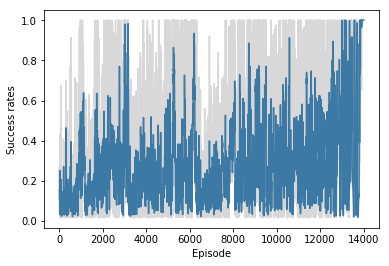

In [78]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

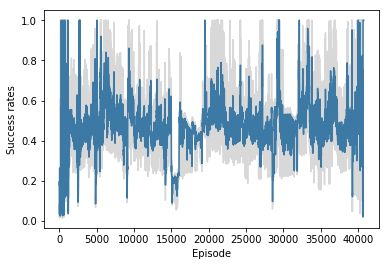

In [59]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

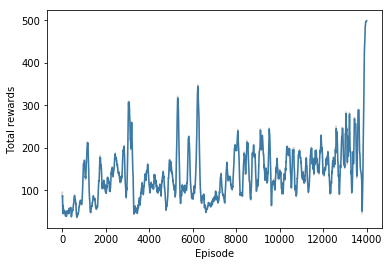

In [72]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

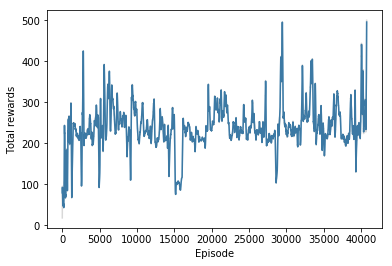

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

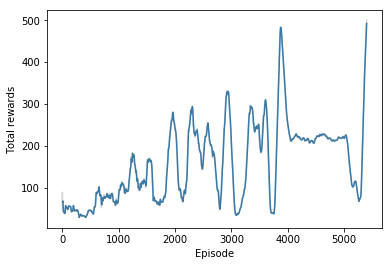

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

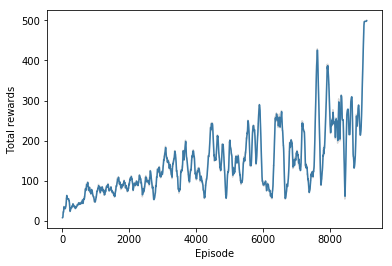

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

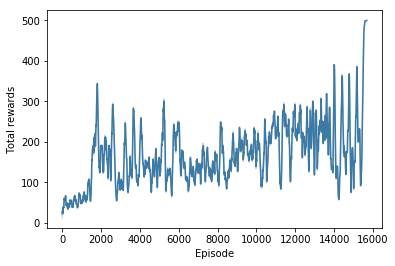

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

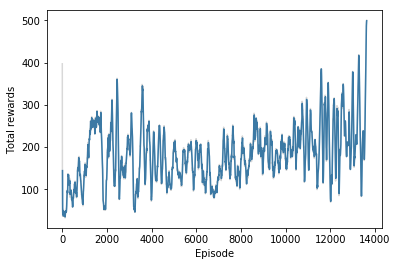

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

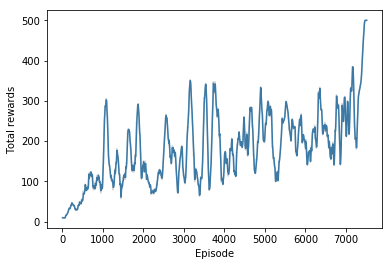

Text(0,0.5,'G losses')

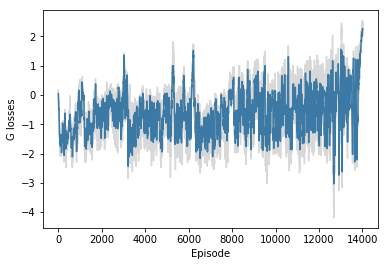

In [73]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

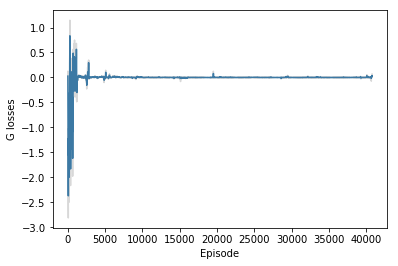

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

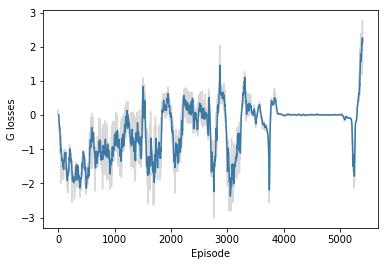

In [28]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

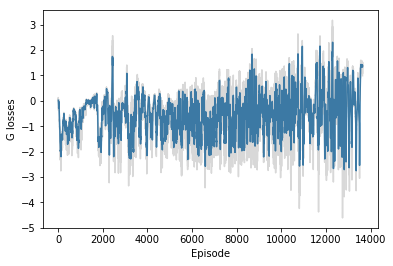

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

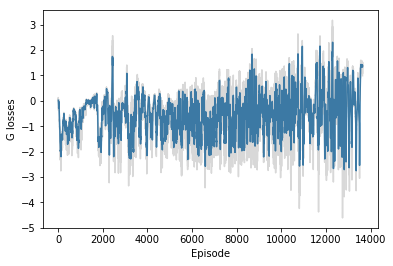

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

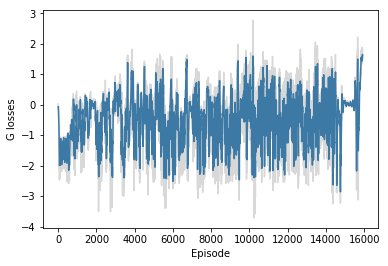
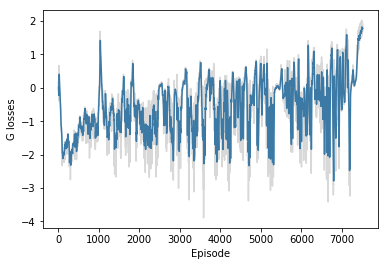

Text(0,0.5,'D losses')

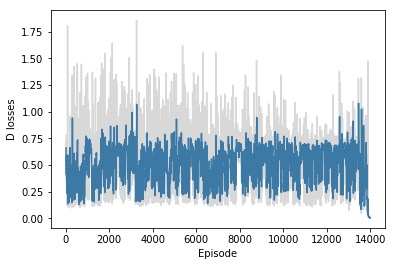

In [74]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

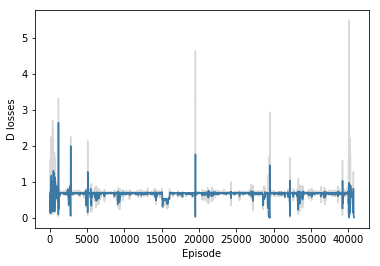

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

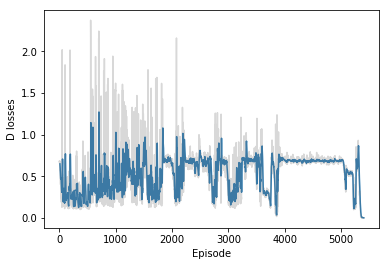

In [29]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

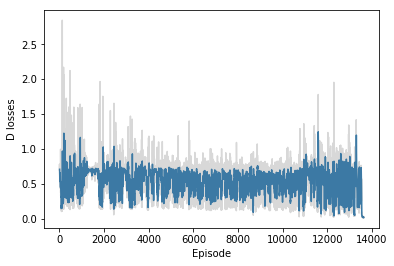

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

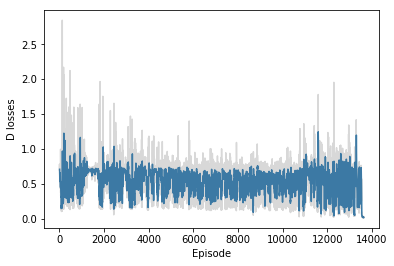

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

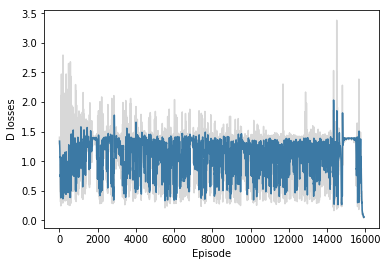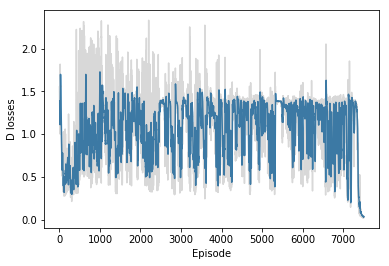

Text(0,0.5,'D losses R')

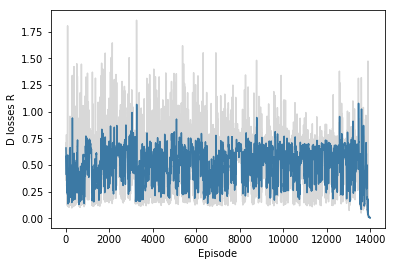

In [75]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

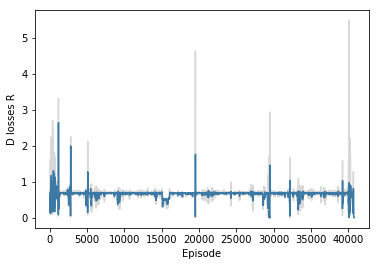

In [57]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

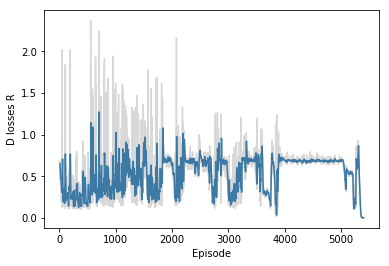

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

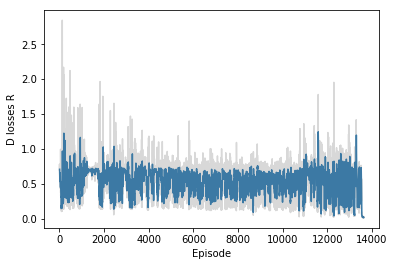

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

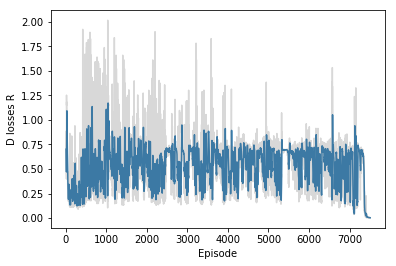

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

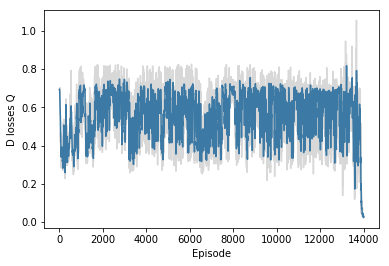

In [76]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

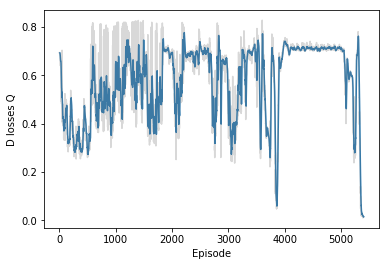

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

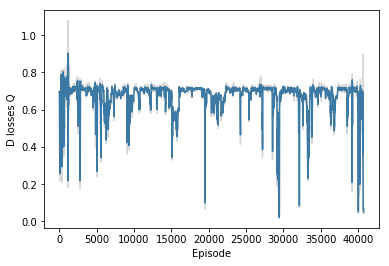

In [58]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

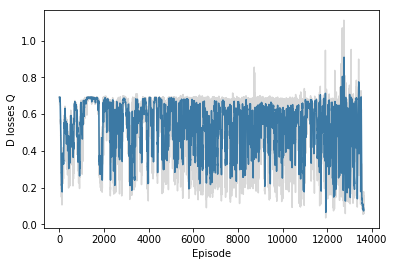

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

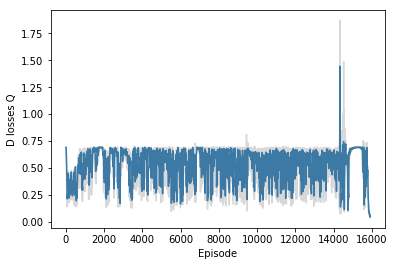

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

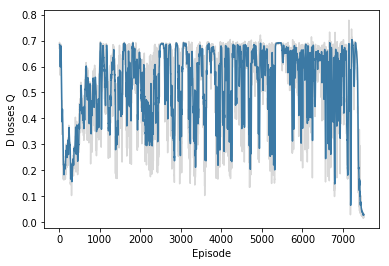

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.